In [ ]:
# Optional: If using google colab, install the required packages
!pip install transformers[torch] datasets evaluate captum

In [2]:
# Imports
import torch
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import spearmanr
from sklearn.metrics import ndcg_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, normalize
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics import ndcg_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from datasets import Dataset
from evaluate import load
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
# Load sequences from csv
df = pd.read_csv('../Data/LazBF_sequences.csv')
LazBF_sequences = df['sequences'].tolist()
LazBF_labels = df['labels'].tolist()

df = pd.read_csv('../Data/LazBF_sample.csv')
LazBF_sample = df['sequences'].tolist()
LazBF_sample_labels = df['labels'].tolist()

df = pd.read_csv('.../Data/LazDEF_sequences.csv')
LazDEF_sequences = df['sequences'].tolist()
LazDEF_labels = df['labels'].tolist()

df = pd.read_csv('../Data/LazDEF_sample.csv')
LazDEF_sample = df['sequences'].tolist()
LazDEF_sample_labels = df['labels'].tolist()

df = pd.read_csv('../Data/LazBCDEF_sequences.csv')
LazBCDEF_sequences = df['sequences'].tolist()
LazBCDEF_labels = df['labels'].tolist()

df = pd.read_csv('../Data/LazBCDEF_sample.csv')
LazBCDEF_sample = df['sequences'].tolist()
LazBCDEF_sample_labels = df['labels'].tolist()

In [37]:
# Load 35M-parameter fine-tuned models
LazBF_model = AutoModelForSequenceClassification.from_pretrained('jjoecclark/LazBF_ft_35M').to(device).eval()
LazDEF_model = AutoModelForSequenceClassification.from_pretrained('jjoecclark/LazDEF_ft_35M').to(device).eval()
LazBCDEF_model = AutoModelForSequenceClassification.from_pretrained('jjoecclark/LazBCDEF_ft_35M').to(device).eval()

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [43]:
# Define trainers to evaluate the performance of each model on different data sets
training_args = TrainingArguments(
    output_dir="esm_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=2,
    weight_decay=0.01,
    push_to_hub=False,
    fp16=True,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

metric = load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

LazBF_trainer = Trainer(
    model=LazBF_model,
    args=training_args,
    compute_metrics=compute_metrics
)

LazDEF_trainer = Trainer(
    model=LazDEF_model,
    args=training_args,
    compute_metrics=compute_metrics
)

LazBCDEF_trainer = Trainer(
    model=LazBCDEF_model,
    args=training_args,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [47]:
# Make data set objects out of the sequences
lbf = Dataset.from_dict(tokenizer(LazBF_sample))
lbf = lbf.add_column("labels", LazBF_sample_labels)

ldef = Dataset.from_dict(tokenizer(LazDEF_sample))
ldef = ldef.add_column("labels", LazDEF_sample_labels)

lbcdef = Dataset.from_dict(tokenizer(LazBCDEF_sample, padding='longest'))
lbcdef = lbcdef.add_column("labels", LazBCDEF_sample_labels)

In [48]:
LazBF_trainer.evaluate(lbf)

{'eval_loss': 0.01938827522099018,
 'eval_model_preparation_time': 0.0058,
 'eval_accuracy': 0.99376,
 'eval_runtime': 13.1086,
 'eval_samples_per_second': 3814.285,
 'eval_steps_per_second': 29.828}

In [30]:
LazBF_trainer.evaluate(ldef)

{'eval_loss': 3.854262113571167,
 'eval_model_preparation_time': 0.0062,
 'eval_accuracy': 0.50892,
 'eval_runtime': 13.7268,
 'eval_samples_per_second': 3642.518,
 'eval_steps_per_second': 28.484}

In [49]:
LazBF_trainer.evaluate(lbcdef)

{'eval_loss': 3.5481274127960205,
 'eval_model_preparation_time': 0.0058,
 'eval_accuracy': 0.5228,
 'eval_runtime': 12.9757,
 'eval_samples_per_second': 3853.344,
 'eval_steps_per_second': 30.133}

In [28]:
LazDEF_trainer.evaluate(lbf)

{'eval_loss': 1.1415808200836182,
 'eval_model_preparation_time': 0.0109,
 'eval_accuracy': 0.6968,
 'eval_runtime': 10.7827,
 'eval_samples_per_second': 4637.058,
 'eval_steps_per_second': 36.262}

In [29]:
LazDEF_trainer.evaluate(ldef)

{'eval_loss': 0.02583152800798416,
 'eval_model_preparation_time': 0.0109,
 'eval_accuracy': 0.99186,
 'eval_runtime': 13.8828,
 'eval_samples_per_second': 3601.58,
 'eval_steps_per_second': 28.164}

In [50]:
LazDEF_trainer.evaluate(lbcdef)

{'eval_loss': 1.3730530738830566,
 'eval_model_preparation_time': 0.0058,
 'eval_accuracy': 0.64178,
 'eval_runtime': 11.4792,
 'eval_samples_per_second': 4355.708,
 'eval_steps_per_second': 34.062}

In [51]:
LazBCDEF_trainer.evaluate(lbf)

{'eval_loss': 1.028061866760254,
 'eval_model_preparation_time': 0.0049,
 'eval_accuracy': 0.6442,
 'eval_runtime': 10.8722,
 'eval_samples_per_second': 4598.865,
 'eval_steps_per_second': 35.963}

In [52]:
LazBCDEF_trainer.evaluate(ldef)

{'eval_loss': 1.3182048797607422,
 'eval_model_preparation_time': 0.0049,
 'eval_accuracy': 0.58868,
 'eval_runtime': 13.9283,
 'eval_samples_per_second': 3589.812,
 'eval_steps_per_second': 28.072}

In [53]:
LazBCDEF_trainer.evaluate(lbcdef)

{'eval_loss': 0.11979516595602036,
 'eval_model_preparation_time': 0.0049,
 'eval_accuracy': 0.9582,
 'eval_runtime': 13.4861,
 'eval_samples_per_second': 3707.526,
 'eval_steps_per_second': 28.993}

---

In [32]:
# Interpretability Helper functions

from torch import tensor
import matplotlib.colors as mcolors
from transformers.pipelines import TextClassificationPipeline
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, IntegratedGradients
from matplotlib.font_manager import FontProperties

import matplotlib.pyplot as plt
sm = torch.nn.Softmax(dim=1)


class ExplainableTransformerPipeline():
    def __init__(self, name, device):
        self.__name = name
        self.__device = device

    def forward_func(self, inputs: tensor, position = 0):
        pred = model.forward(inputs)
        return pred[position]

    def visualize(self, inputs: list, attributes: list, prediction):
        attr_sum = attributes.sum(-1)
        attr = attr_sum #/ torch.norm(attr_sum)
        attr = [float(at) for at in attr_sum[0]]
        y = np.array(attr)
        #y*=-1
        #a = pd.Series(attr.numpy()[0], index = tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]))
        peptide = tokenizer(sample).input_ids #[1:-1] #list(sample)
        words = [tokenizer.decode(i) for i in peptide]
        #return y
        #print(y)
        #cmap = plt.cm.get_cmap('cividis') # Use the 'viridis' colormap
        #norm = plt.Normalize(min(y), max(y))


        letters = np.array(words[1:-1])
        colors = np.array([mcolors.to_hex(cmap(norm(datapoint))) for datapoint in y[1:-1]])
        positions = np.arange(len(letters))

        print("Model's prediction:", str(float(prediction[0][0])))

        fig, ax = plt.subplots()

        for i, letter in enumerate(letters):
          rect = plt.Rectangle((positions[i], 0), 1, 1, color=colors[i])
          ax.add_patch(rect)
          plt.text(positions[i]+0.5, 0.5, letter, ha='center', va='center', fontsize=100)

        ax.set_xlim([0, len(letters)])
        ax.set_ylim([0, 1])
        ax.set_xticks([])
        ax.set_yticks([])
        fig.set_size_inches(200, 10)
        plt.show()

    def explain(self, text: str, label):
        inputs = torch.tensor(tokenizer.encode(text, add_special_tokens=True), device=self.__device).unsqueeze(0)
        prediction = model.forward(inputs)[0]
        baseline = torch.tensor([tokenizer.cls_token_id] + [tokenizer.pad_token_id] * (inputs.shape[1] - 2) + [tokenizer.eos_token_id], device = self.__device).unsqueeze(0)
        lig = LayerIntegratedGradients(self.forward_func, model.esm.embeddings) # The 'layer' from which we want to get the IG's is the mebedding slyaer.
        attributes, delta = lig.attribute(inputs=inputs,
                                  baselines=baseline,
                                  target = label,
                                  return_convergence_delta = True)
        attr_sum = attributes.sum(-1)
        return attr_sum.cpu().numpy()[0][1:-1]
        #return self.visualize(inputs, attributes, prediction) #float(sm(prediction)[0][1]))

    def generate_inputs(self, text: str) -> tensor:
        return torch.tensor(tokenizer.encode(text, add_special_tokens=True), device=self.__device).unsqueeze(0)

    def generate_baseline(self, sequence_len: int) -> tensor:
        return torch.tensor([tokenizer.cls_token_id] + [tokenizer.pad_token_id] * (sequence_len - 2) + [tokenizer.eos_token_id], device = self.__device).unsqueeze(0)

In [33]:
#@title Amino acid dictionary
amino_acids = {
    'R': 0,
    'H': 1,
    'K': 2,
    'D': 3,
    'E': 4,
    'S': 5,
    'T': 6,
    'N': 7,
    'Q': 8,
    'C': 9,
    'G': 10,
    'P': 11,
    'A': 12,
    'V': 13,
    'I': 14,
    'L': 15,
    'M': 16,
    'F': 17,
    'Y': 18,
    'W': 19,
}

In [23]:
#@title Helper functions
csfont = {'fontname':'Times New Roman'}

def full_last_layer(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  matrs = []
  for i, head in enumerate(output.attentions[-1][0]):
      matr = head.cpu().detach().numpy()
      matrs.append(matr)
      plt.imshow(matr, interpolation='nearest')
      x_ticks = np.arange(0, matr.shape[1])
      x_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
      plt.xticks(x_ticks, x_tick_labels)
      y_ticks = np.arange(0, matr.shape[1])
      y_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
      sizes = [9] + 13*[14] + [9]
      plt.yticks(y_ticks, y_tick_labels)
      for j, label in enumerate(plt.xticks()[1]):
        label.set_fontsize(sizes[j])
      for j, label in enumerate(plt.yticks()[1]):
        label.set_fontsize(sizes[j])
      plt.title(f"Layer 12, Head {i+1}", fontsize=17)
      plt.colorbar()
      #plt.text(-4, -0.9, 'c', fontsize=20) #, transform=ax.transAxes)
      plt.savefig(f'./VIGGRTCDGTRYY_head_{i+1}_alt.png', dpi=400, bbox_inches='tight', pad_inches=0)
      plt.show()
def full_attention(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  matrs = []
  for layer, att in enumerate(output.attentions):
    for i, head in enumerate(att[0]):
      print(f'Layer {layer}, head {i}')
      matr = head.cpu().detach().numpy()
      matrs.append(matr)
      plt.imshow(matr, interpolation='nearest')
      x_ticks = np.arange(0, matr.shape[1])
      x_tick_labels = list(" "+sequence+" ")
      plt.xticks(x_ticks, x_tick_labels)
      y_ticks = np.arange(0, matr.shape[1])
      y_tick_labels = list(" "+sequence+" ")
      plt.yticks(y_ticks, y_tick_labels)
      plt.show()

def per_layer_attention(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  for i, att in enumerate(output.attentions):
    matrs = []
    for head in att[0]:
      matr = head.cpu().detach().numpy()
      matrs.append(matr)
    matrs = np.array(matrs)
    plt.imshow(np.mean(matrs, axis=0), interpolation='nearest', vmin=0, vmax=0.3)
    x_ticks = np.arange(0, matr.shape[1])
    x_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]

    plt.xticks(x_ticks, x_tick_labels)
    sizes = [10] + 11*[15] + [10]
    for j, label in enumerate(plt.xticks()[1]):
      label.set_fontsize(sizes[j])

    y_ticks = np.arange(0, matr.shape[1])
    y_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
    plt.yticks(y_ticks, y_tick_labels)
    sizes = [10] + 11*[15] + [10]
    for j, label in enumerate(plt.yticks()[1]):
      label.set_fontsize(sizes[j])

    plt.title(f'Average Attention for Layer {i+1}', fontsize=17)
    #plt.text(-4, -0.9, 'a', fontsize=20) #, transform=ax.transAxes)
    plt.colorbar()

    plt.savefig(f'./FVCHPSRWVGA_layer_{i+1}_alt.png', dpi=400, bbox_inches='tight', pad_inches=0)
    plt.show()

def oned_attention(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  for att in output.attentions:
    matrs = []
    for head in att[0]:
      matrs.append(head.cpu().detach().numpy())
    matrs = np.array(matrs)
    matrs = np.mean(matrs, axis=0)
    matrs = np.mean(matrs, axis=0)
    print(matrs[:, np.newaxis].T)
    plt.imshow(matrs[:, np.newaxis].T, interpolation='nearest')
    x_ticks = np.arange(0, len(sequence)+2)
    x_tick_labels = list(" "+sequence+" ")
    plt.xticks(x_ticks, x_tick_labels)
    plt.show()

def layer11(model, sequence):
  input = tokenizer(sequence, return_tensors='pt').to(device)
  output = model.forward(input.input_ids, output_attentions=True)
  matrs = []
  for i, head in enumerate(output.attentions[-2][0]):
      matr = head.cpu().detach().numpy()
      matrs.append(matr)
      plt.imshow(matr, interpolation='nearest', vmin=0, vmax=0.8)
      x_ticks = np.arange(0, matr.shape[1])
      x_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
      plt.xticks(x_ticks, x_tick_labels)
      y_ticks = np.arange(0, matr.shape[1])
      y_tick_labels = ["[BOS]"] + list(sequence) + ["[EOS]"]
      plt.yticks(y_ticks, y_tick_labels)

      sizes = [10] + 11*[15] + [10]
      for j, label in enumerate(plt.xticks()[1]):
        label.set_fontsize(sizes[j])
      for j, label in enumerate(plt.yticks()[1]):
        label.set_fontsize(sizes[j])

      plt.title(f"Layer 11, Head {i+1}", fontsize=17)
      #plt.colorbar()
      plt.text(-4, -0.9, 'b', fontsize=20) #, transform=ax.transAxes)
      plt.savefig(f'./FVCHPSRWVGA_head_{i+1}_alt.png', dpi=400, bbox_inches='tight', pad_inches=0)
      plt.show()

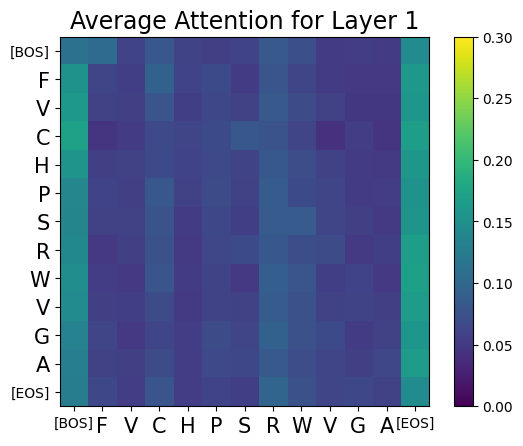

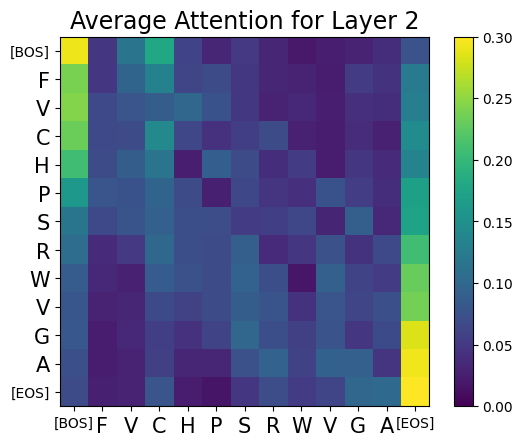

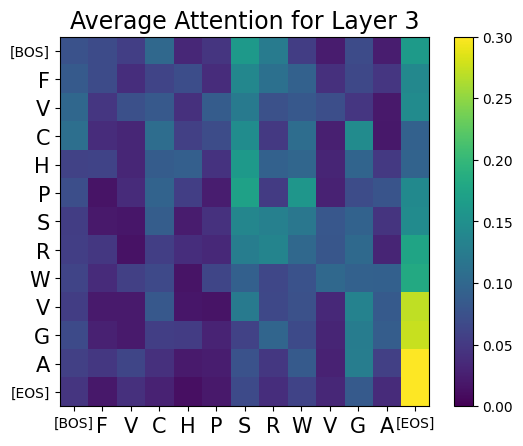

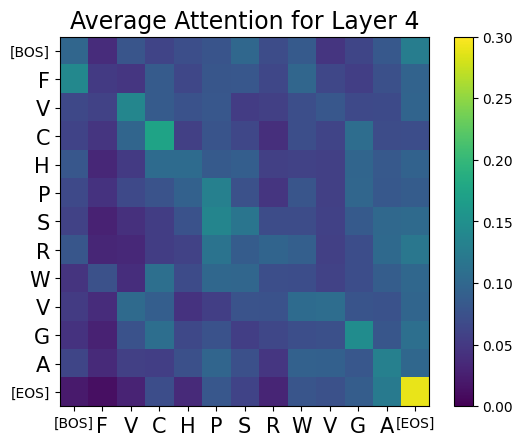

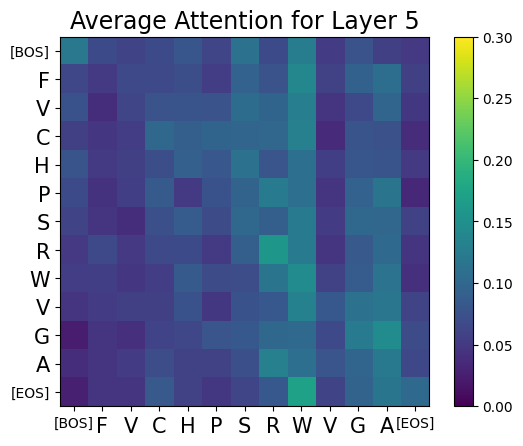

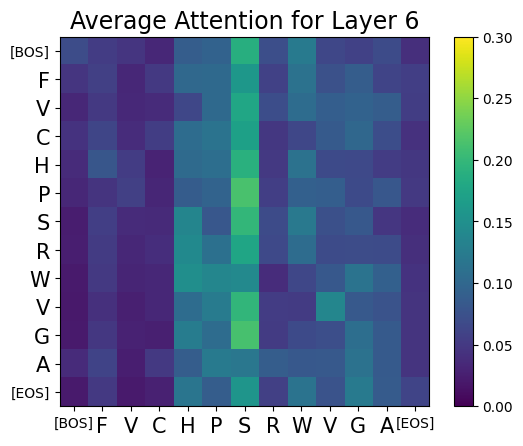

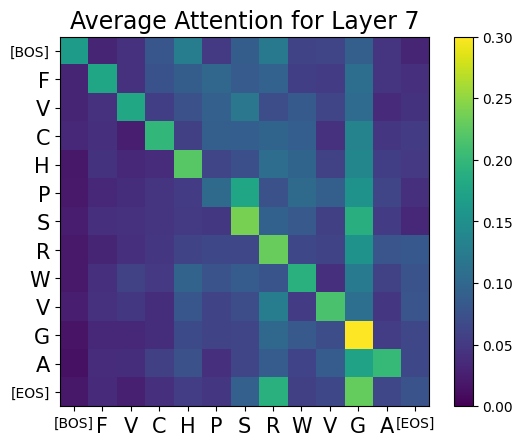

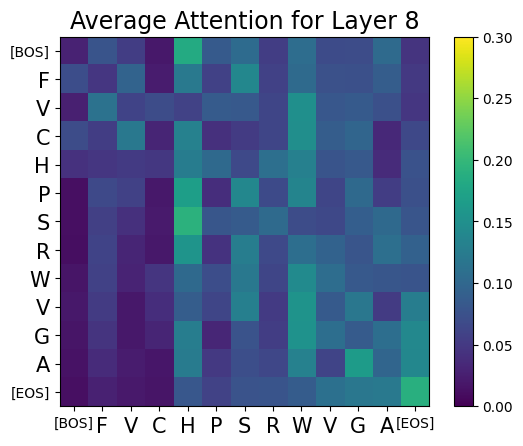

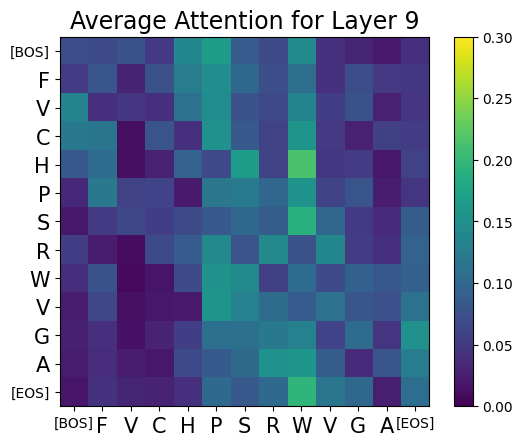

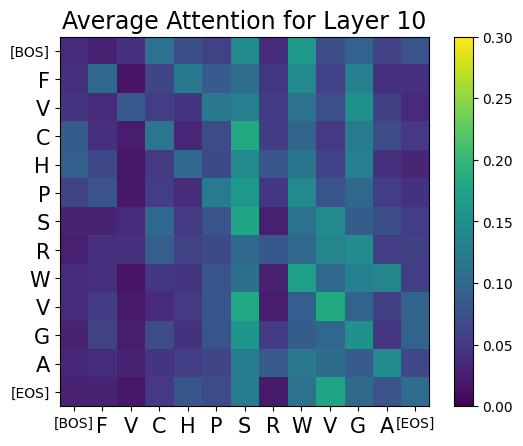

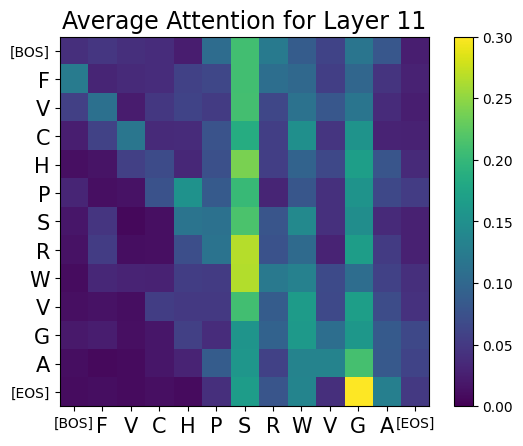

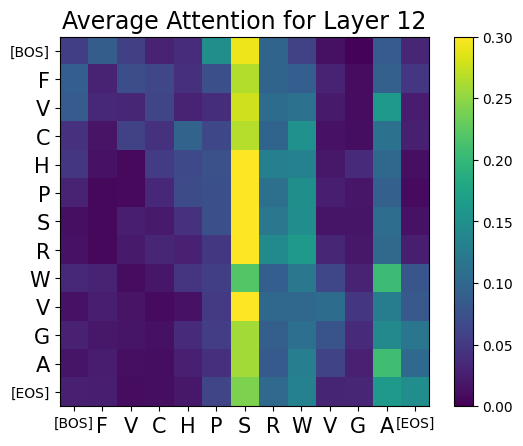

In [24]:
per_layer_attention(LazBF_model, "FVCHPSRWVGA") #'VIGGRTCDGTRYY')

Layer 0, head 0


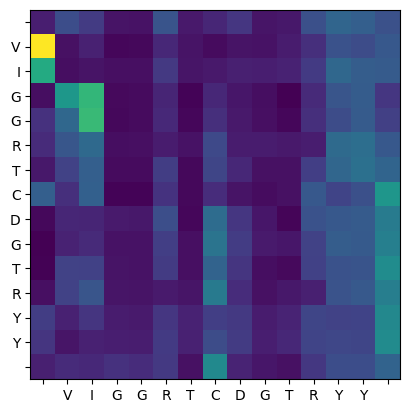

Layer 0, head 1


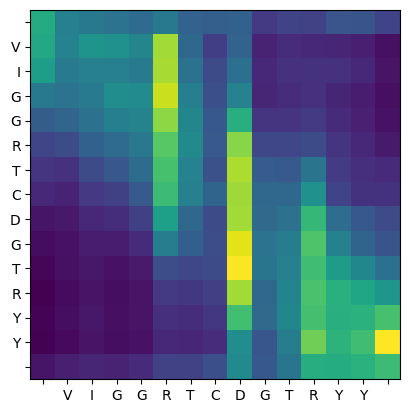

Layer 0, head 2


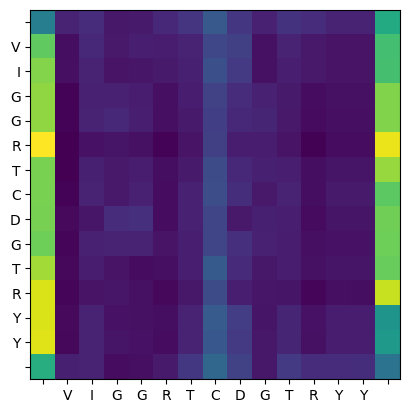

Layer 0, head 3


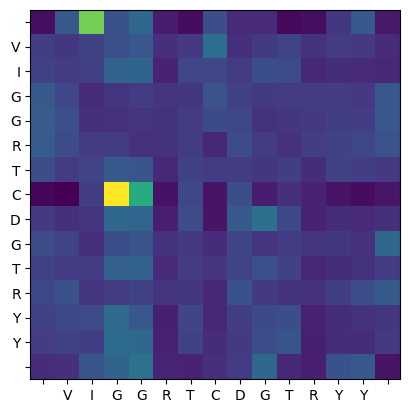

Layer 0, head 4


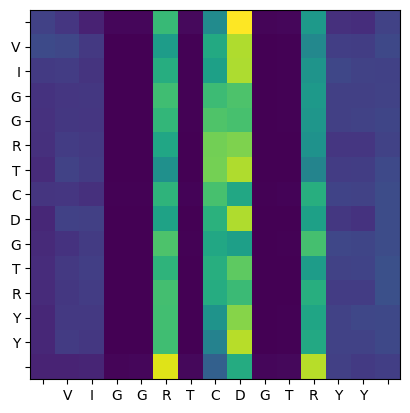

Layer 0, head 5


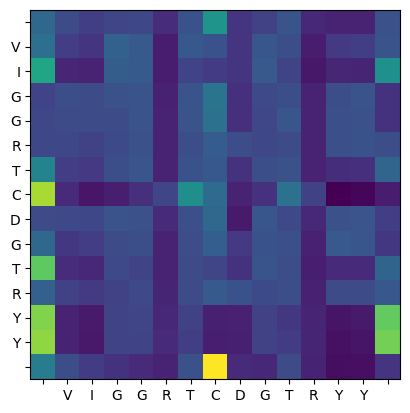

Layer 0, head 6


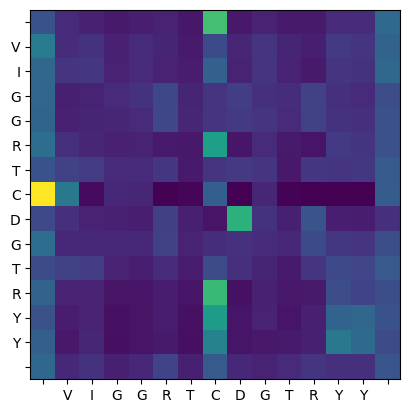

Layer 0, head 7


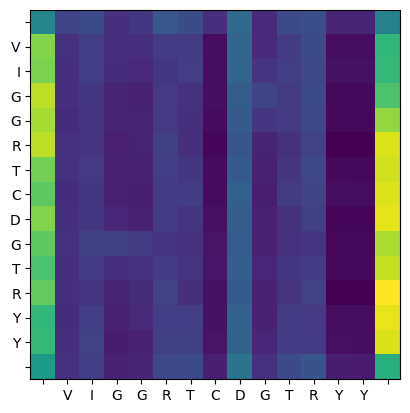

Layer 0, head 8


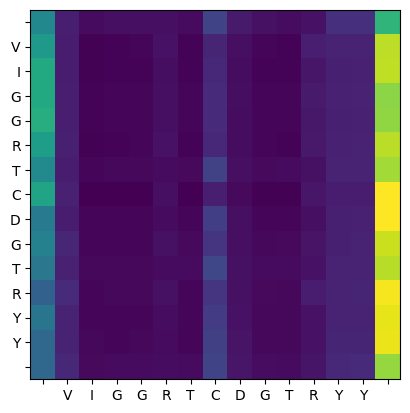

Layer 0, head 9


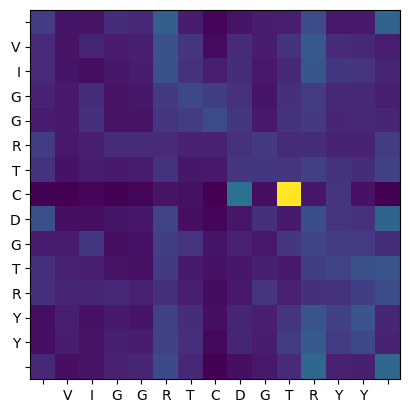

Layer 0, head 10


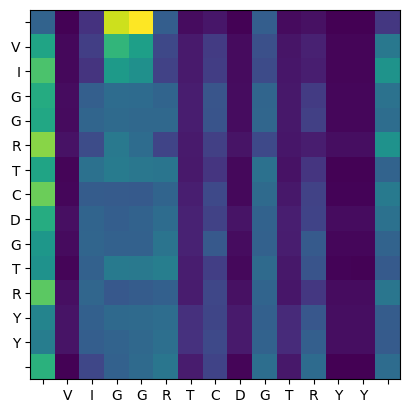

Layer 0, head 11


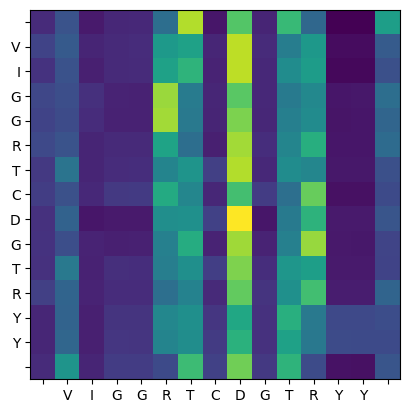

Layer 0, head 12


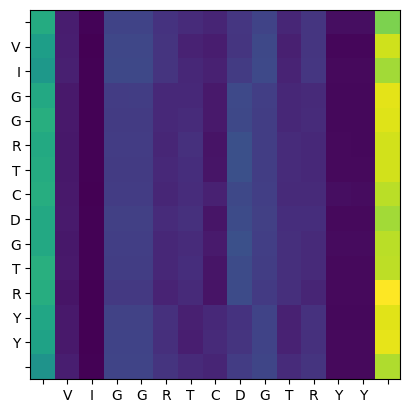

Layer 0, head 13


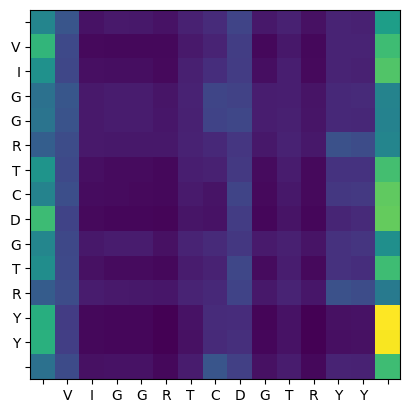

Layer 0, head 14


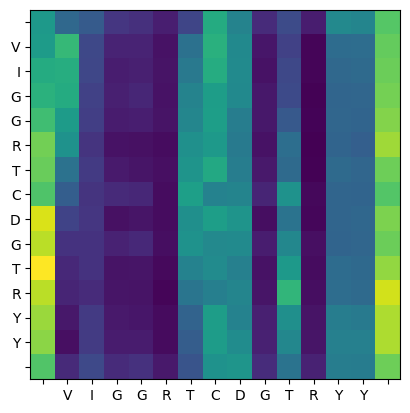

Layer 0, head 15


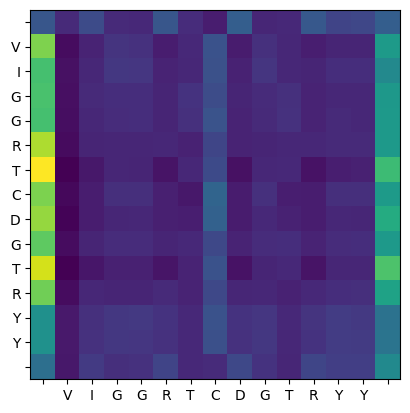

Layer 0, head 16


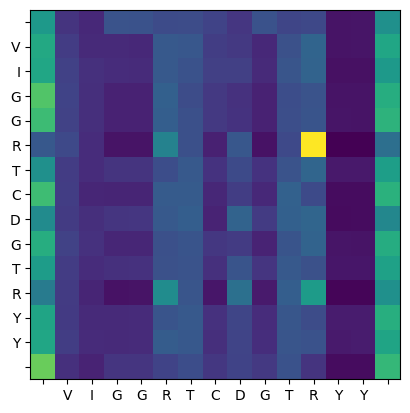

Layer 0, head 17


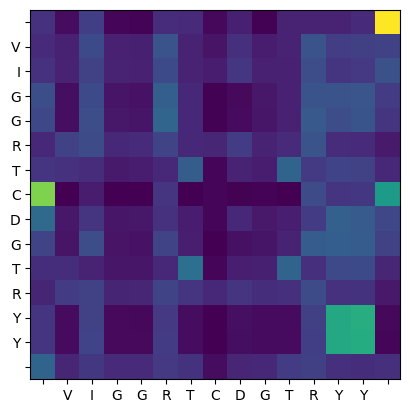

Layer 0, head 18


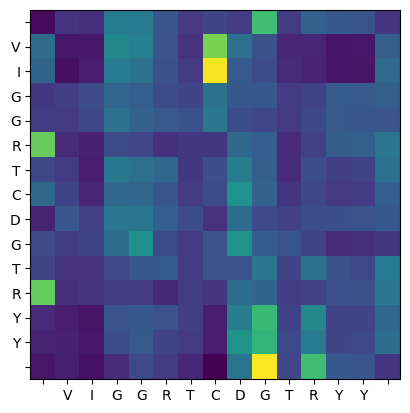

Layer 0, head 19


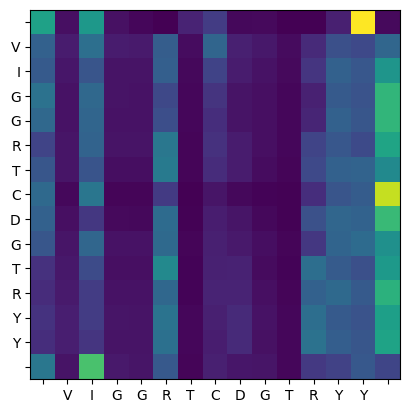

Layer 1, head 0


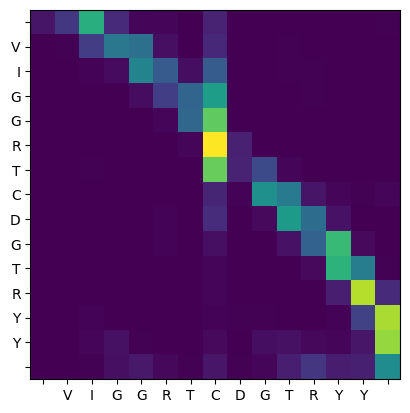

Layer 1, head 1


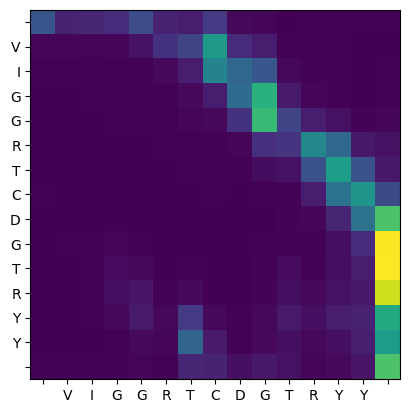

Layer 1, head 2


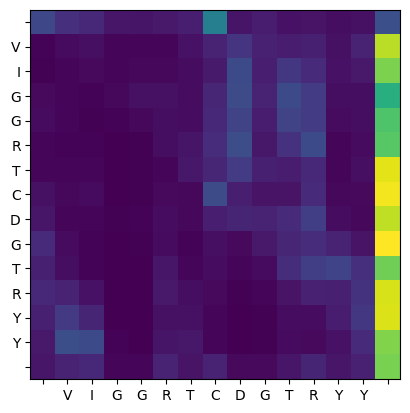

Layer 1, head 3


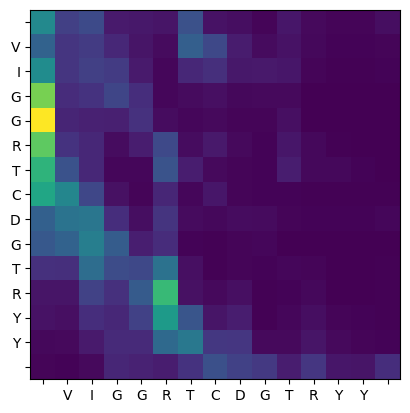

Layer 1, head 4


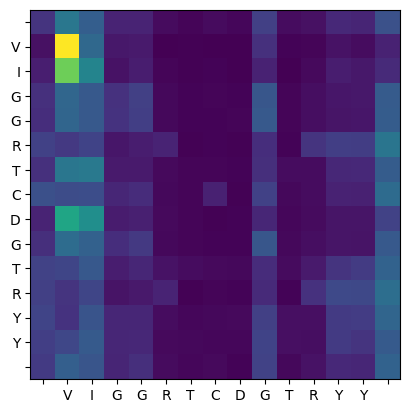

Layer 1, head 5


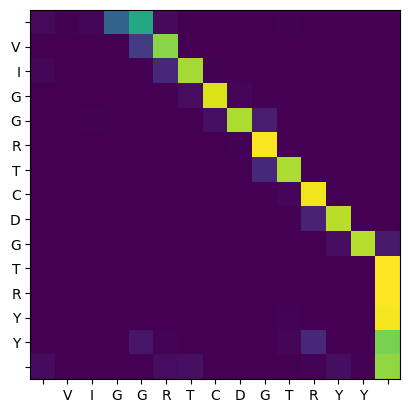

Layer 1, head 6


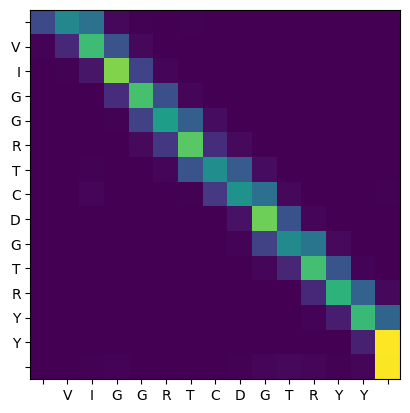

Layer 1, head 7


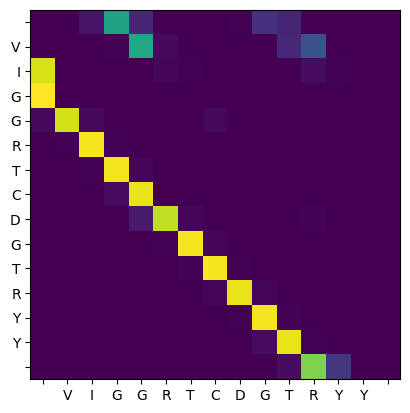

Layer 1, head 8


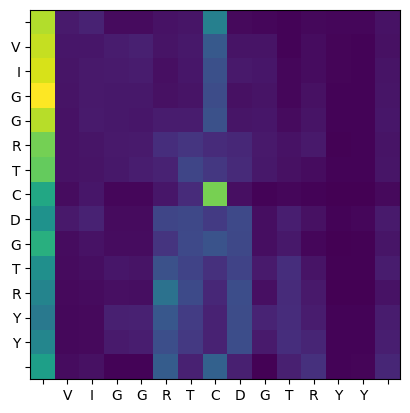

Layer 1, head 9


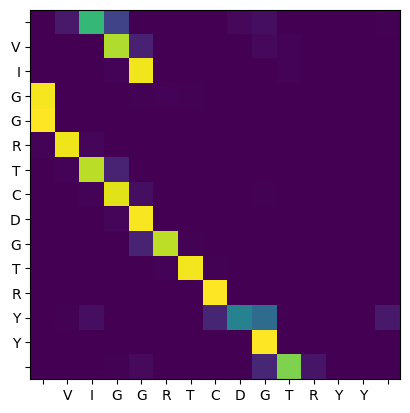

Layer 1, head 10


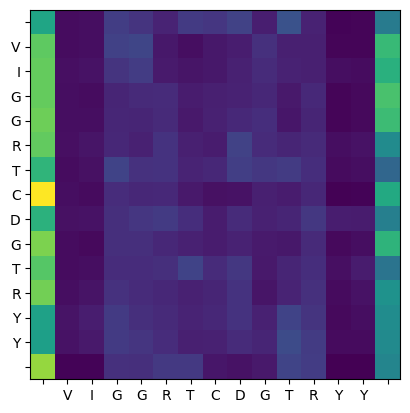

Layer 1, head 11


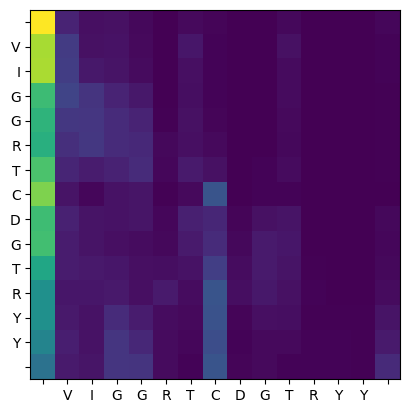

Layer 1, head 12


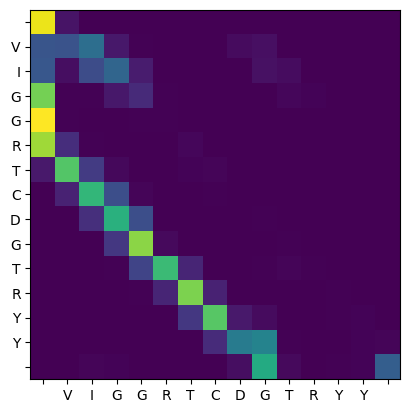

Layer 1, head 13


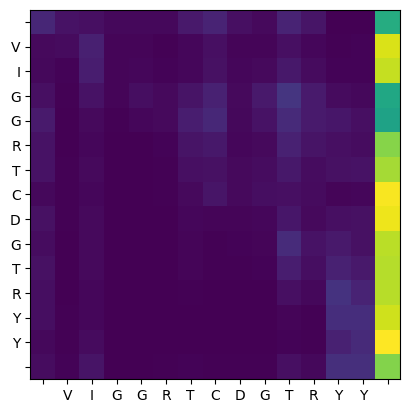

Layer 1, head 14


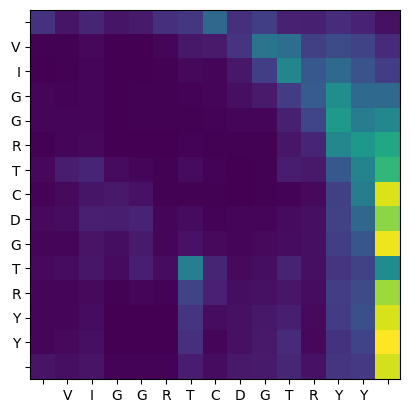

Layer 1, head 15


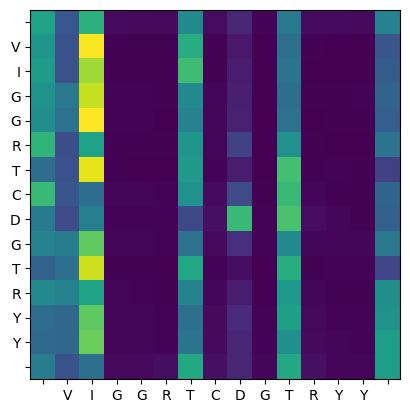

Layer 1, head 16


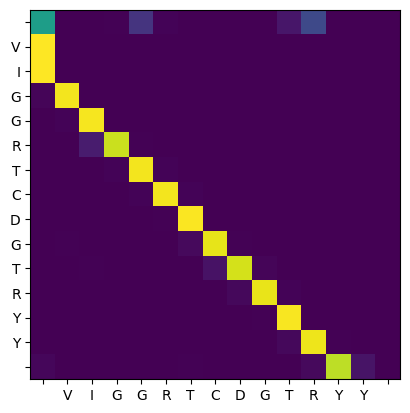

Layer 1, head 17


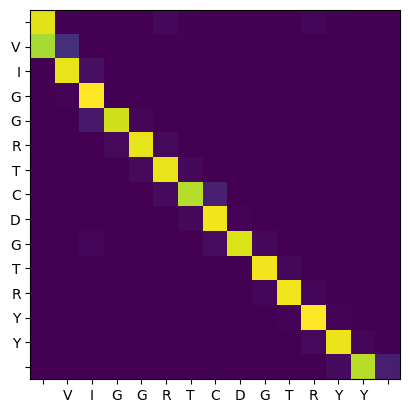

Layer 1, head 18


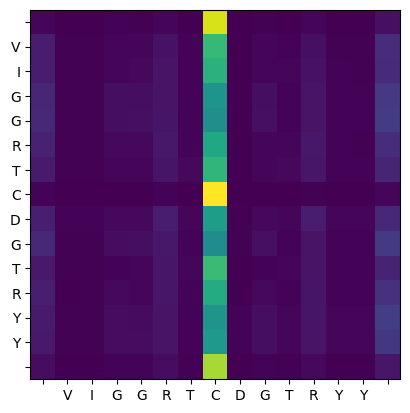

Layer 1, head 19


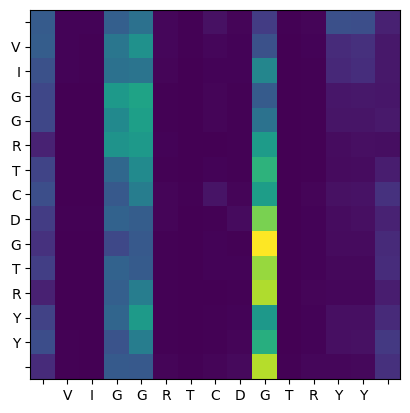

Layer 2, head 0


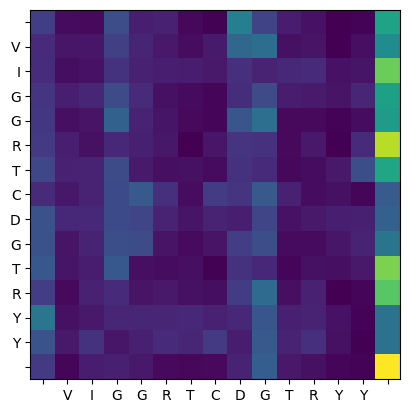

Layer 2, head 1


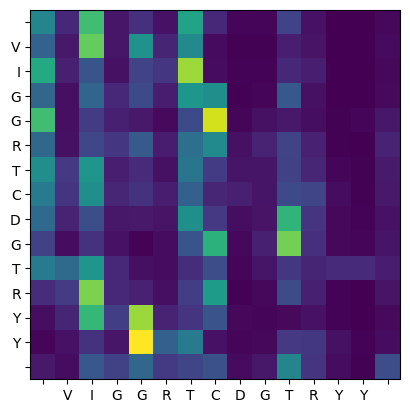

Layer 2, head 2


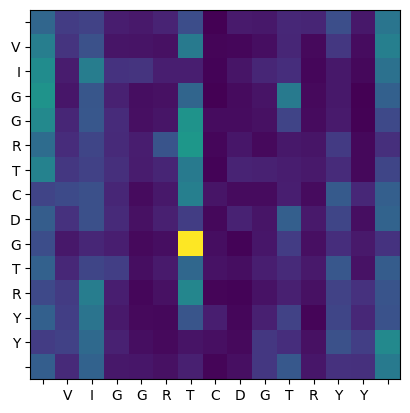

Layer 2, head 3


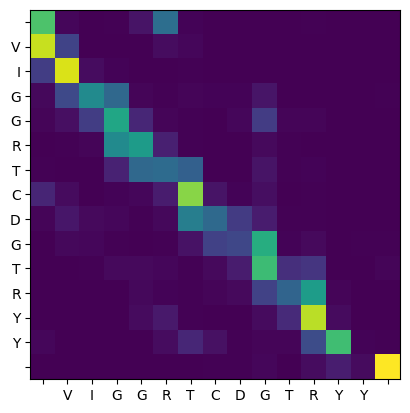

Layer 2, head 4


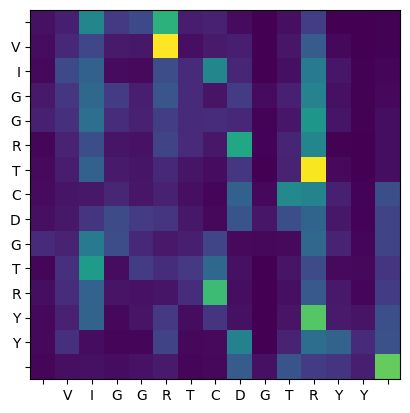

Layer 2, head 5


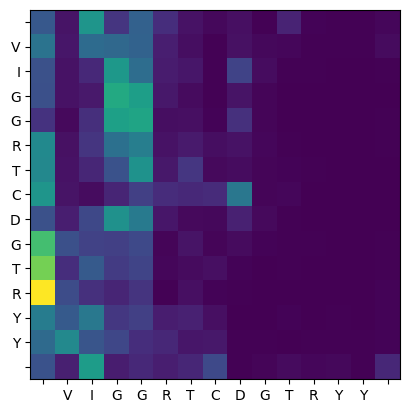

Layer 2, head 6


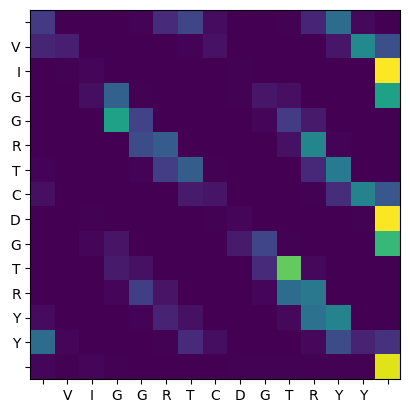

Layer 2, head 7


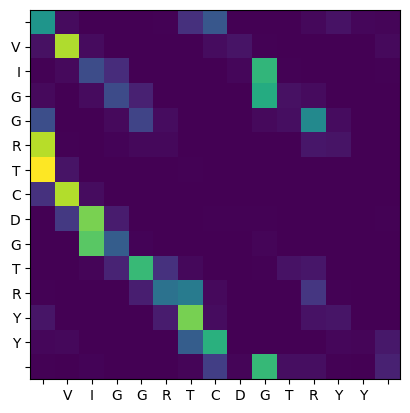

Layer 2, head 8


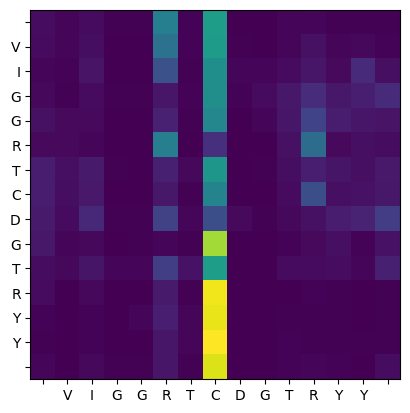

Layer 2, head 9


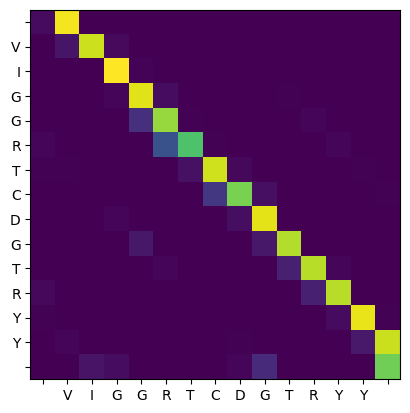

Layer 2, head 10


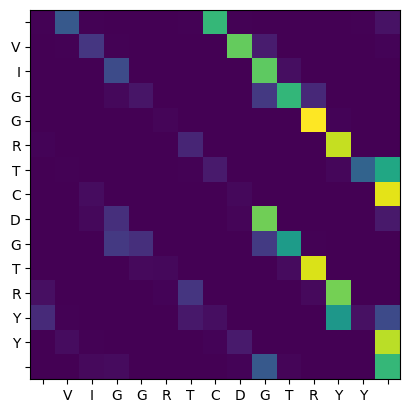

Layer 2, head 11


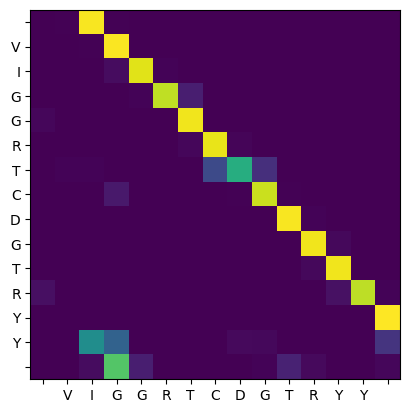

Layer 2, head 12


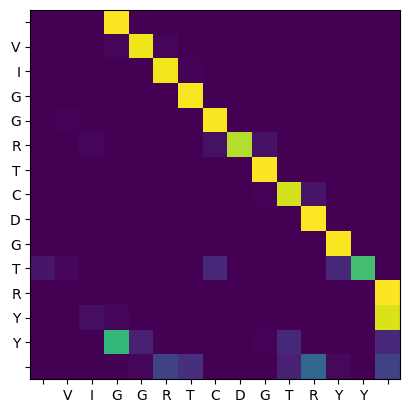

Layer 2, head 13


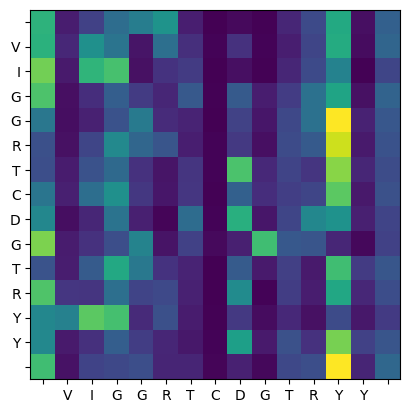

Layer 2, head 14


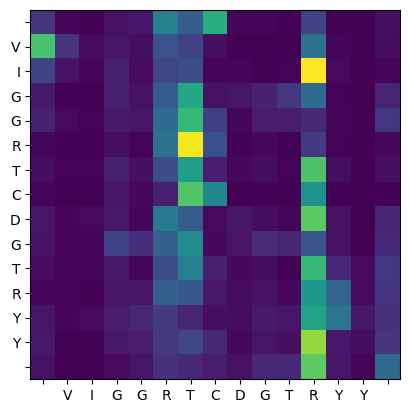

Layer 2, head 15


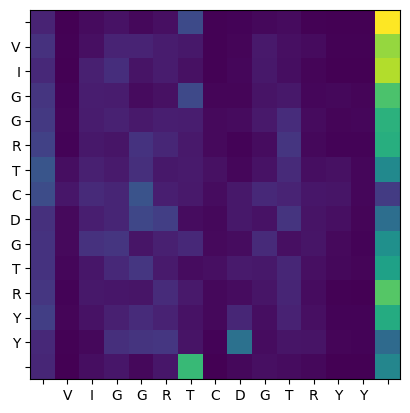

Layer 2, head 16


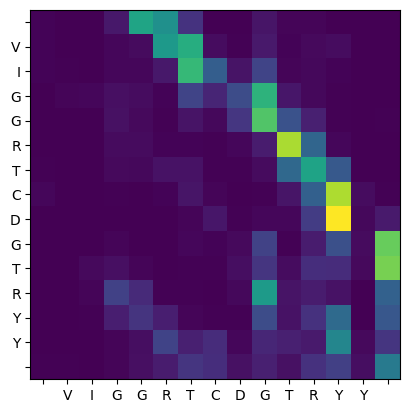

Layer 2, head 17


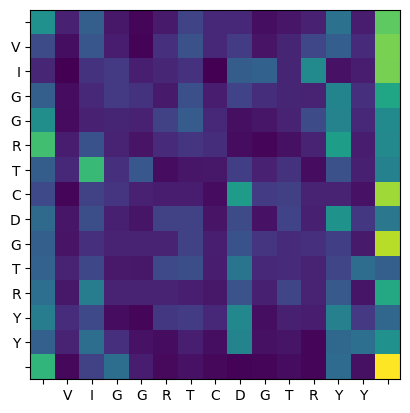

Layer 2, head 18


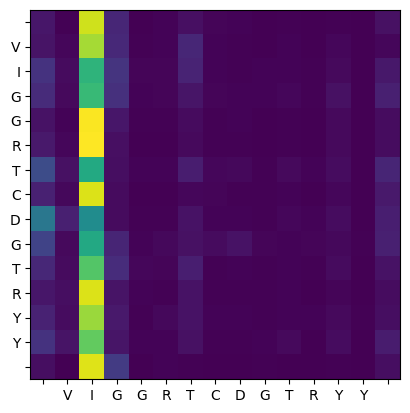

Layer 2, head 19


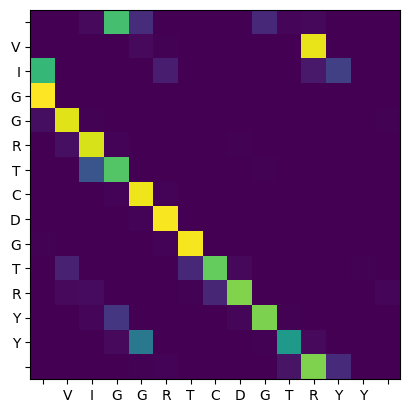

Layer 3, head 0


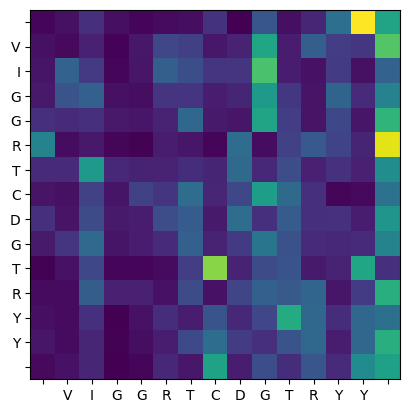

Layer 3, head 1


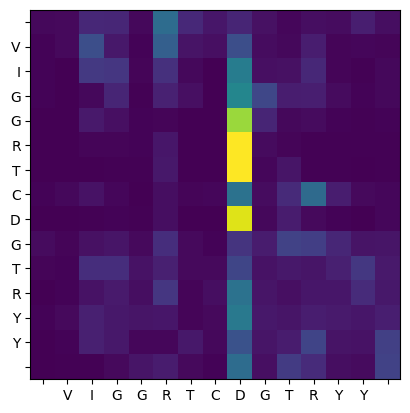

Layer 3, head 2


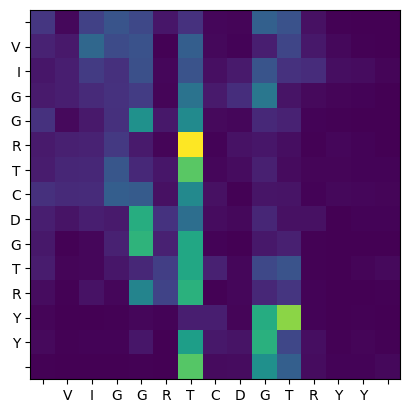

Layer 3, head 3


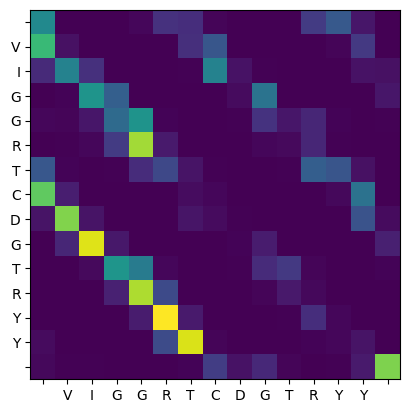

Layer 3, head 4


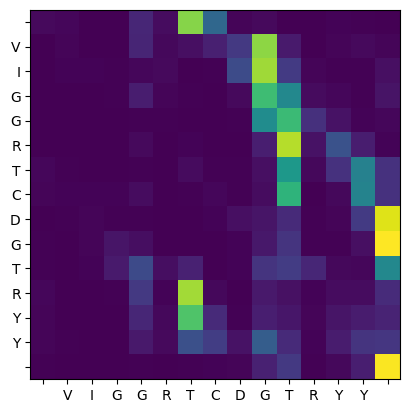

Layer 3, head 5


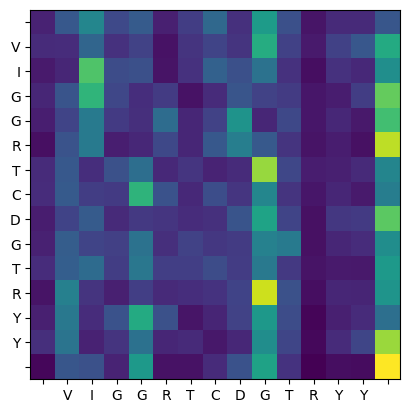

Layer 3, head 6


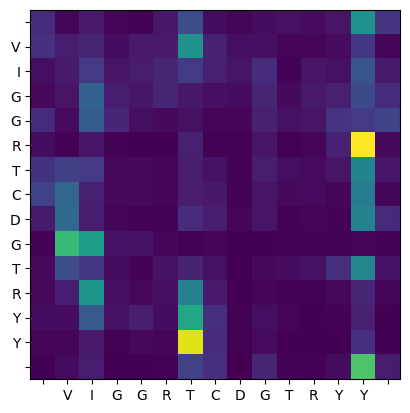

Layer 3, head 7


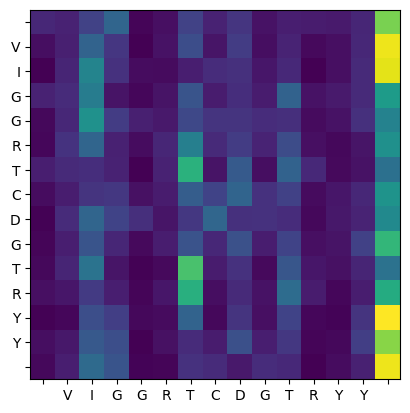

Layer 3, head 8


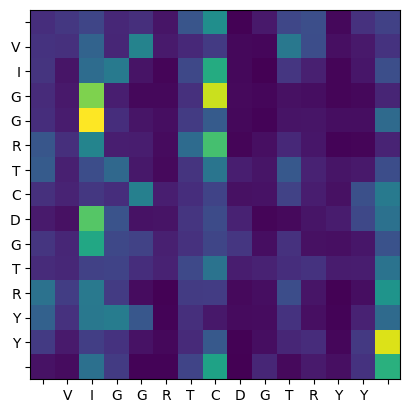

Layer 3, head 9


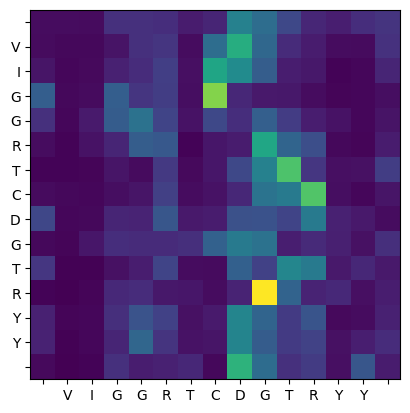

Layer 3, head 10


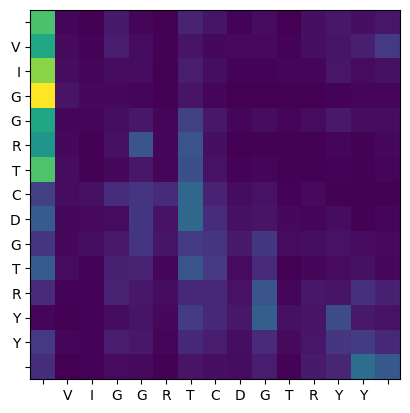

Layer 3, head 11


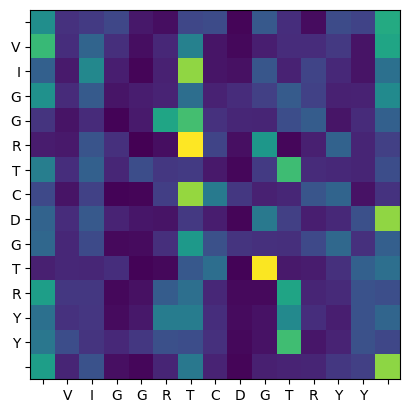

Layer 3, head 12


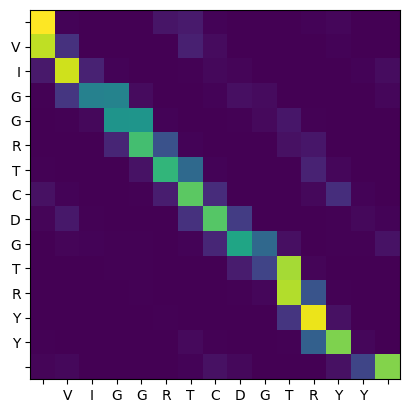

Layer 3, head 13


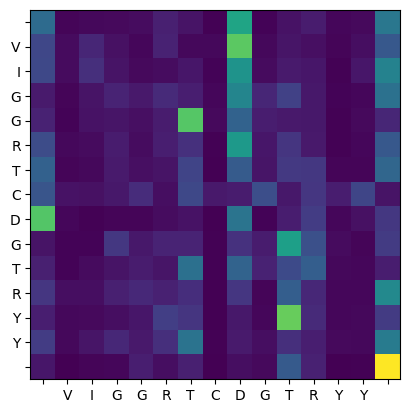

Layer 3, head 14


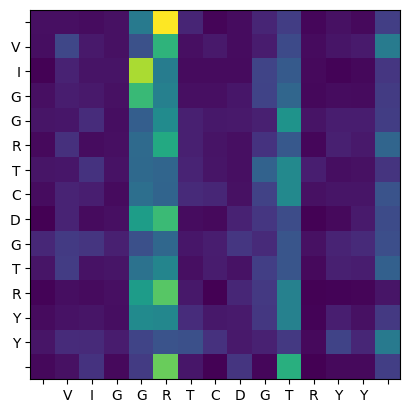

Layer 3, head 15


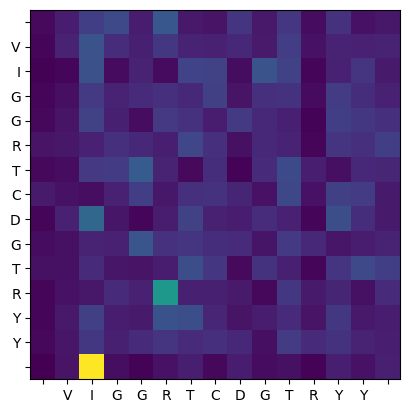

Layer 3, head 16


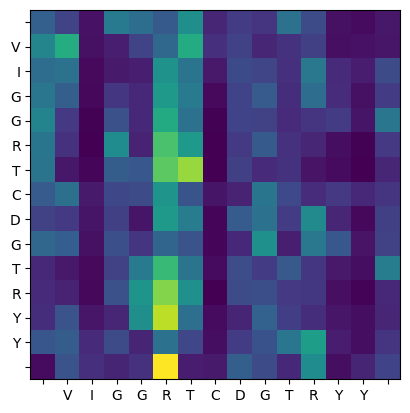

Layer 3, head 17


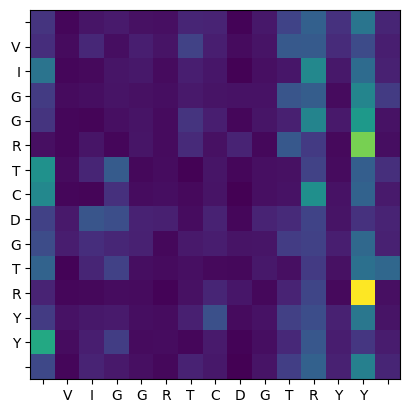

Layer 3, head 18


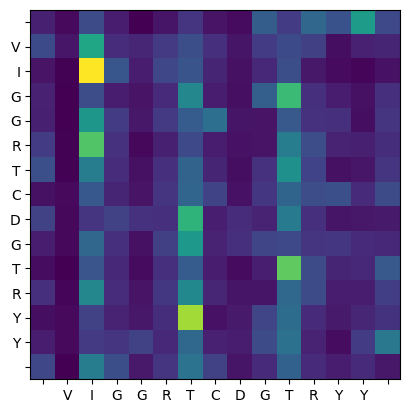

Layer 3, head 19


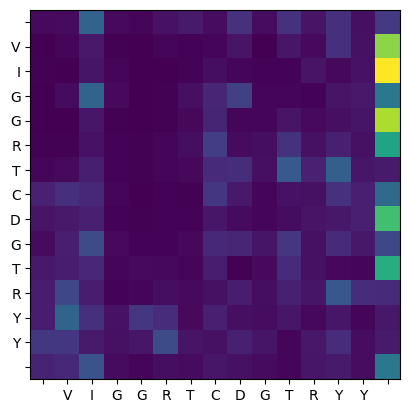

Layer 4, head 0


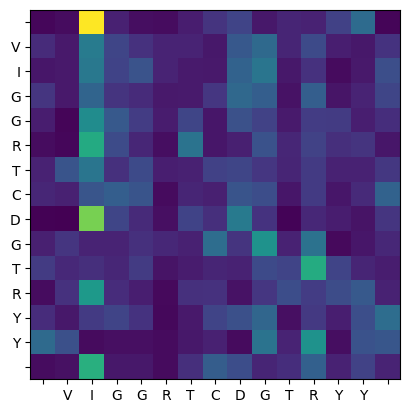

Layer 4, head 1


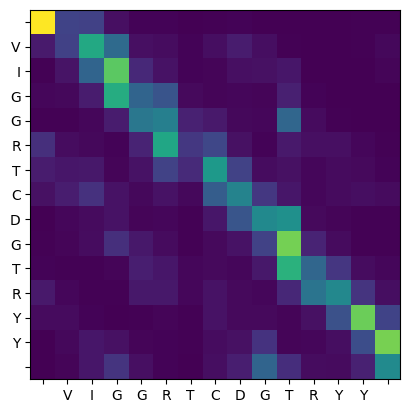

Layer 4, head 2


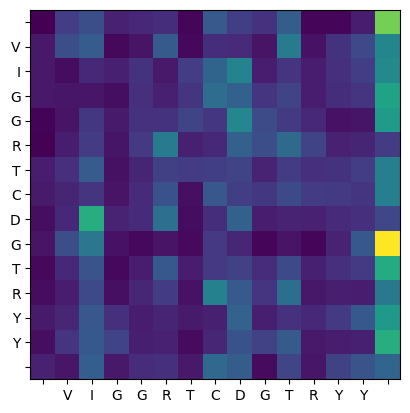

Layer 4, head 3


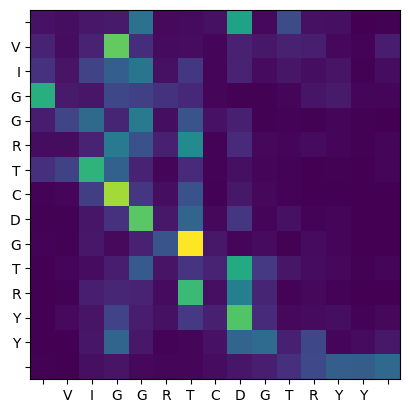

Layer 4, head 4


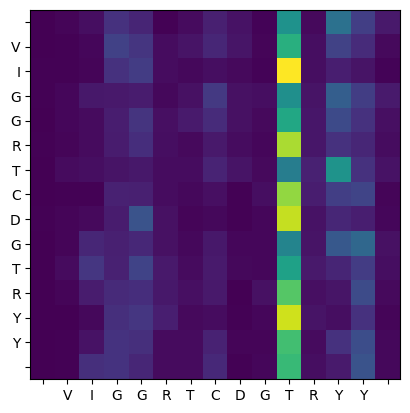

Layer 4, head 5


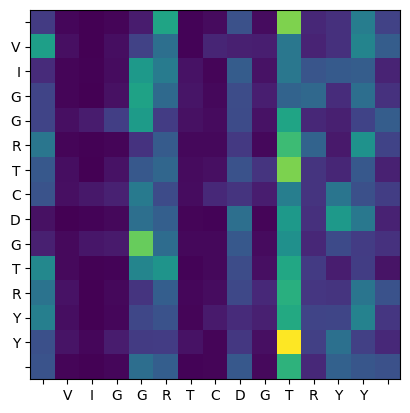

Layer 4, head 6


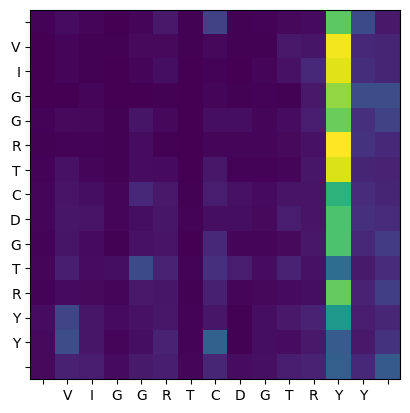

Layer 4, head 7


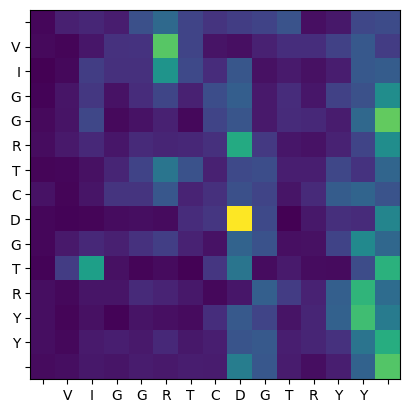

Layer 4, head 8


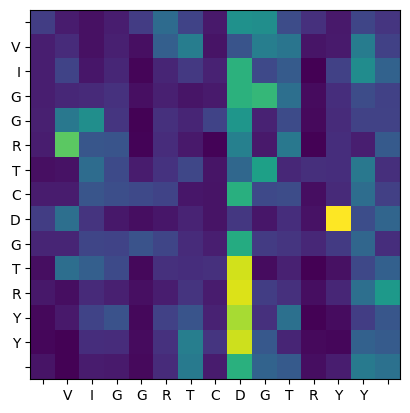

Layer 4, head 9


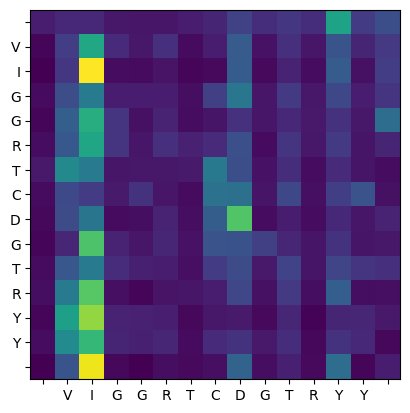

Layer 4, head 10


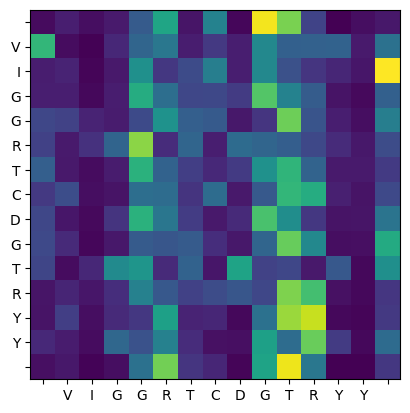

Layer 4, head 11


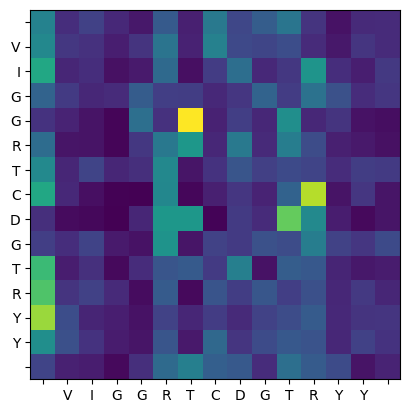

Layer 4, head 12


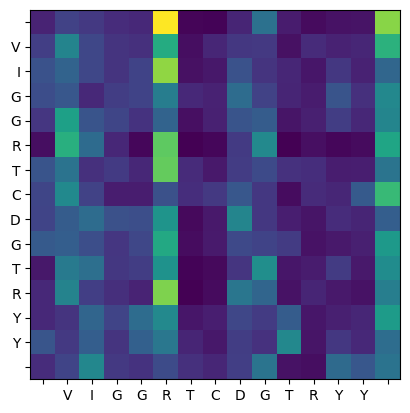

Layer 4, head 13


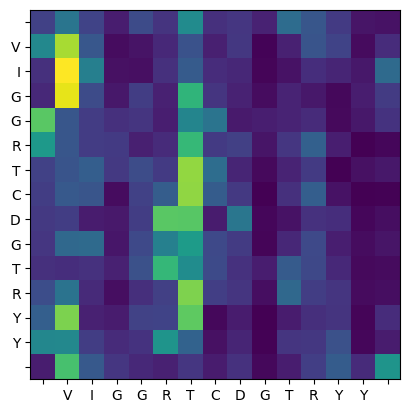

Layer 4, head 14


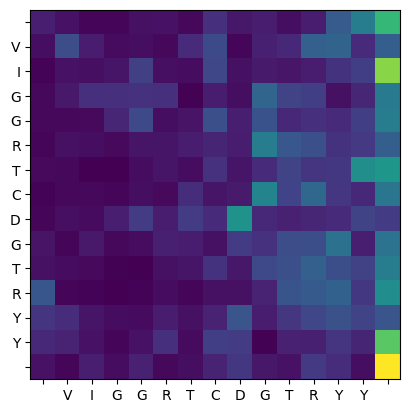

Layer 4, head 15


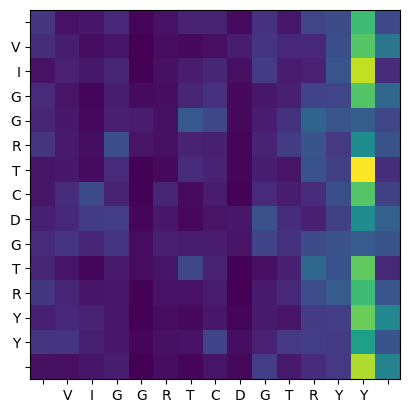

Layer 4, head 16


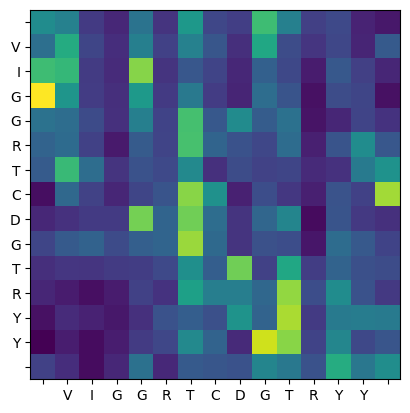

Layer 4, head 17


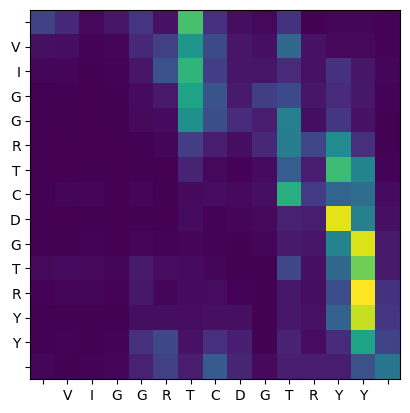

Layer 4, head 18


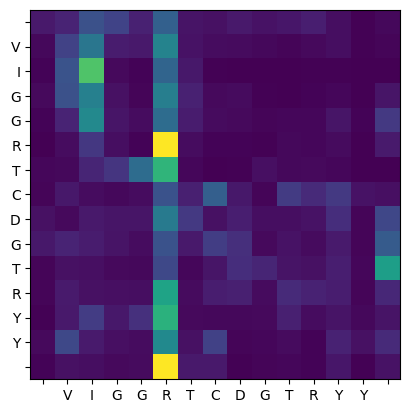

Layer 4, head 19


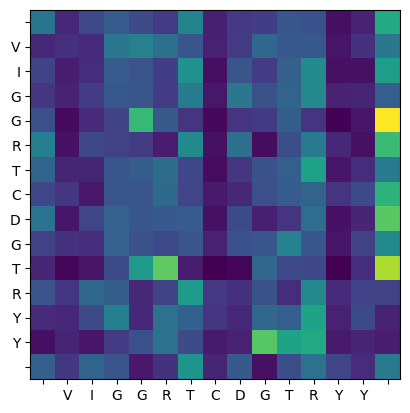

Layer 5, head 0


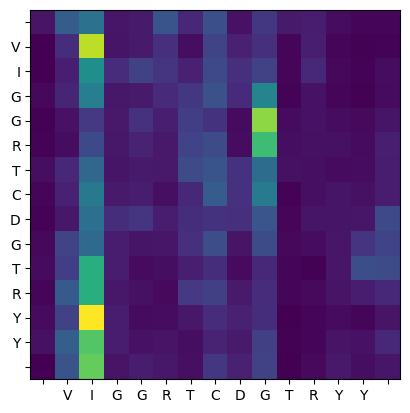

Layer 5, head 1


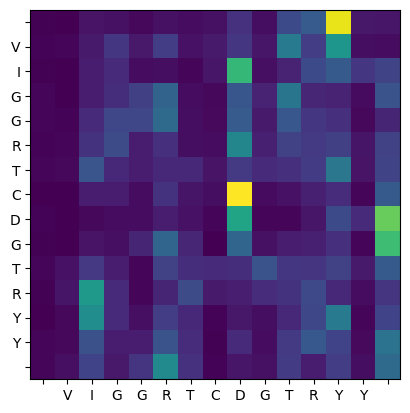

Layer 5, head 2


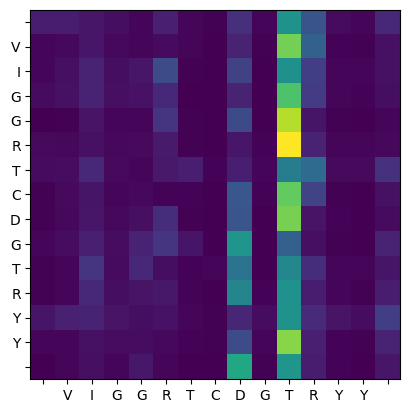

Layer 5, head 3


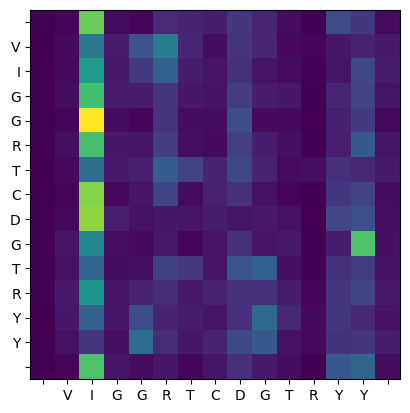

Layer 5, head 4


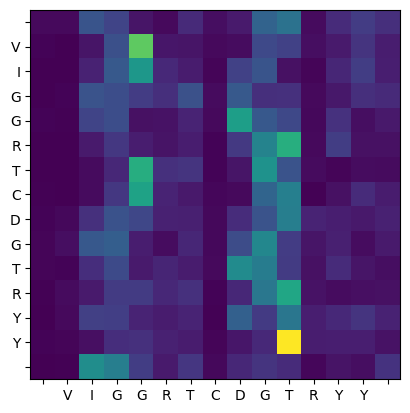

Layer 5, head 5


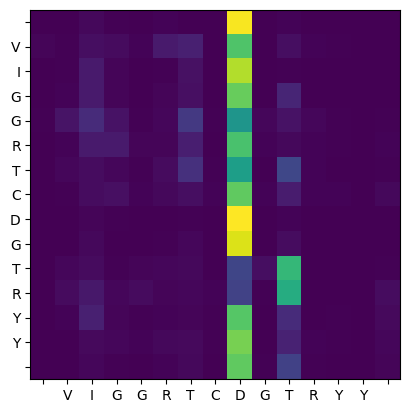

Layer 5, head 6


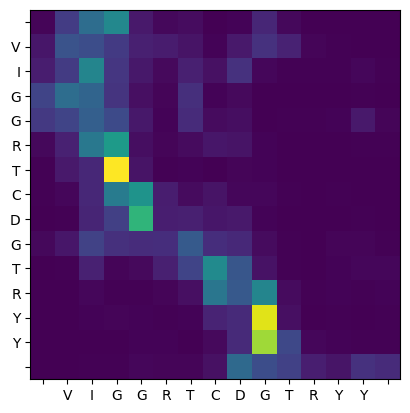

Layer 5, head 7


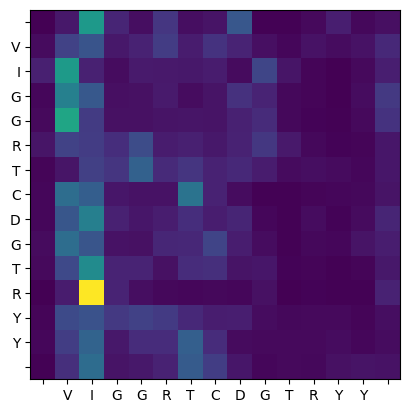

Layer 5, head 8


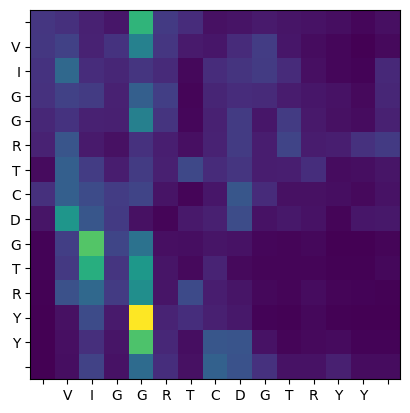

Layer 5, head 9


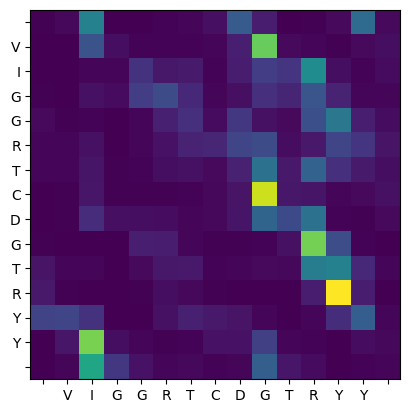

Layer 5, head 10


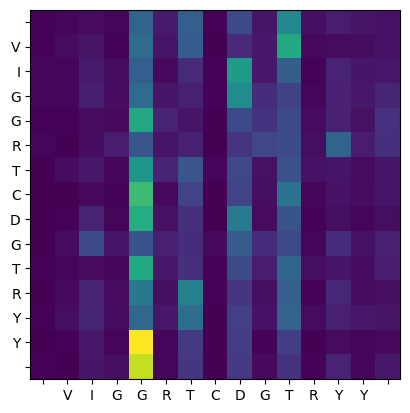

Layer 5, head 11


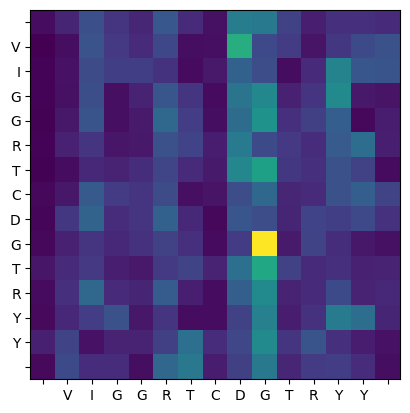

Layer 5, head 12


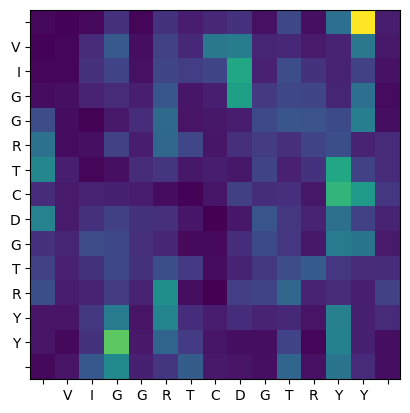

Layer 5, head 13


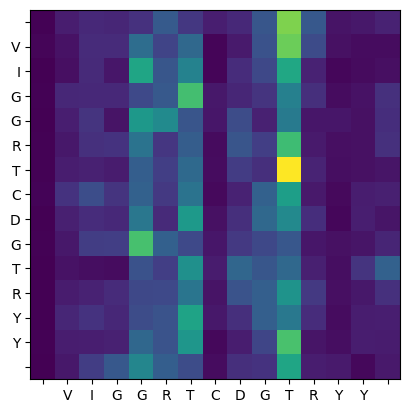

Layer 5, head 14


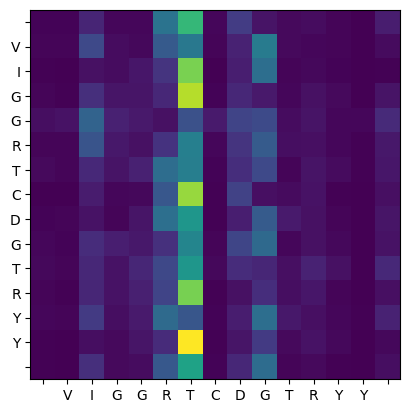

Layer 5, head 15


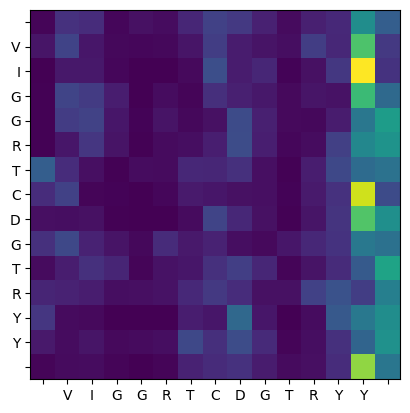

Layer 5, head 16


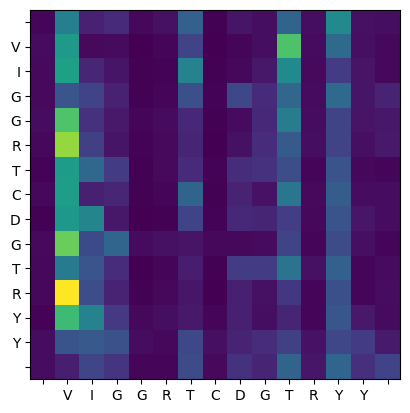

Layer 5, head 17


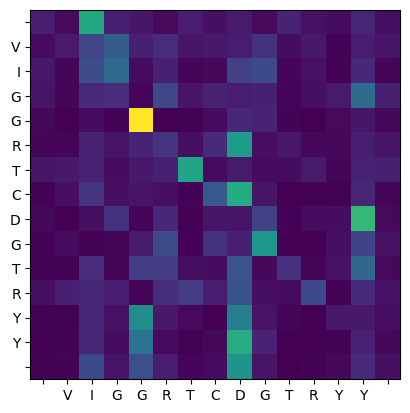

Layer 5, head 18


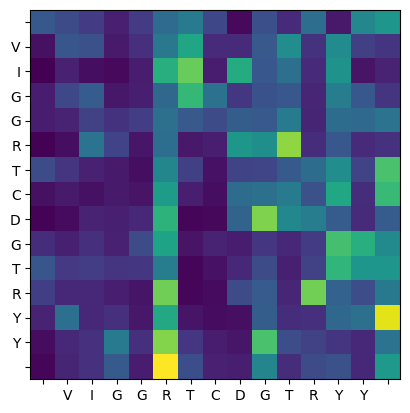

Layer 5, head 19


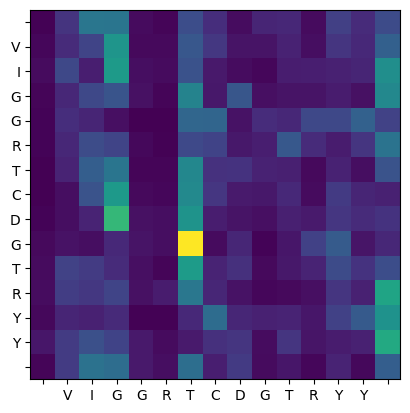

Layer 6, head 0


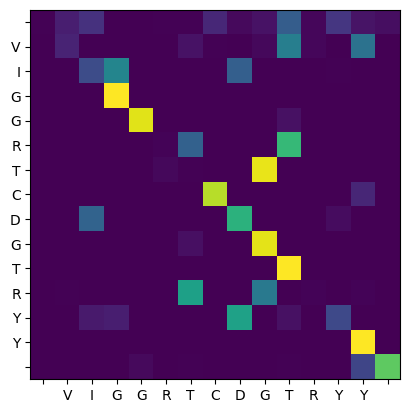

Layer 6, head 1


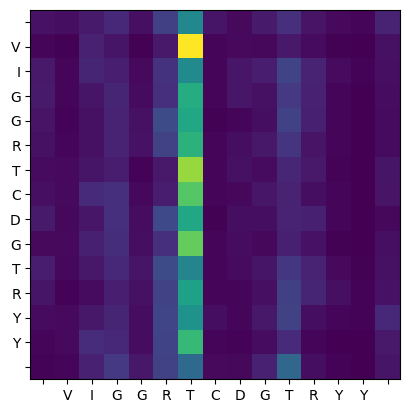

Layer 6, head 2


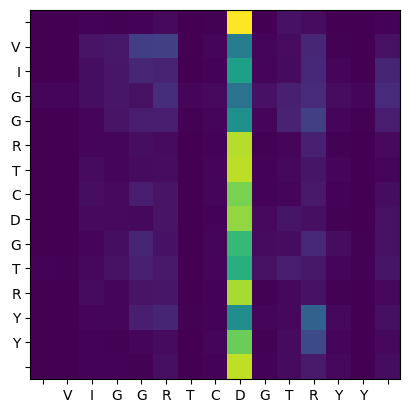

Layer 6, head 3


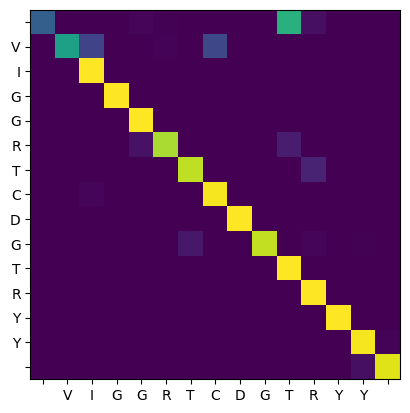

Layer 6, head 4


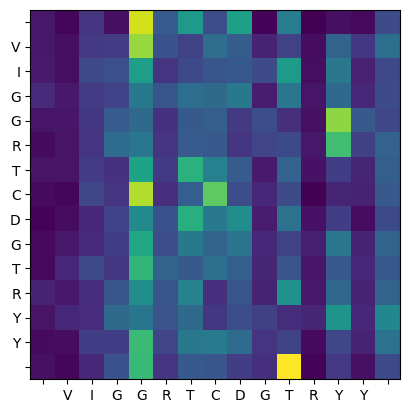

Layer 6, head 5


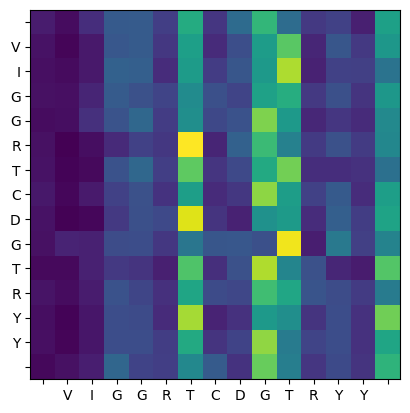

Layer 6, head 6


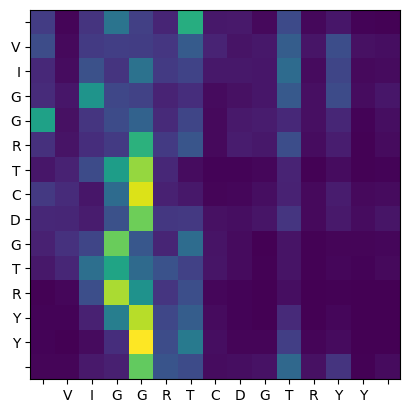

Layer 6, head 7


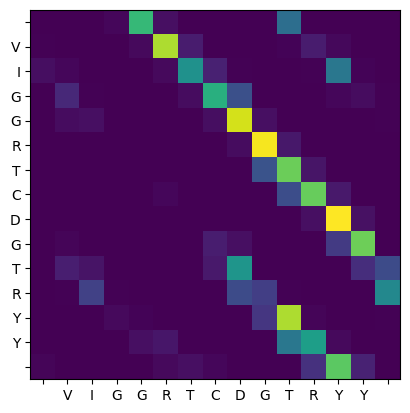

Layer 6, head 8


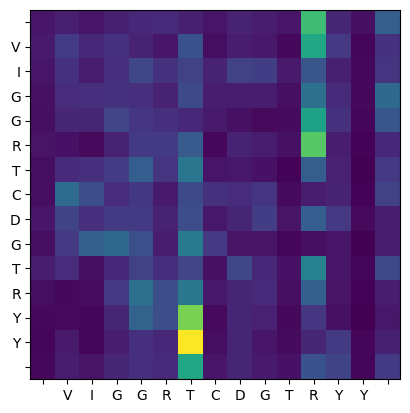

Layer 6, head 9


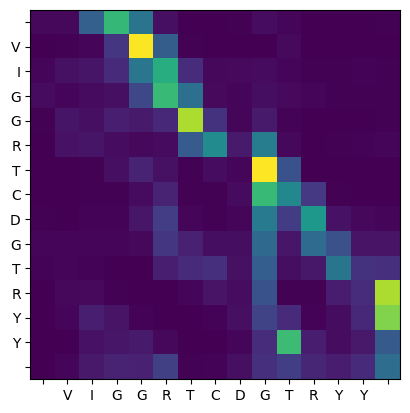

Layer 6, head 10


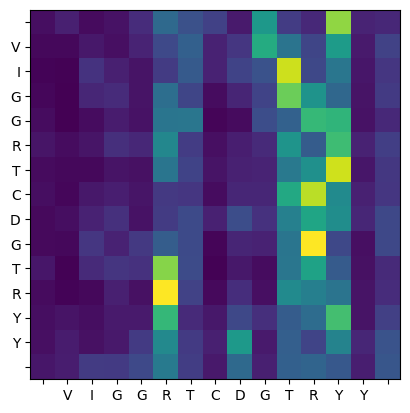

Layer 6, head 11


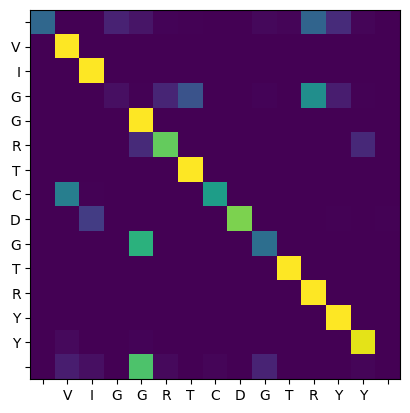

Layer 6, head 12


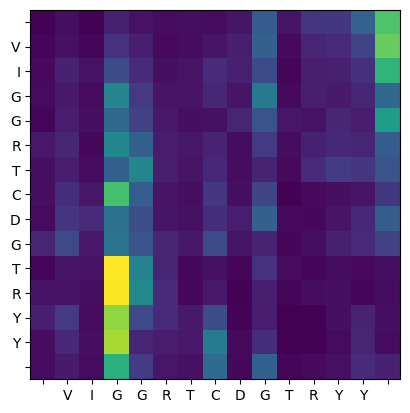

Layer 6, head 13


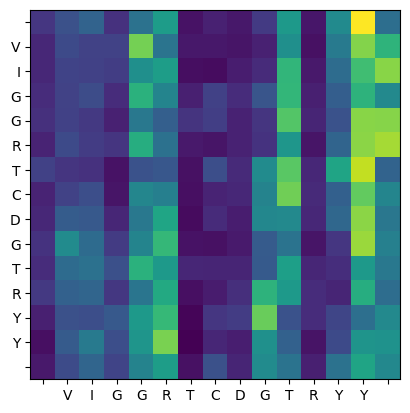

Layer 6, head 14


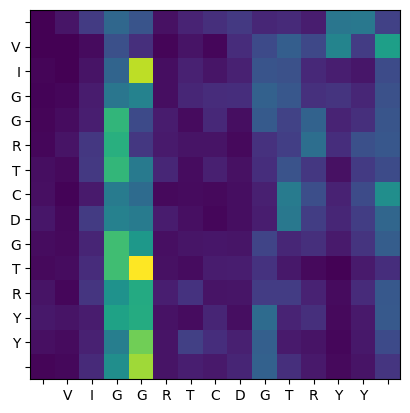

Layer 6, head 15


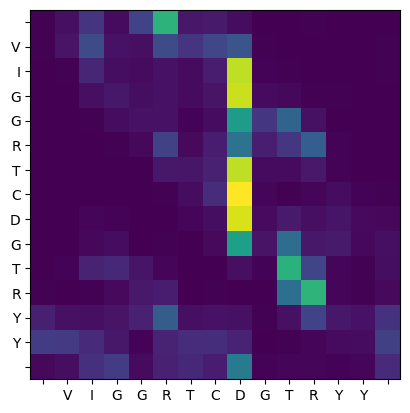

Layer 6, head 16


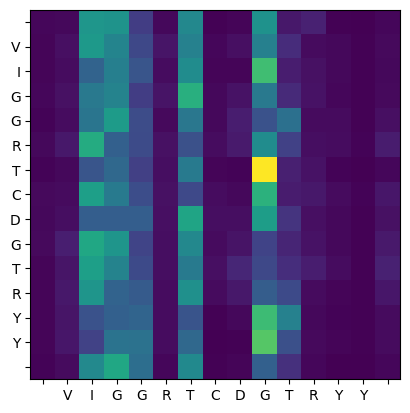

Layer 6, head 17


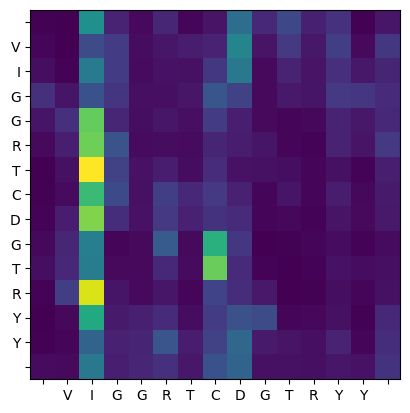

Layer 6, head 18


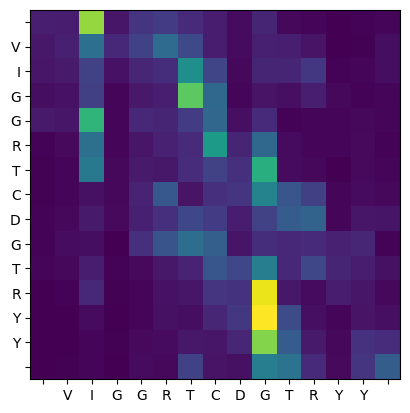

Layer 6, head 19


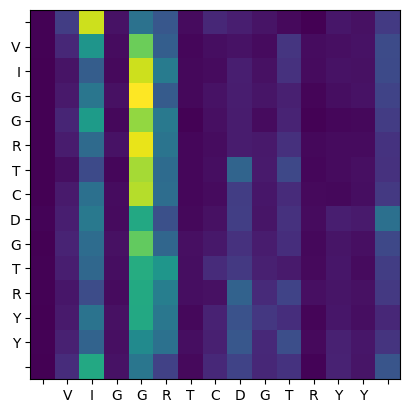

Layer 7, head 0


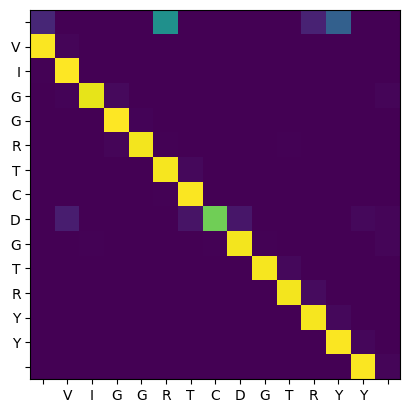

Layer 7, head 1


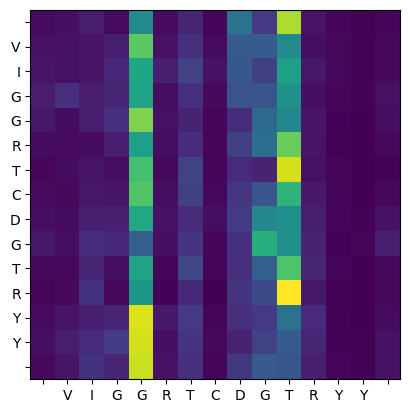

Layer 7, head 2


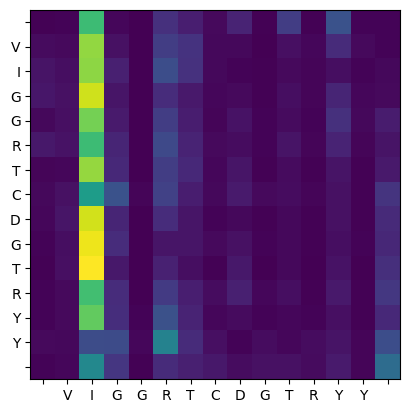

Layer 7, head 3


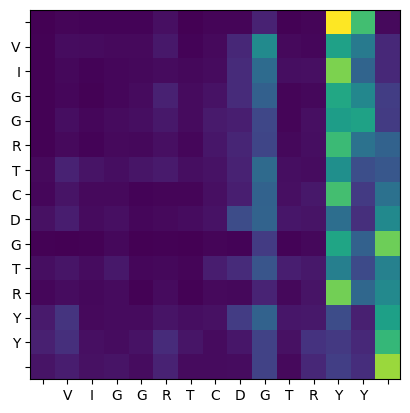

Layer 7, head 4


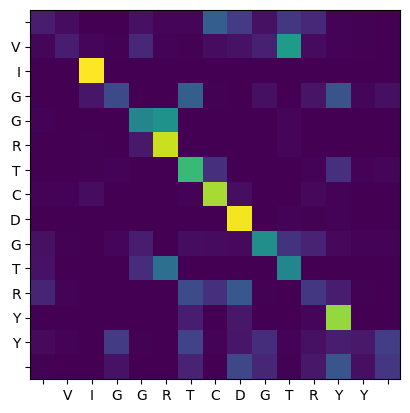

Layer 7, head 5


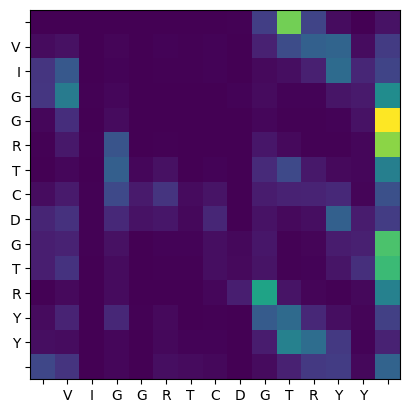

Layer 7, head 6


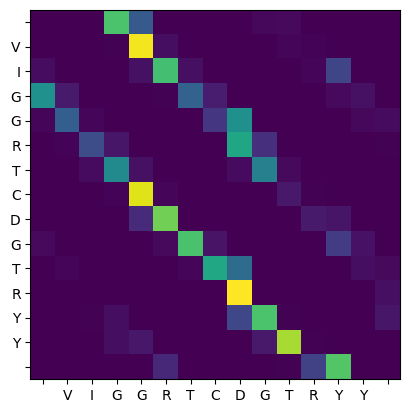

Layer 7, head 7


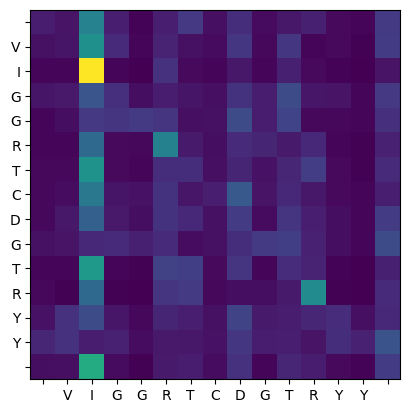

Layer 7, head 8


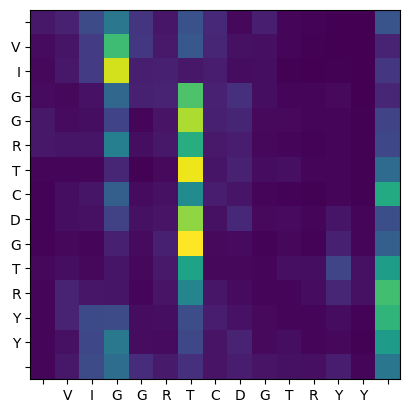

Layer 7, head 9


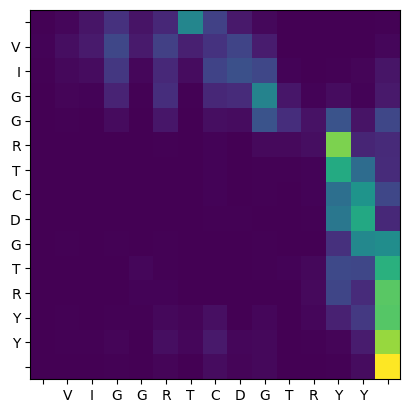

Layer 7, head 10


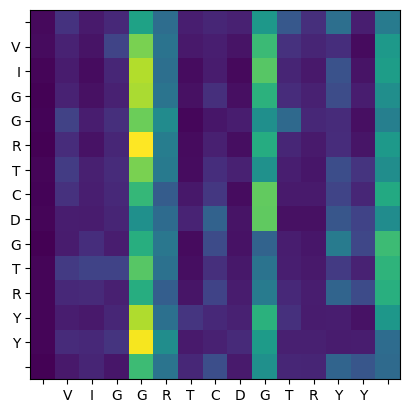

Layer 7, head 11


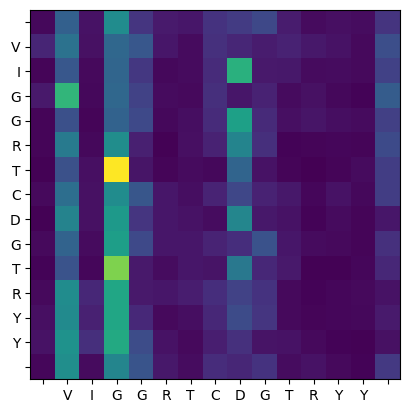

Layer 7, head 12


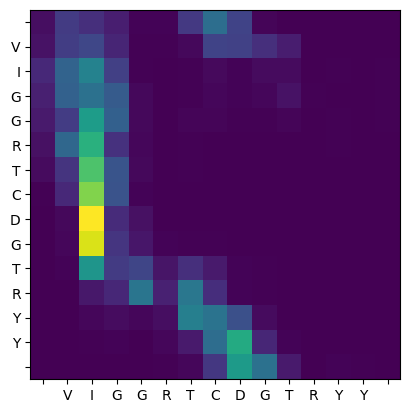

Layer 7, head 13


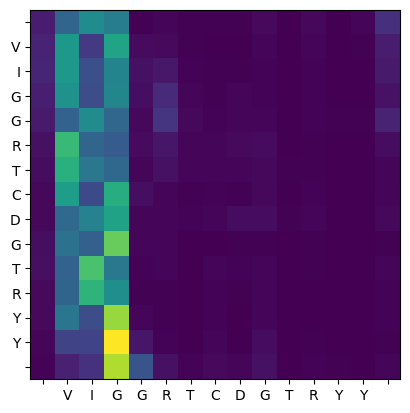

Layer 7, head 14


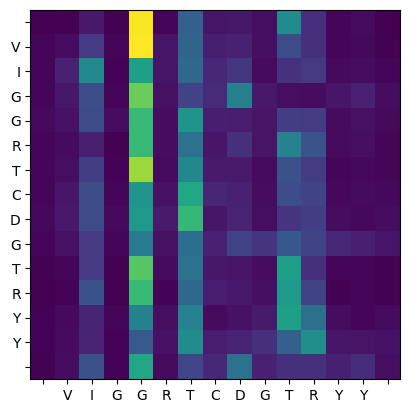

Layer 7, head 15


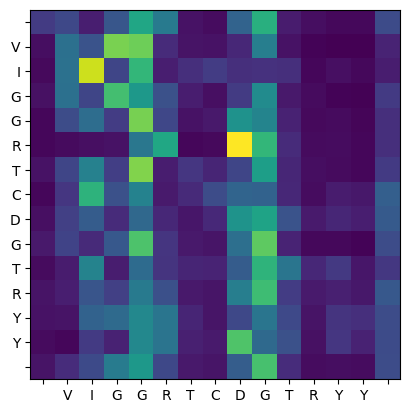

Layer 7, head 16


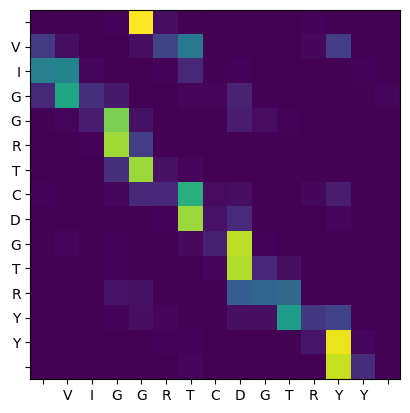

Layer 7, head 17


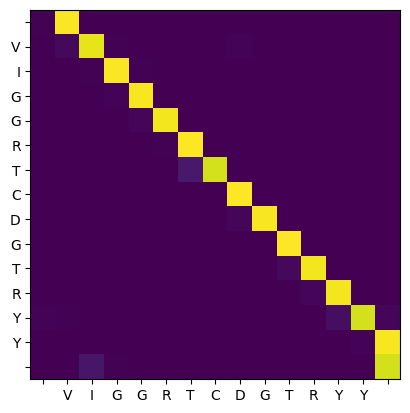

Layer 7, head 18


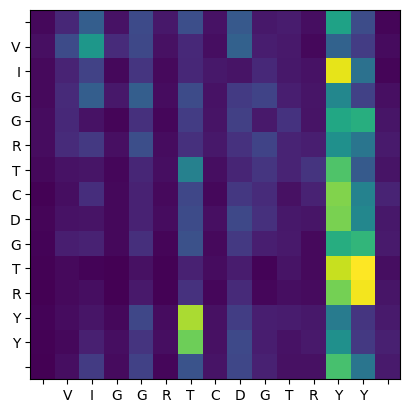

Layer 7, head 19


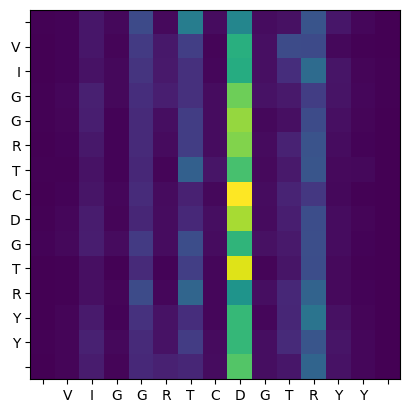

Layer 8, head 0


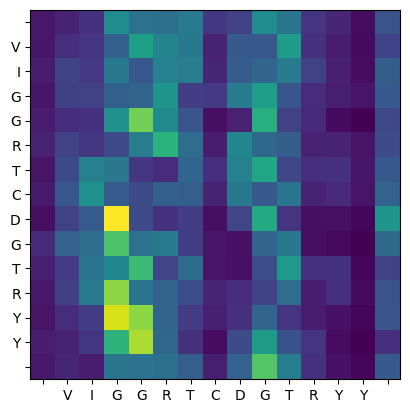

Layer 8, head 1


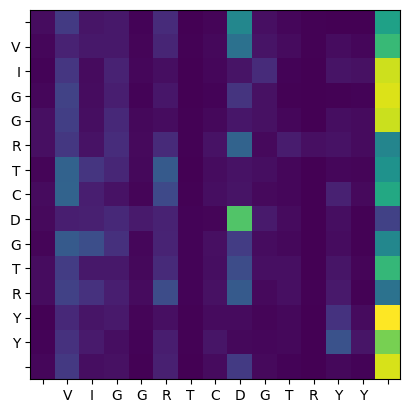

Layer 8, head 2


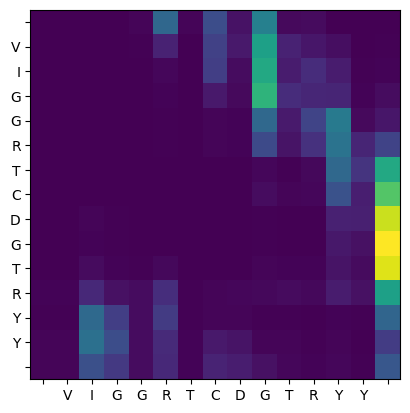

Layer 8, head 3


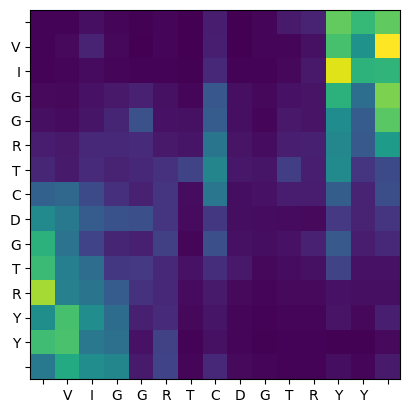

Layer 8, head 4


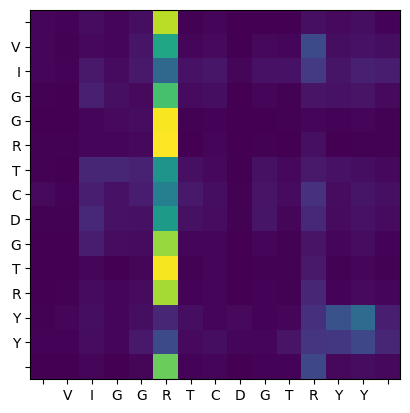

Layer 8, head 5


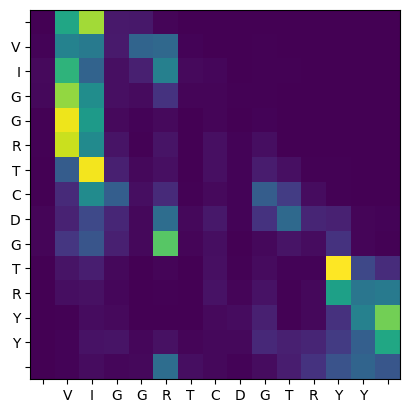

Layer 8, head 6


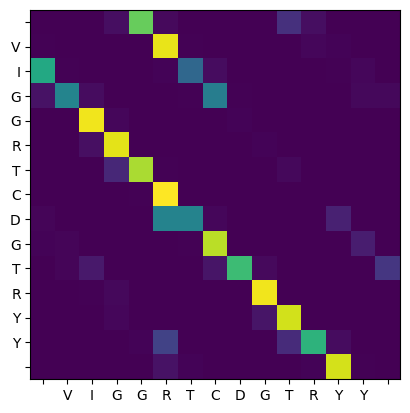

Layer 8, head 7


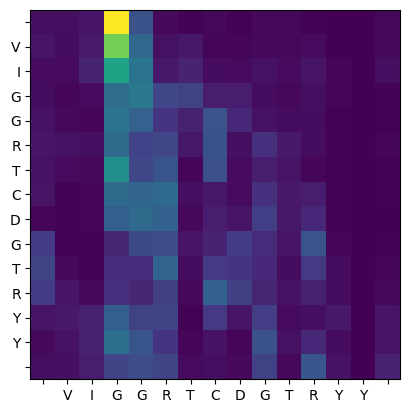

Layer 8, head 8


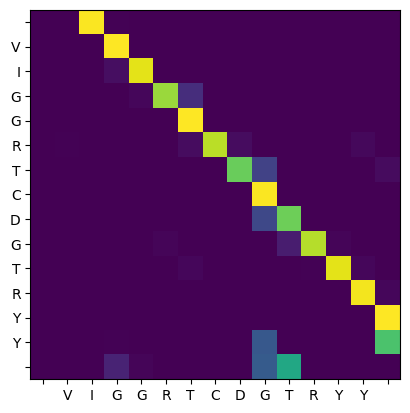

Layer 8, head 9


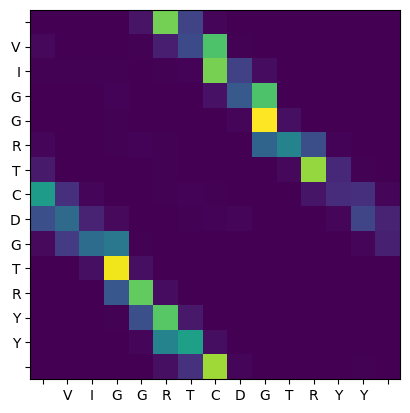

Layer 8, head 10


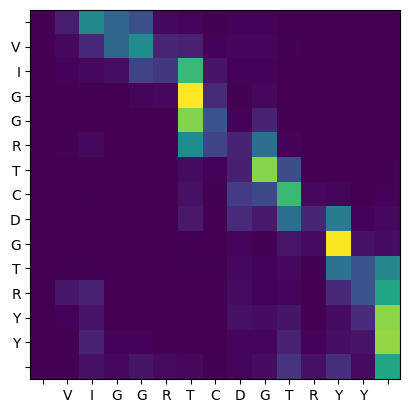

Layer 8, head 11


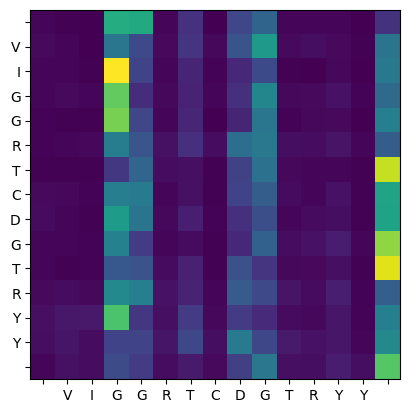

Layer 8, head 12


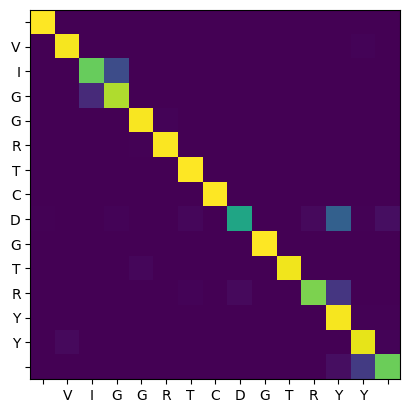

Layer 8, head 13


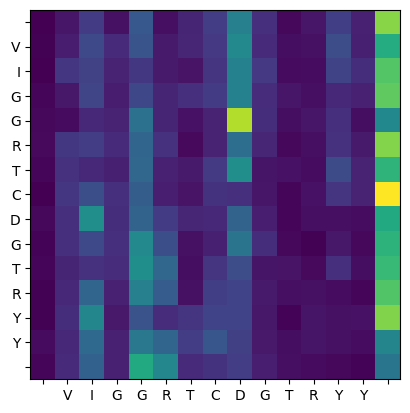

Layer 8, head 14


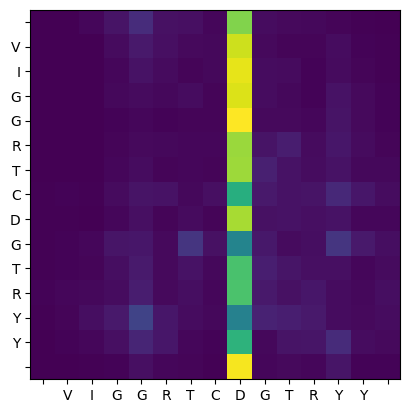

Layer 8, head 15


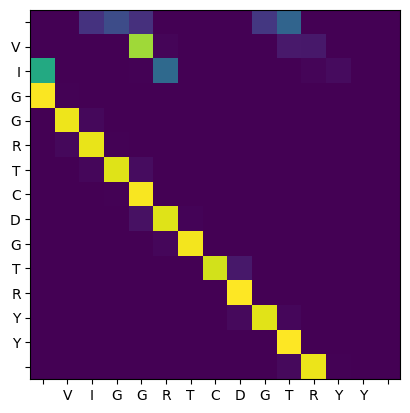

Layer 8, head 16


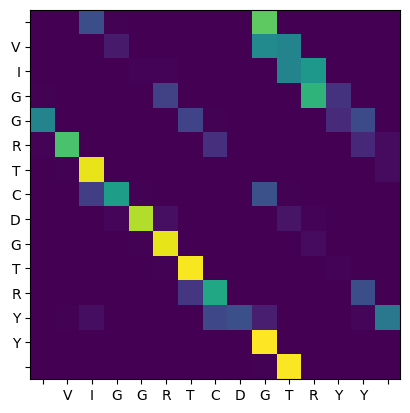

Layer 8, head 17


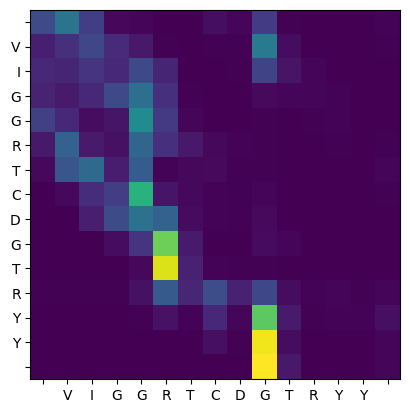

Layer 8, head 18


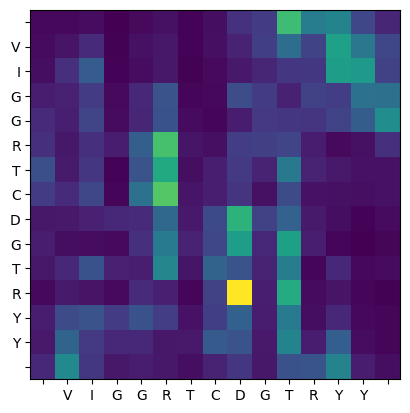

Layer 8, head 19


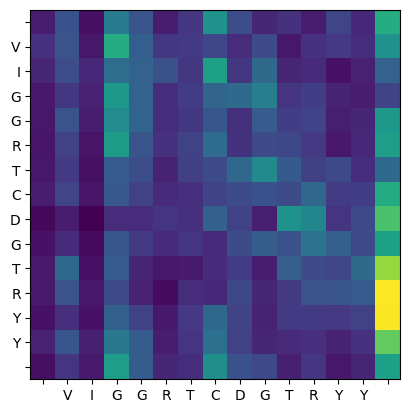

Layer 9, head 0


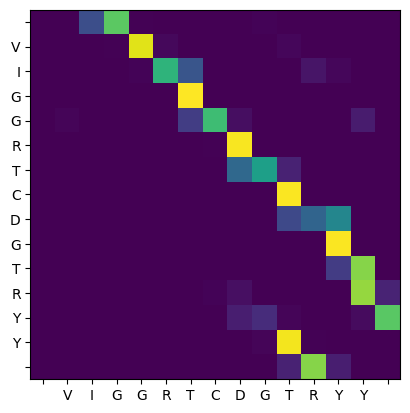

Layer 9, head 1


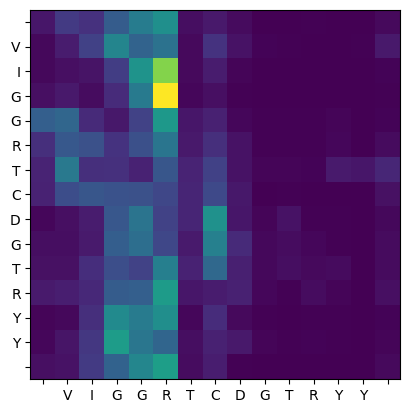

Layer 9, head 2


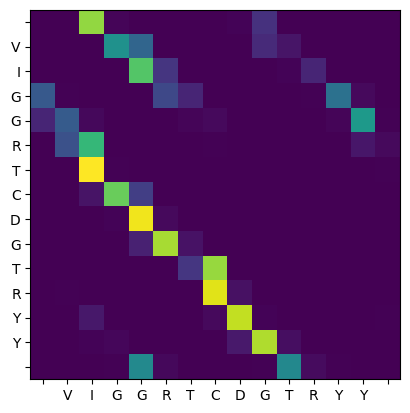

Layer 9, head 3


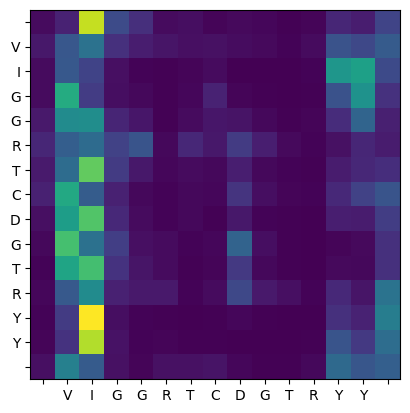

Layer 9, head 4


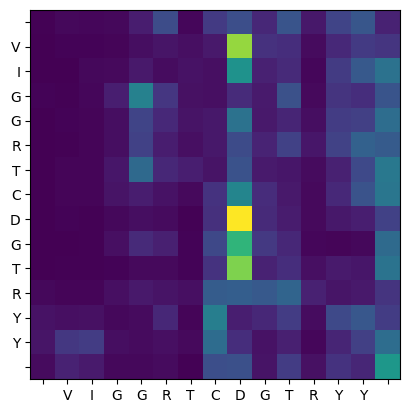

Layer 9, head 5


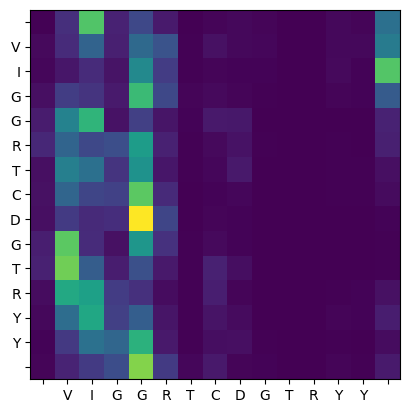

Layer 9, head 6


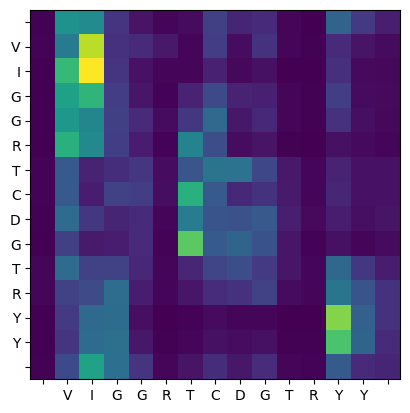

Layer 9, head 7


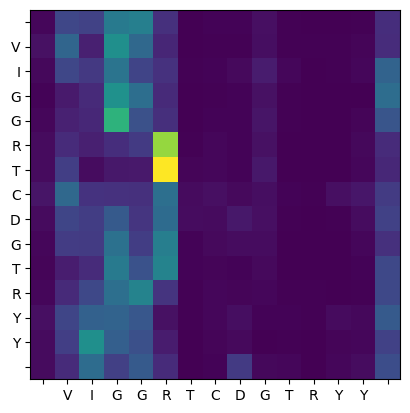

Layer 9, head 8


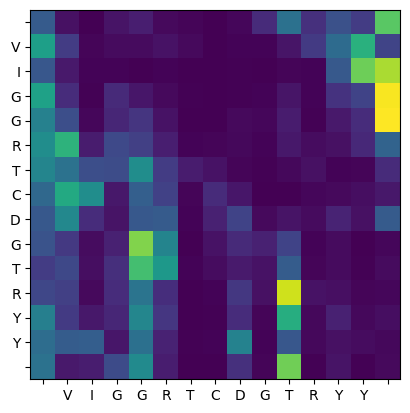

Layer 9, head 9


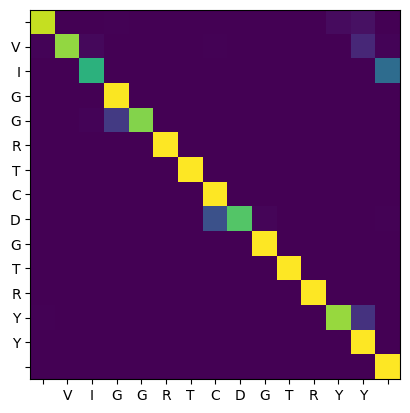

Layer 9, head 10


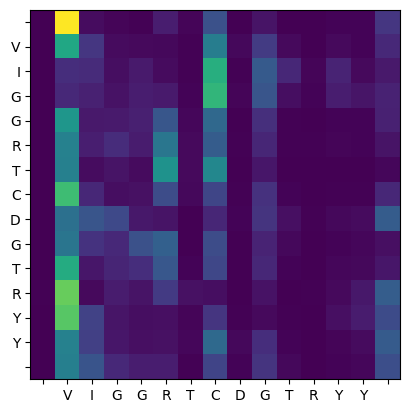

Layer 9, head 11


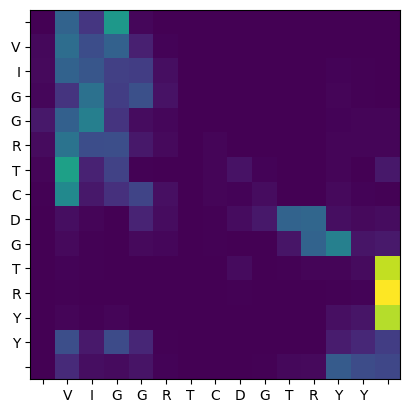

Layer 9, head 12


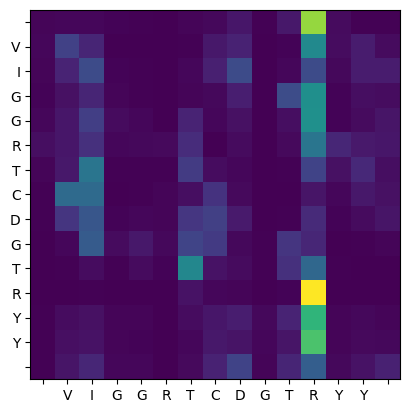

Layer 9, head 13


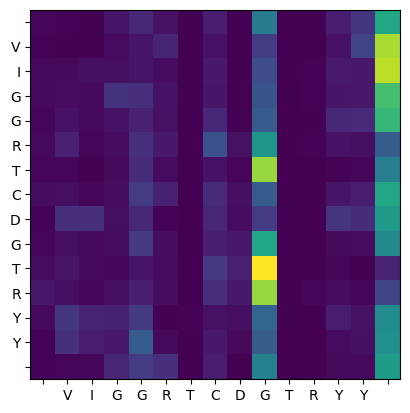

Layer 9, head 14


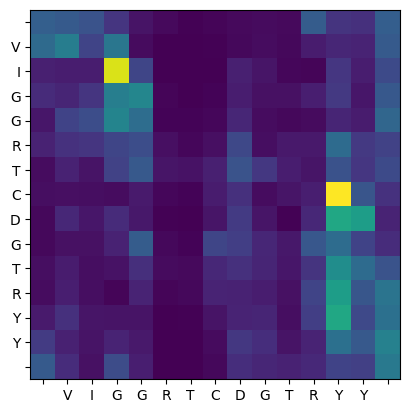

Layer 9, head 15


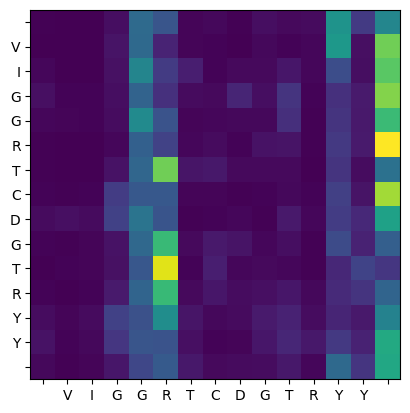

Layer 9, head 16


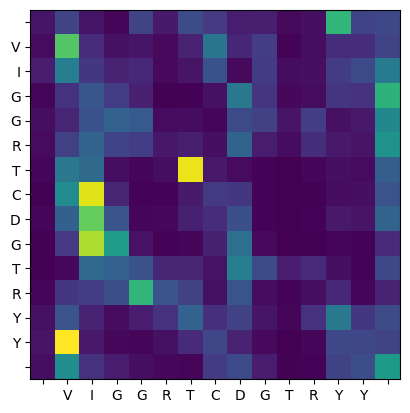

Layer 9, head 17


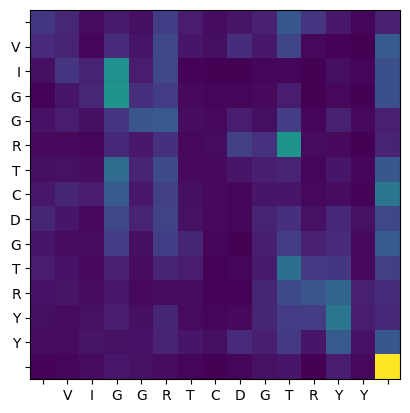

Layer 9, head 18


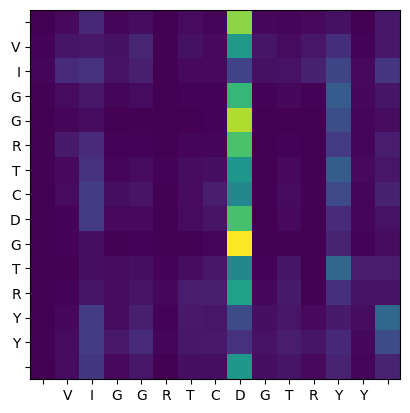

Layer 9, head 19


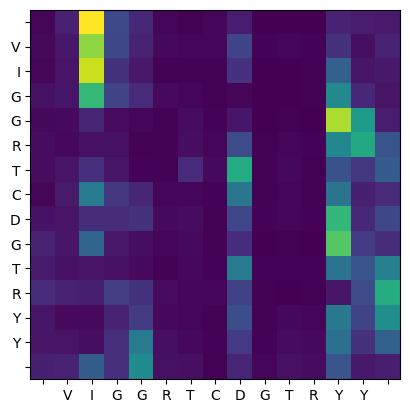

Layer 10, head 0


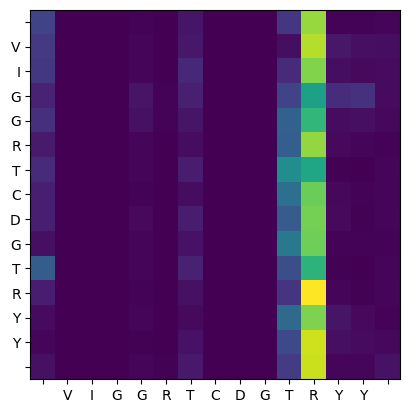

Layer 10, head 1


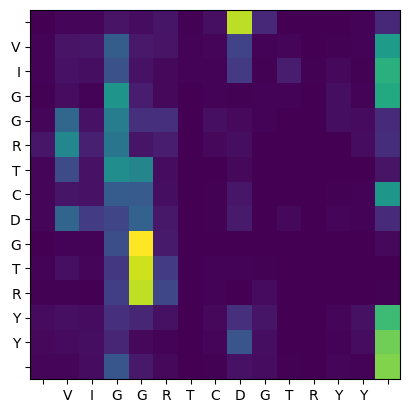

Layer 10, head 2


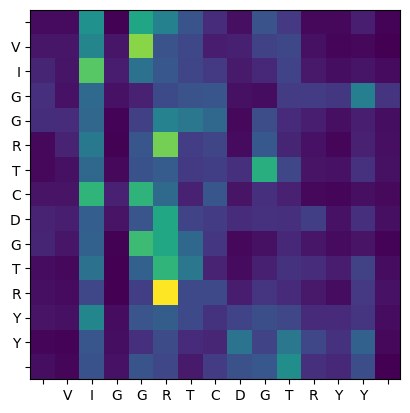

Layer 10, head 3


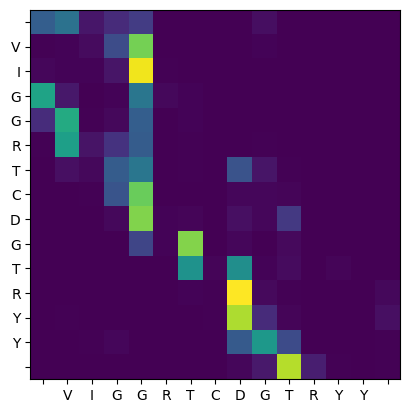

Layer 10, head 4


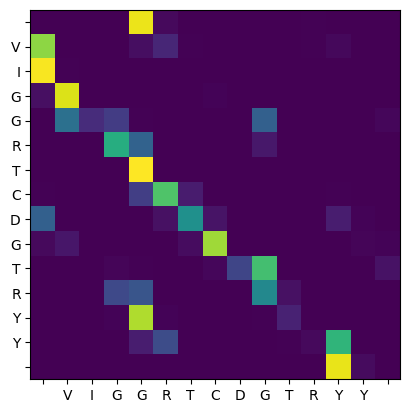

Layer 10, head 5


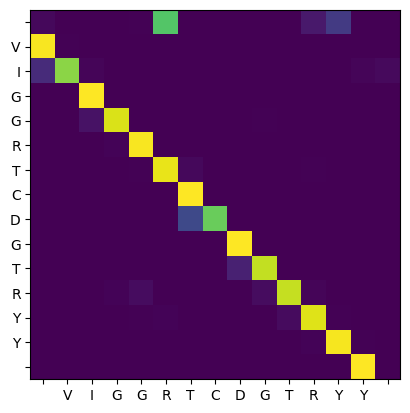

Layer 10, head 6


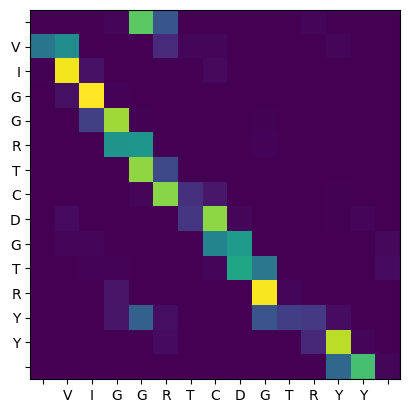

Layer 10, head 7


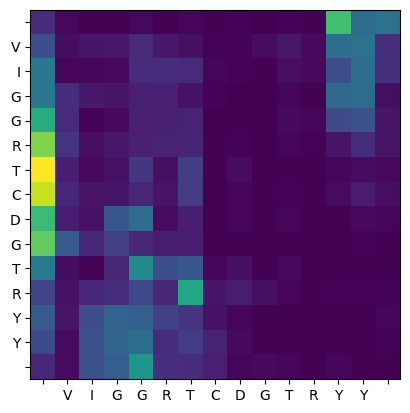

Layer 10, head 8


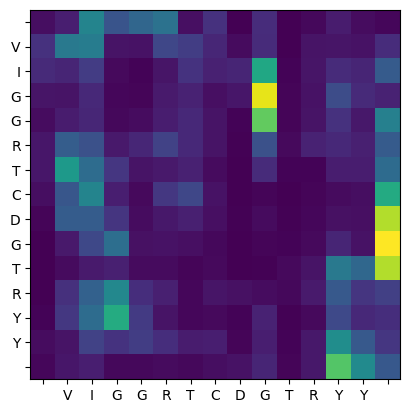

Layer 10, head 9


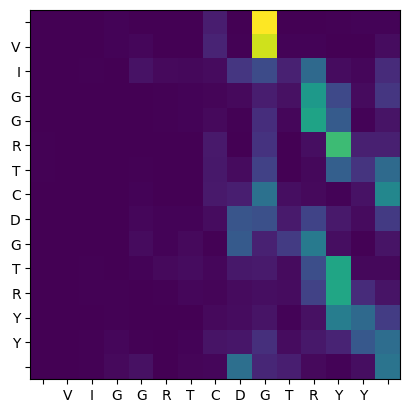

Layer 10, head 10


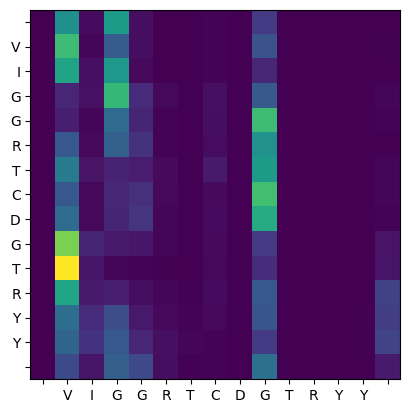

Layer 10, head 11


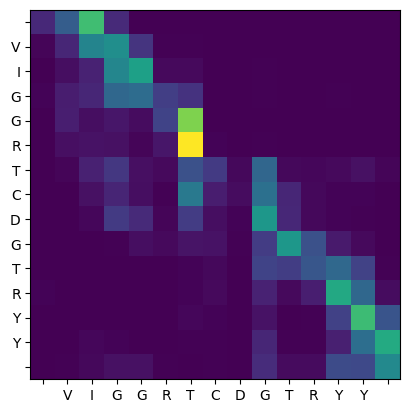

Layer 10, head 12


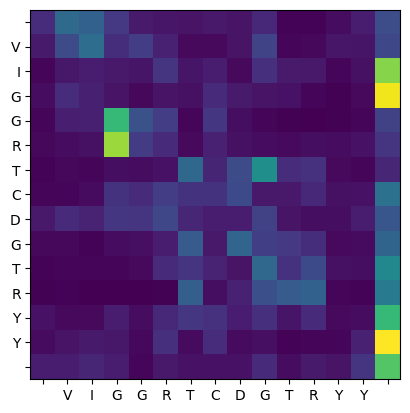

Layer 10, head 13


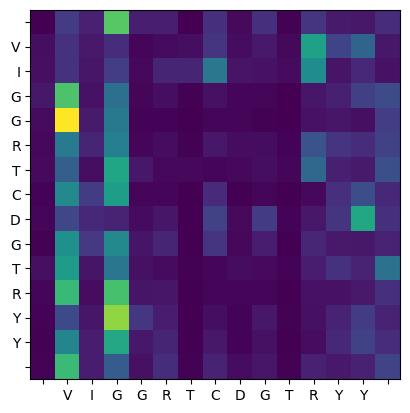

Layer 10, head 14


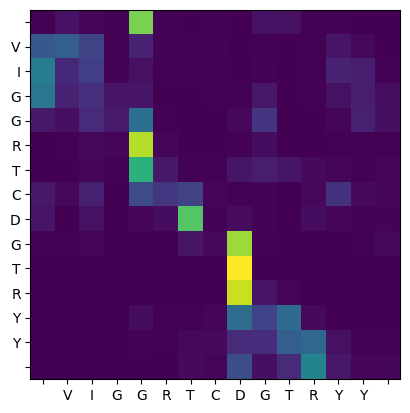

Layer 10, head 15


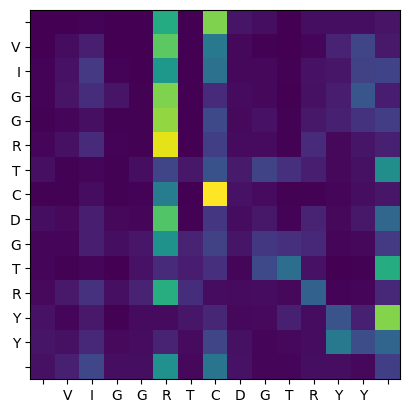

Layer 10, head 16


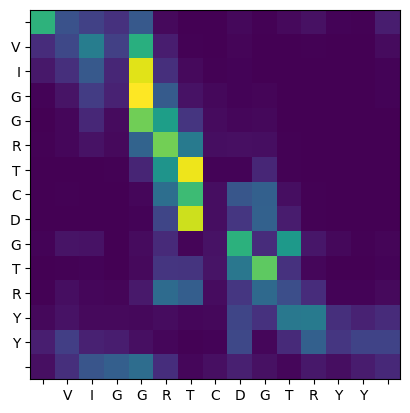

Layer 10, head 17


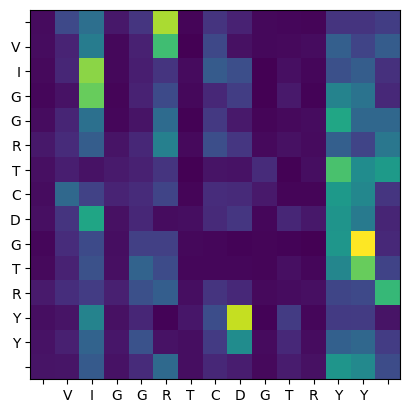

Layer 10, head 18


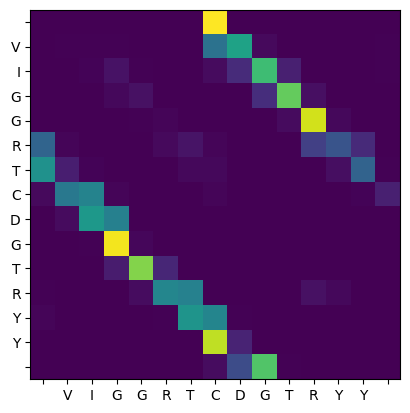

Layer 10, head 19


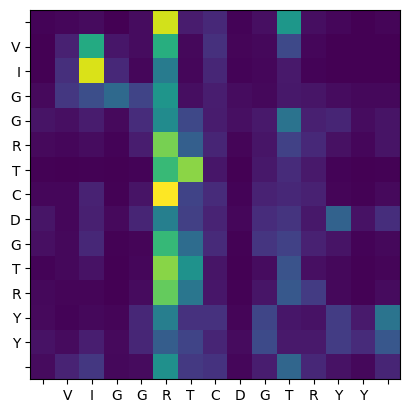

Layer 11, head 0


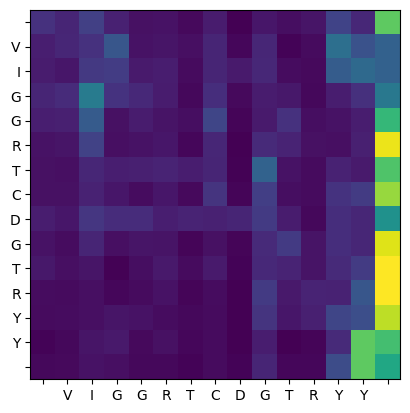

Layer 11, head 1


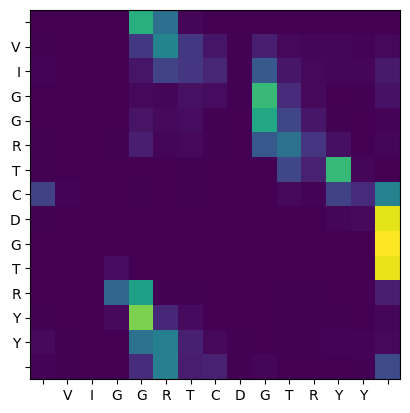

Layer 11, head 2


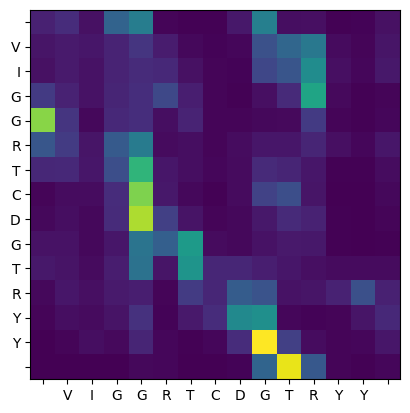

Layer 11, head 3


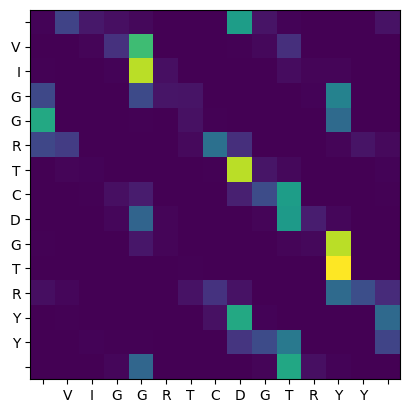

Layer 11, head 4


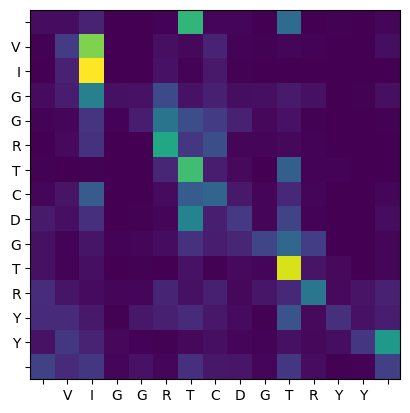

Layer 11, head 5


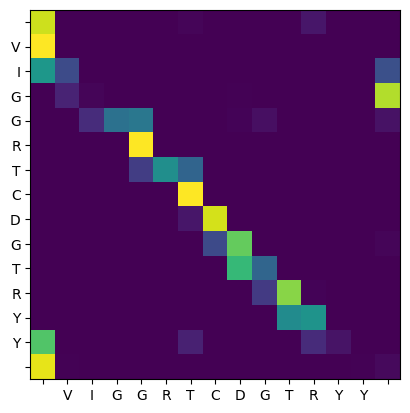

Layer 11, head 6


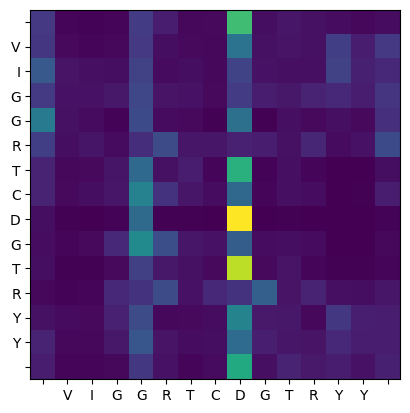

Layer 11, head 7


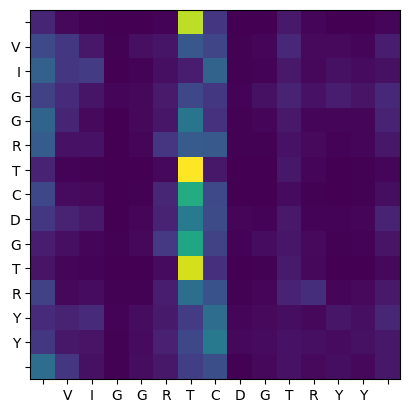

Layer 11, head 8


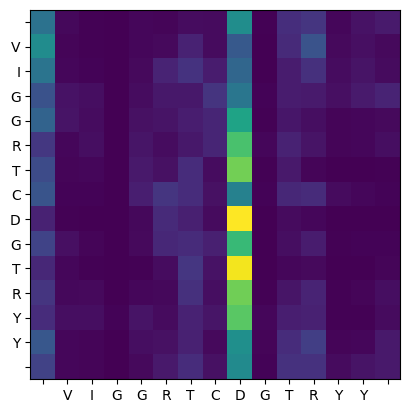

Layer 11, head 9


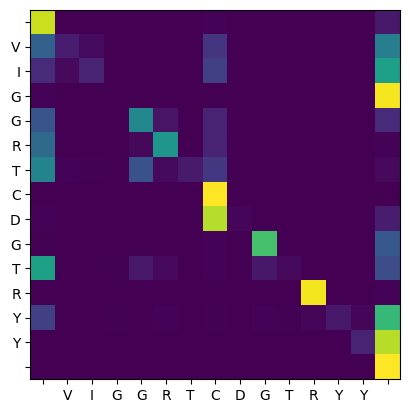

Layer 11, head 10


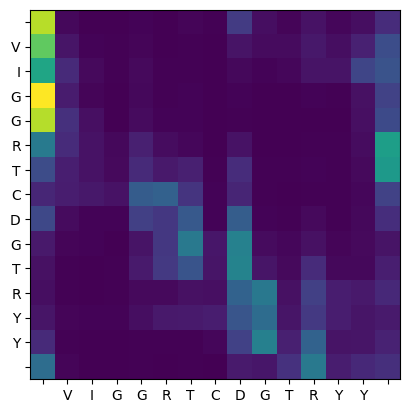

Layer 11, head 11


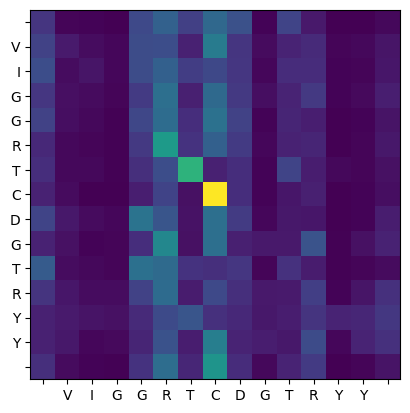

Layer 11, head 12


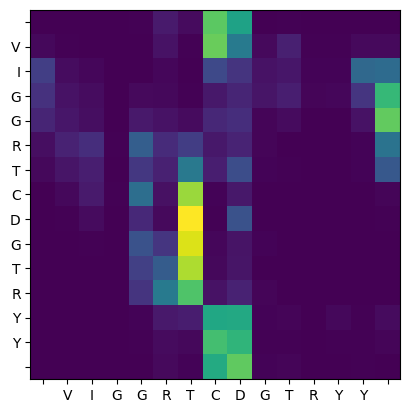

Layer 11, head 13


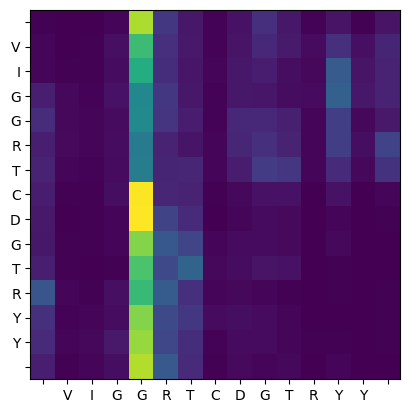

Layer 11, head 14


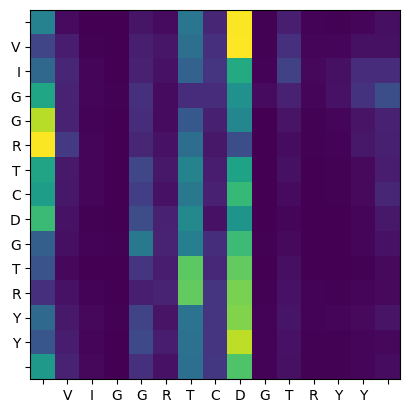

Layer 11, head 15


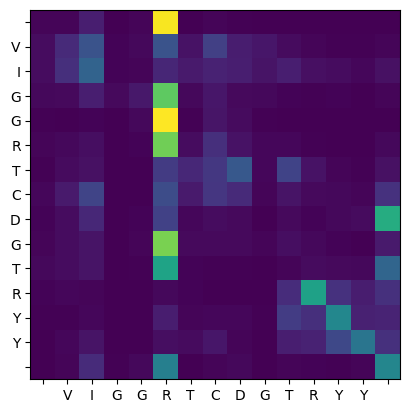

Layer 11, head 16


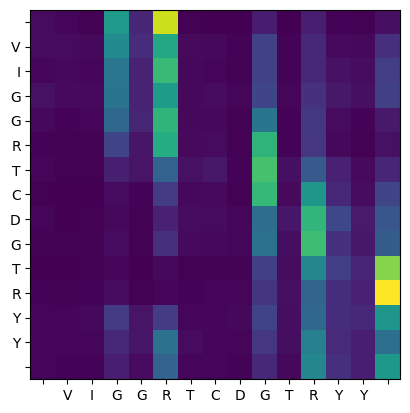

Layer 11, head 17


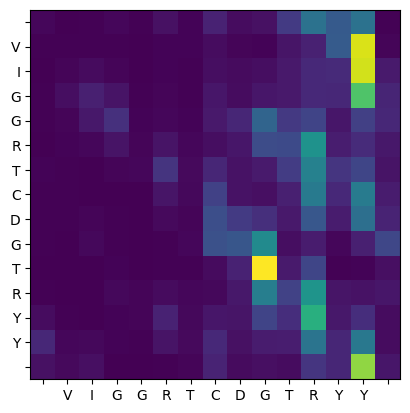

Layer 11, head 18


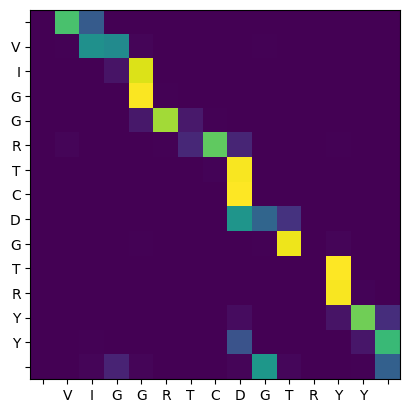

Layer 11, head 19


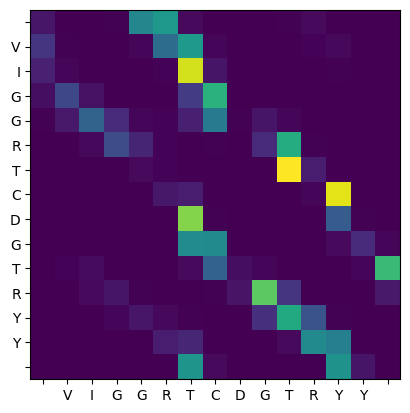

In [20]:
full_attention(LazBF_model, 'VIGGRTCDGTRYY')

Layer 0, head 0


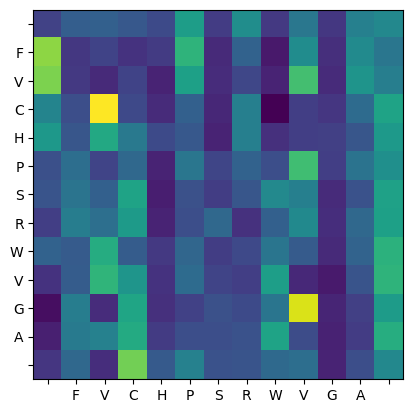

Layer 0, head 1


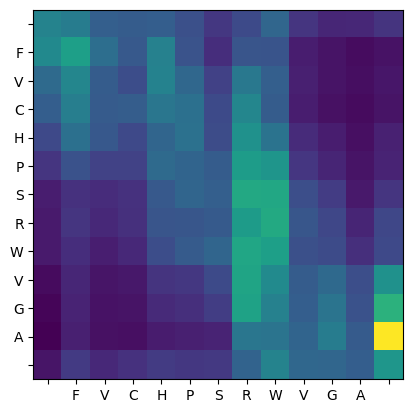

Layer 0, head 2


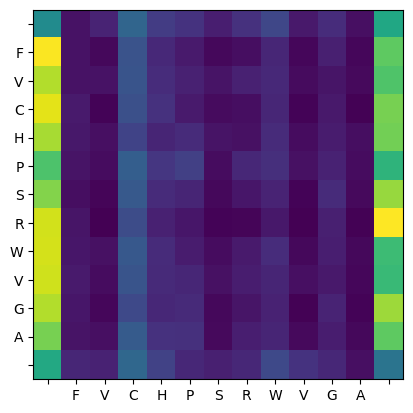

Layer 0, head 3


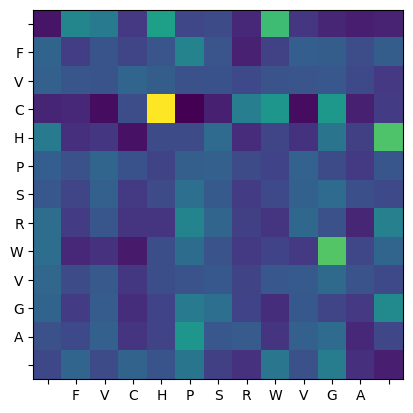

Layer 0, head 4


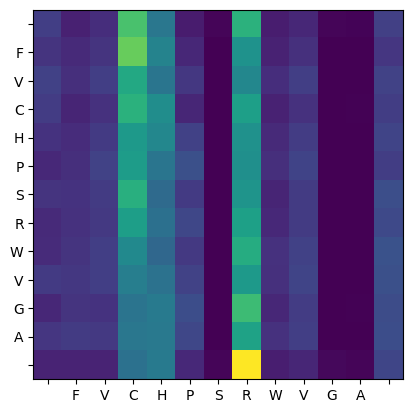

Layer 0, head 5


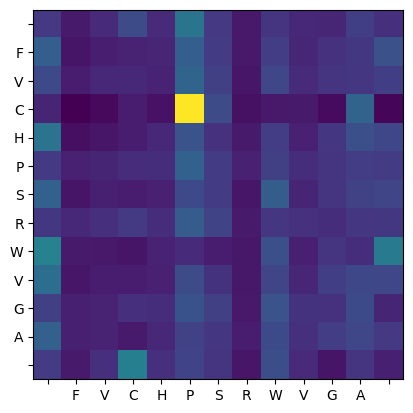

Layer 0, head 6


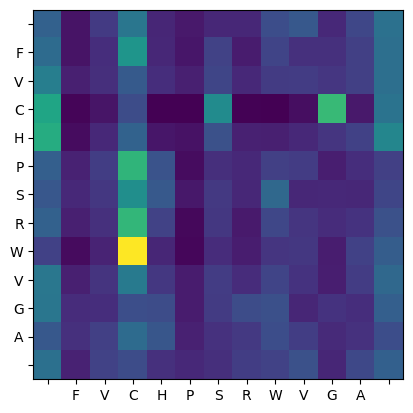

Layer 0, head 7


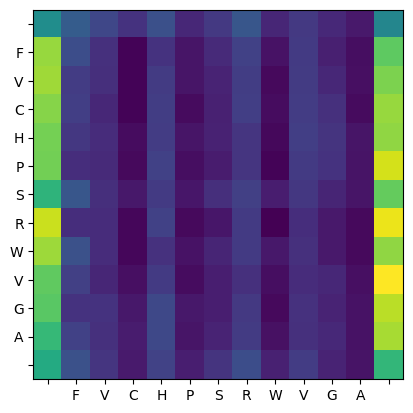

Layer 0, head 8


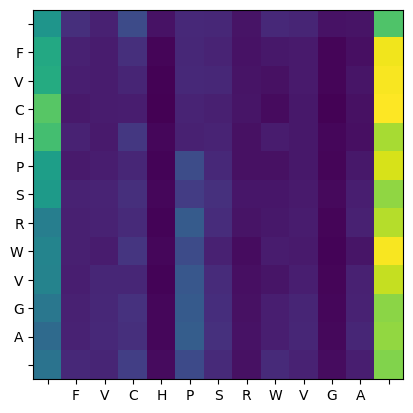

Layer 0, head 9


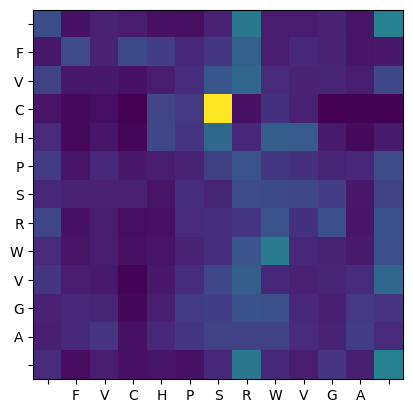

Layer 0, head 10


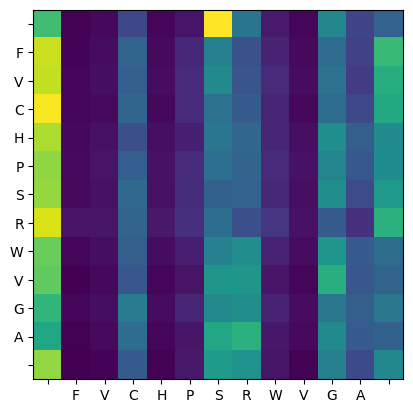

Layer 0, head 11


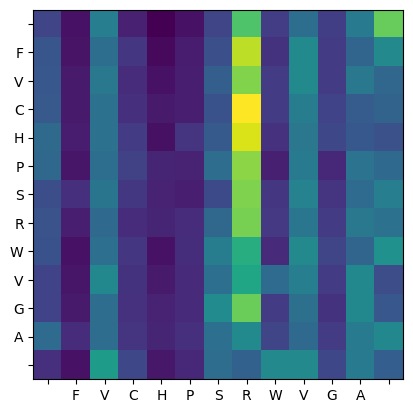

Layer 0, head 12


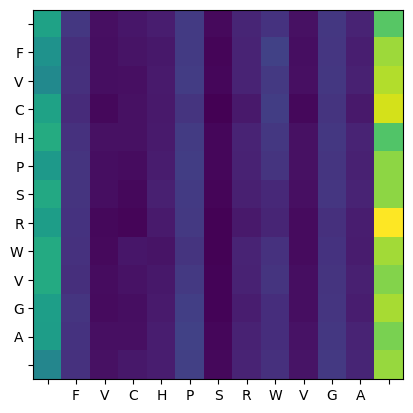

Layer 0, head 13


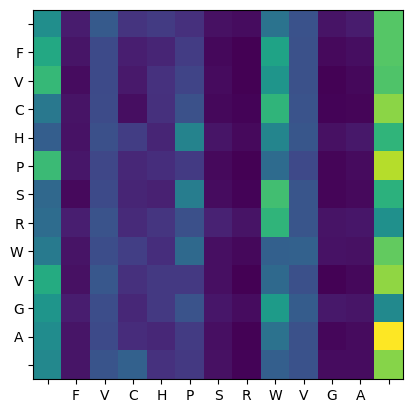

Layer 0, head 14


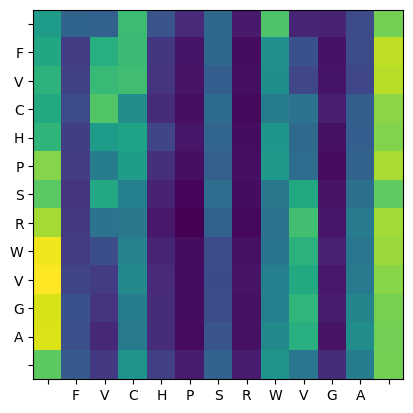

Layer 0, head 15


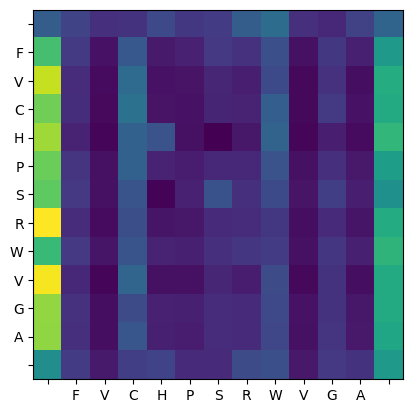

Layer 0, head 16


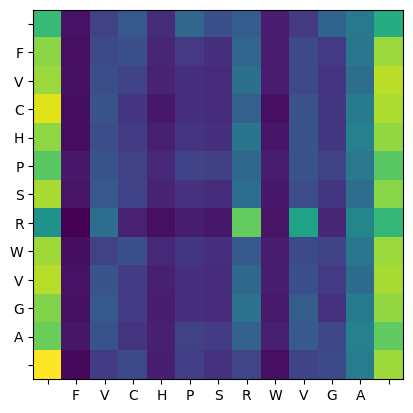

Layer 0, head 17


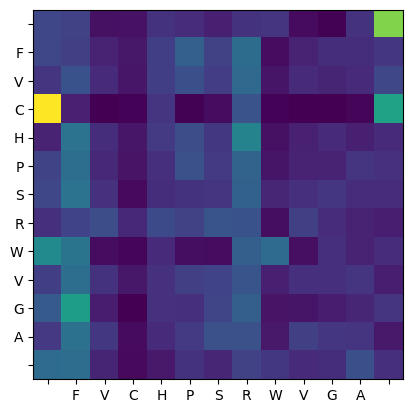

Layer 0, head 18


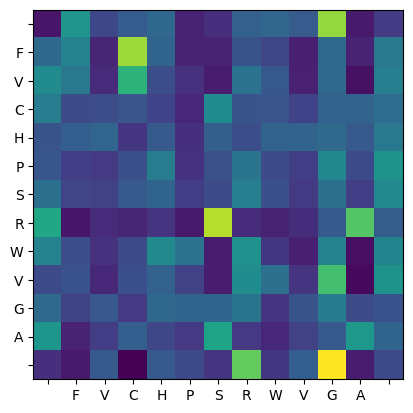

Layer 0, head 19


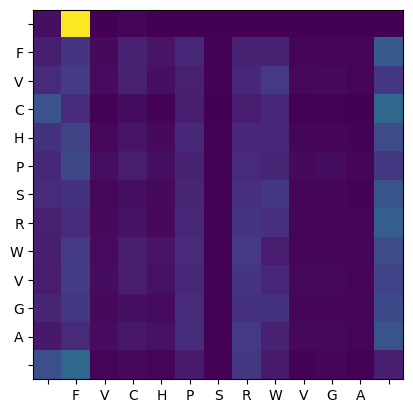

Layer 1, head 0


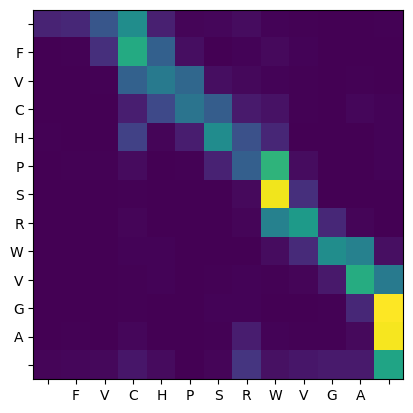

Layer 1, head 1


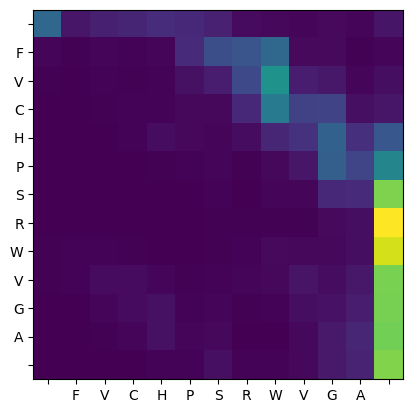

Layer 1, head 2


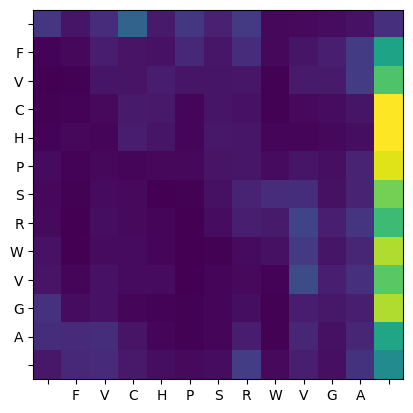

Layer 1, head 3


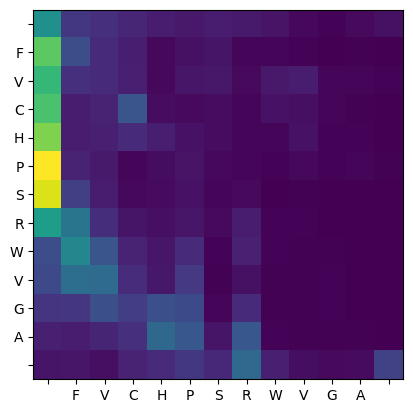

Layer 1, head 4


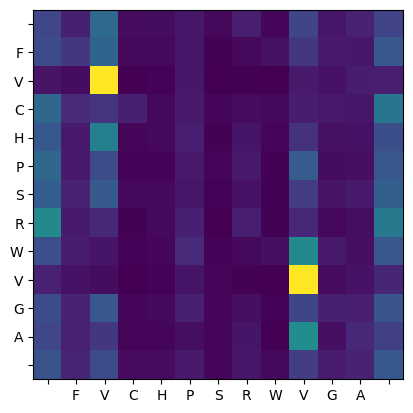

Layer 1, head 5


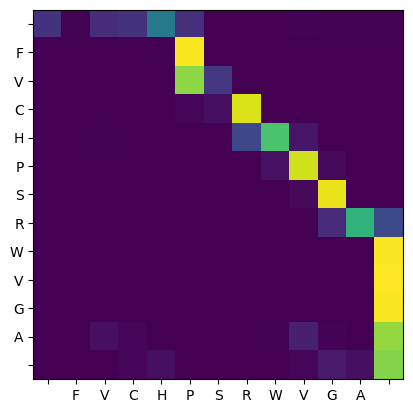

Layer 1, head 6


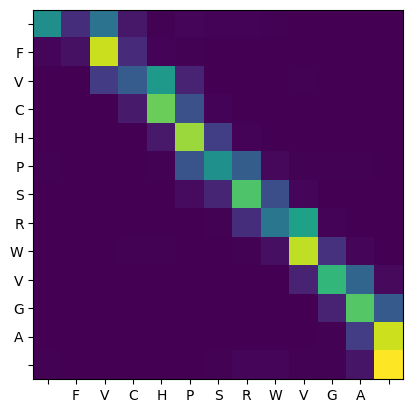

Layer 1, head 7


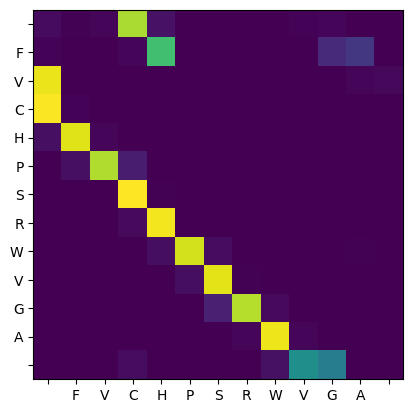

Layer 1, head 8


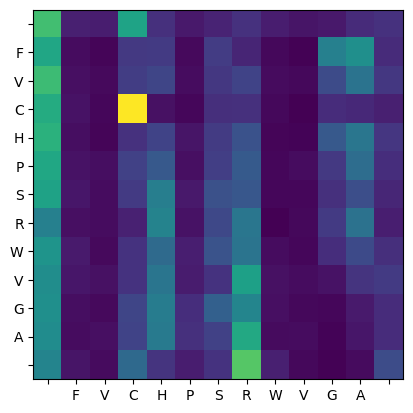

Layer 1, head 9


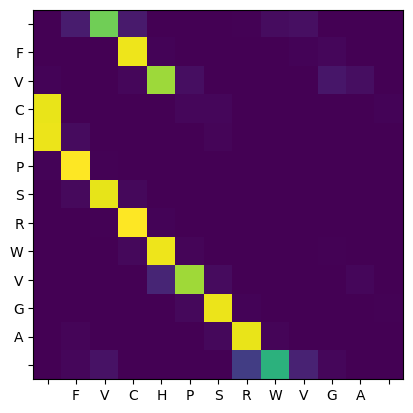

Layer 1, head 10


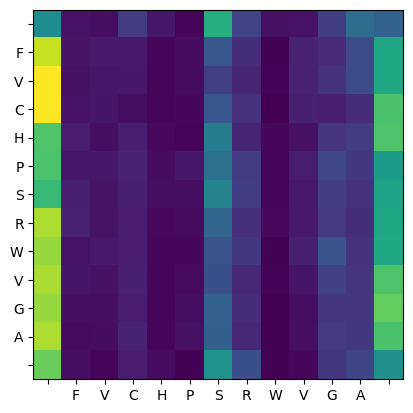

Layer 1, head 11


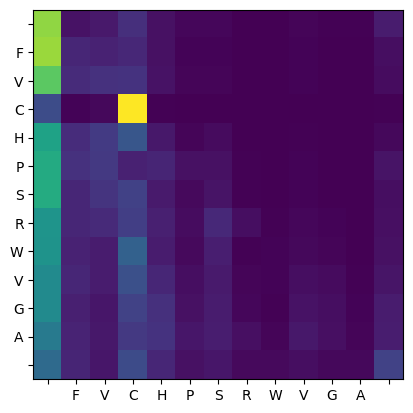

Layer 1, head 12


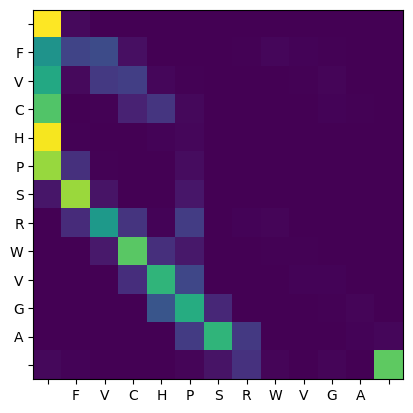

Layer 1, head 13


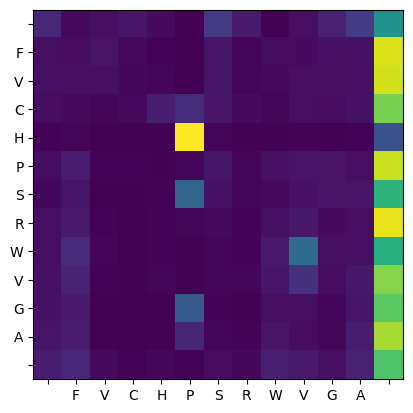

Layer 1, head 14


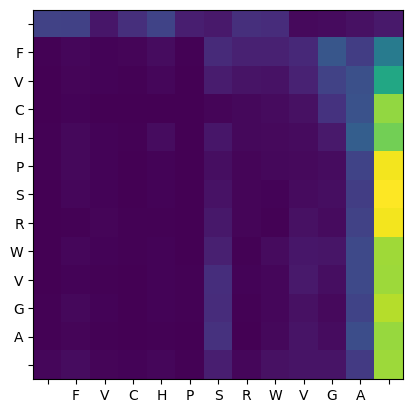

Layer 1, head 15


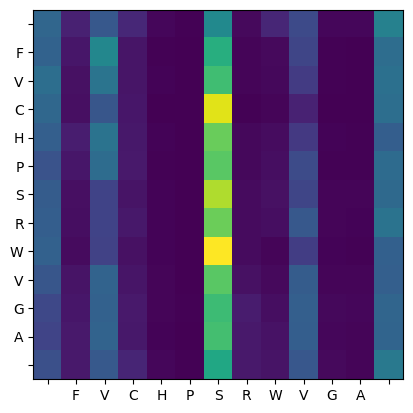

Layer 1, head 16


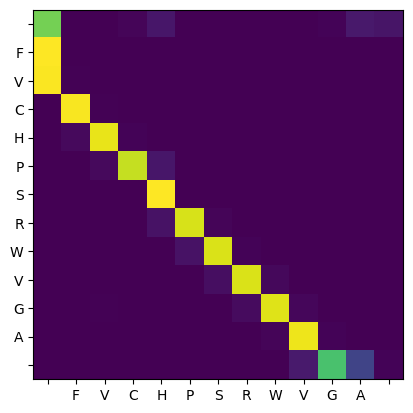

Layer 1, head 17


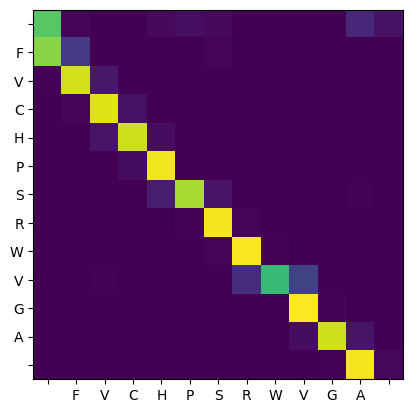

Layer 1, head 18


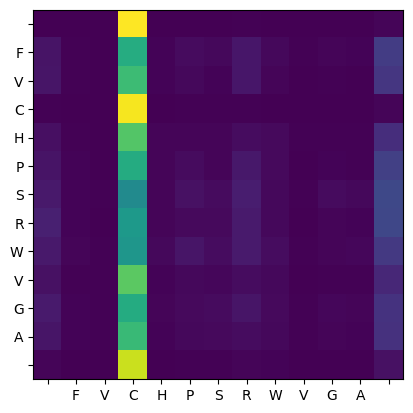

Layer 1, head 19


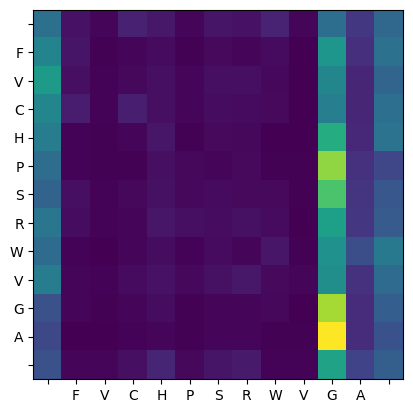

Layer 2, head 0


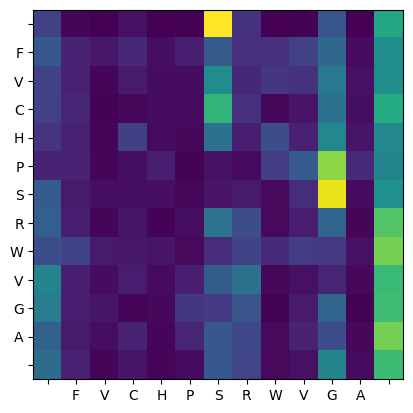

Layer 2, head 1


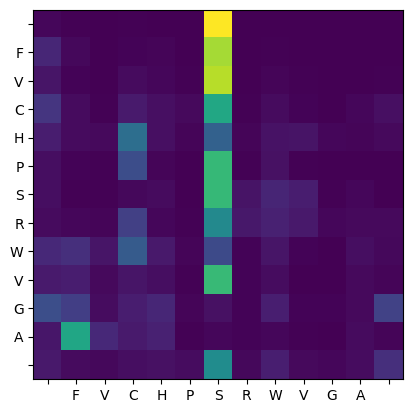

Layer 2, head 2


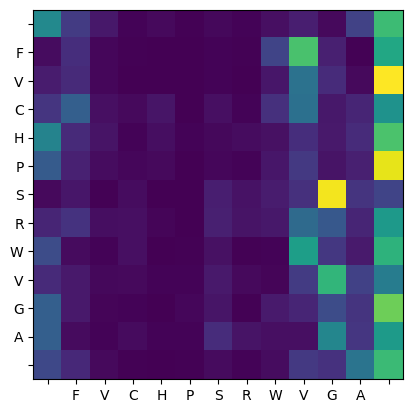

Layer 2, head 3


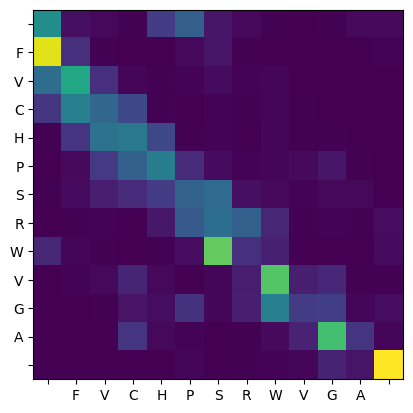

Layer 2, head 4


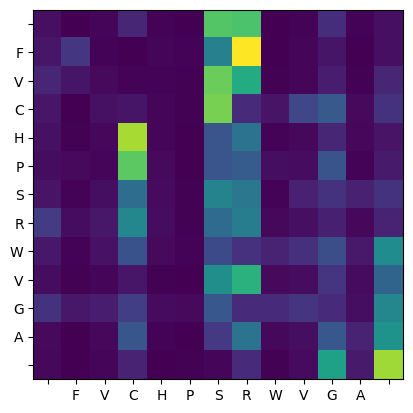

Layer 2, head 5


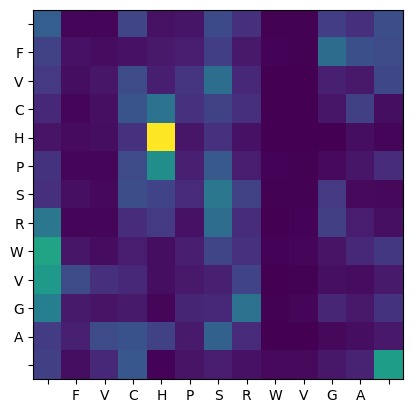

Layer 2, head 6


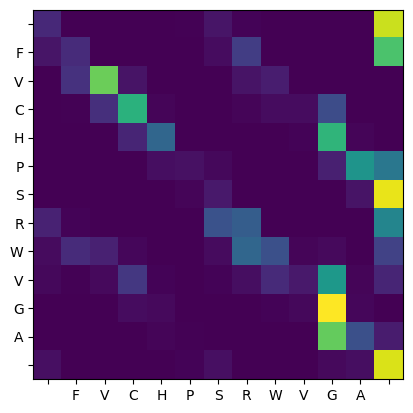

Layer 2, head 7


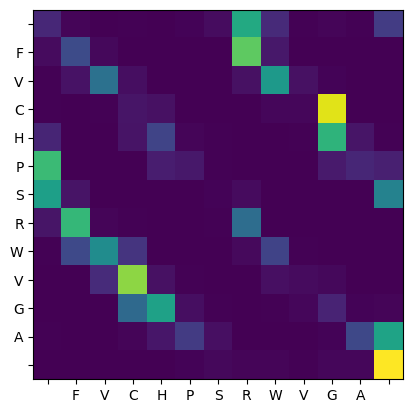

Layer 2, head 8


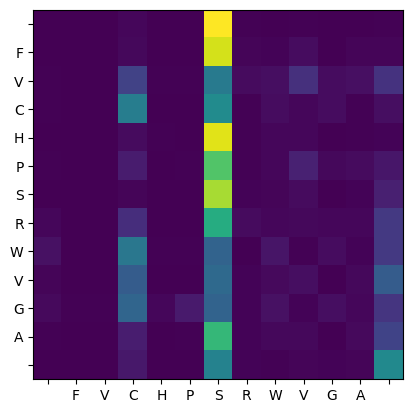

Layer 2, head 9


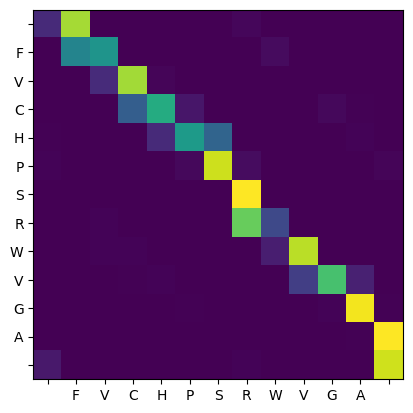

Layer 2, head 10


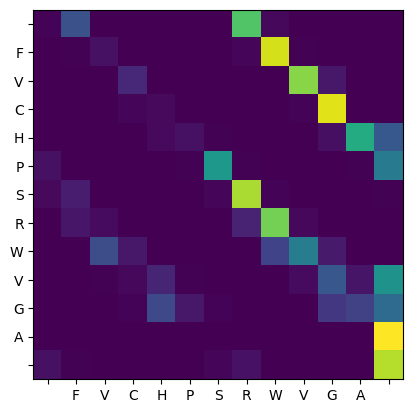

Layer 2, head 11


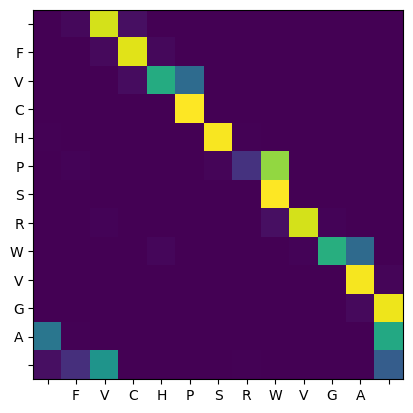

Layer 2, head 12


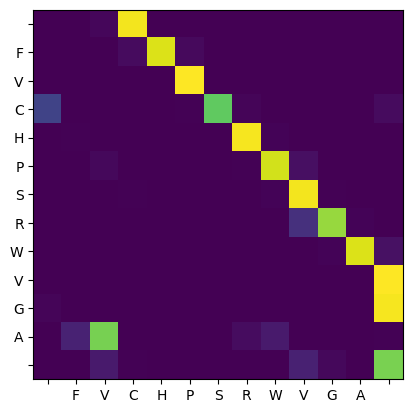

Layer 2, head 13


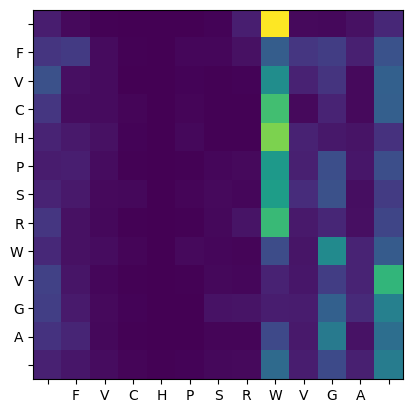

Layer 2, head 14


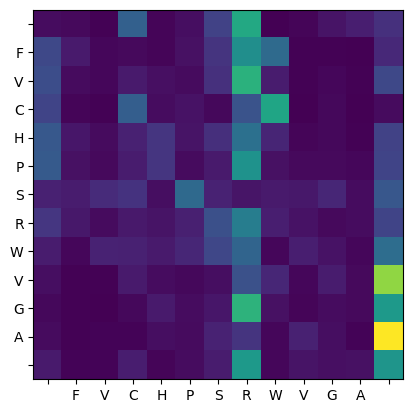

Layer 2, head 15


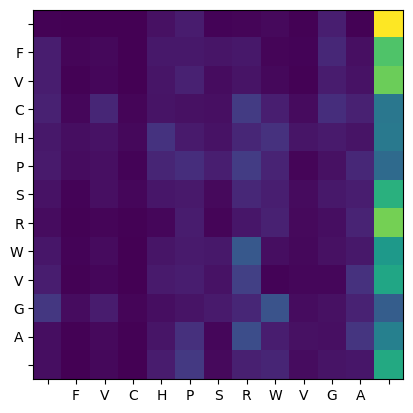

Layer 2, head 16


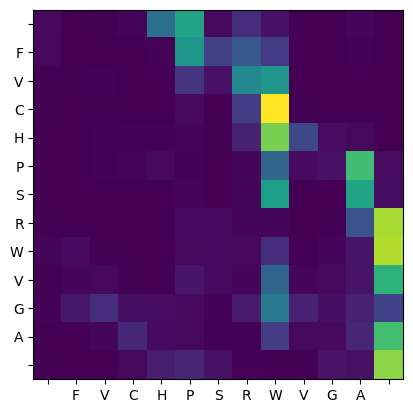

Layer 2, head 17


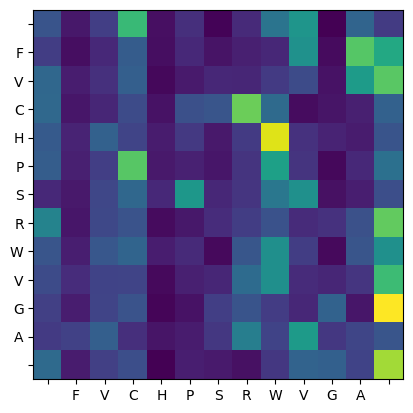

Layer 2, head 18


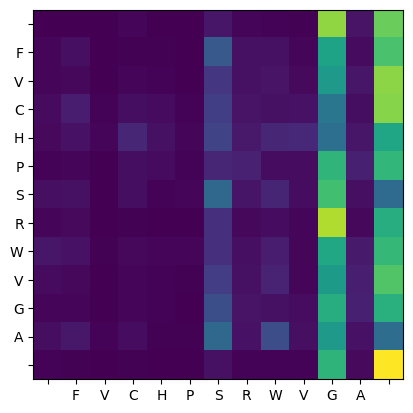

Layer 2, head 19


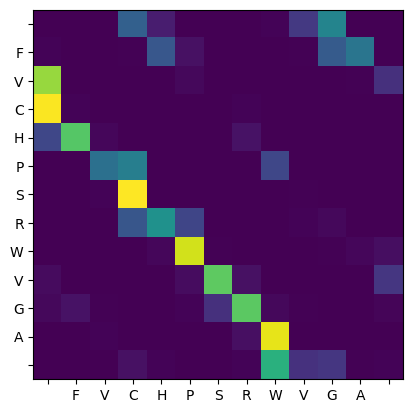

Layer 3, head 0


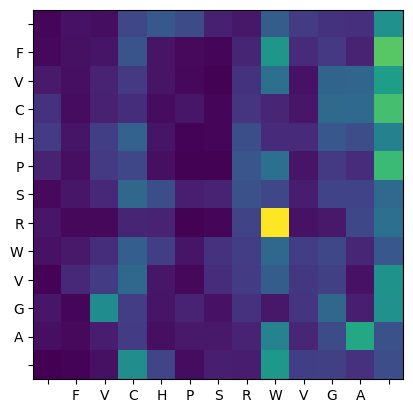

Layer 3, head 1


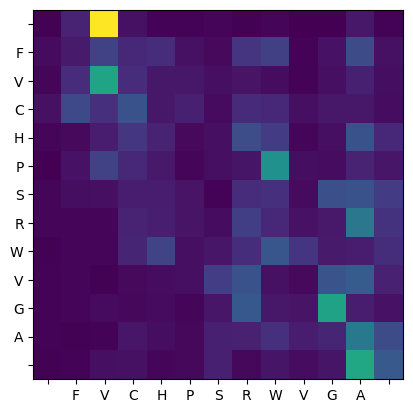

Layer 3, head 2


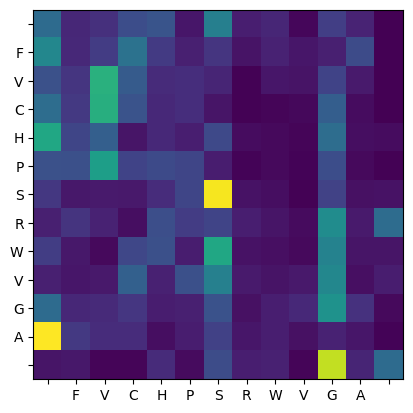

Layer 3, head 3


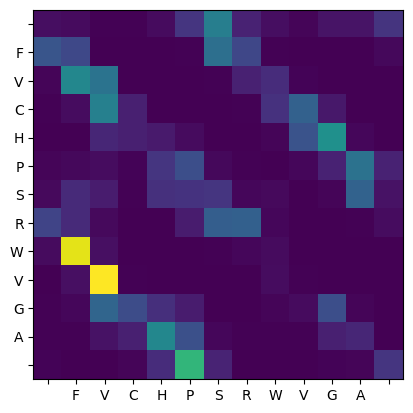

Layer 3, head 4


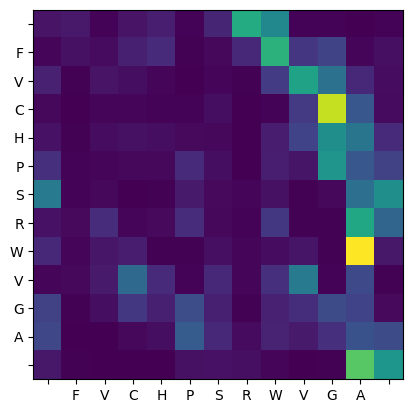

Layer 3, head 5


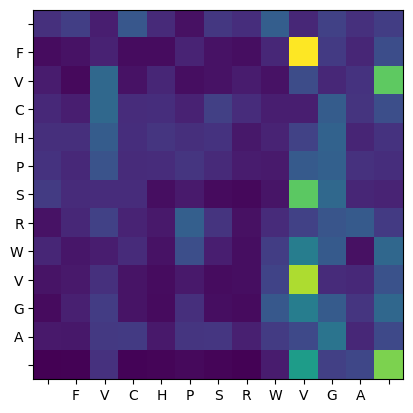

Layer 3, head 6


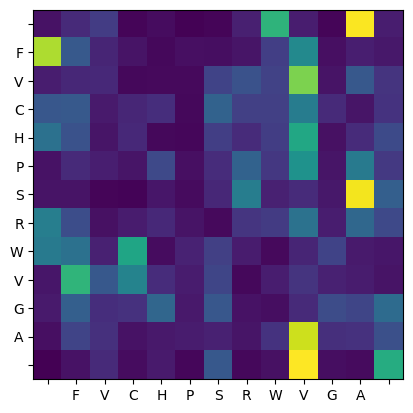

Layer 3, head 7


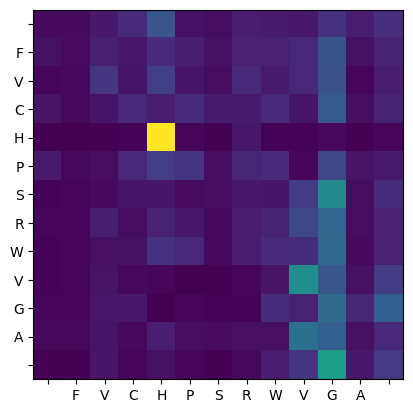

Layer 3, head 8


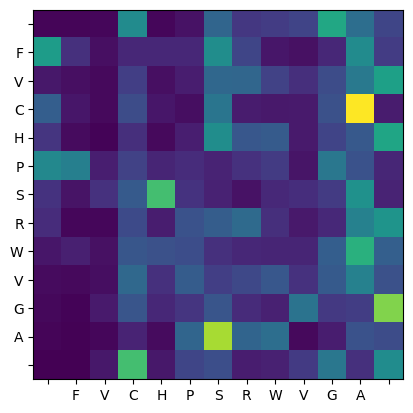

Layer 3, head 9


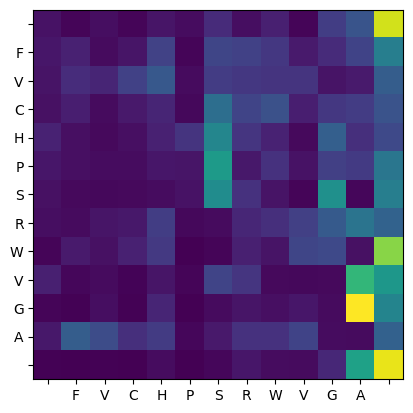

Layer 3, head 10


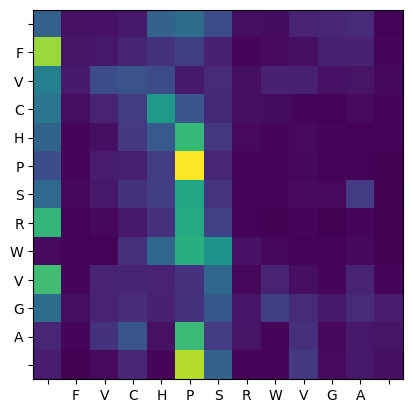

Layer 3, head 11


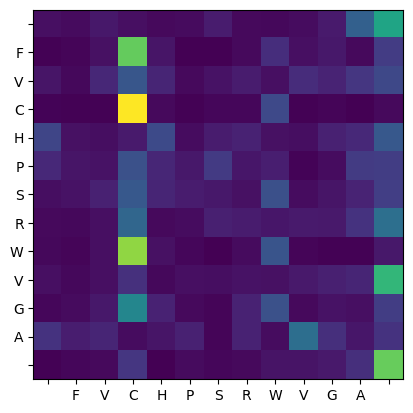

Layer 3, head 12


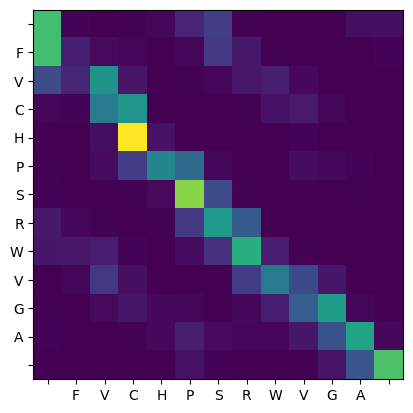

Layer 3, head 13


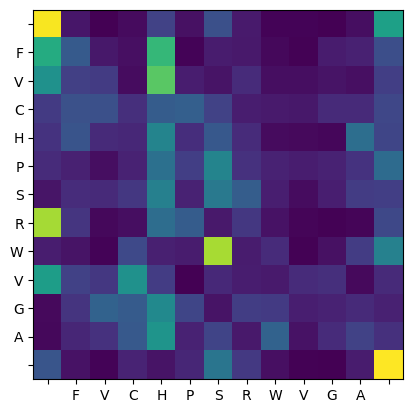

Layer 3, head 14


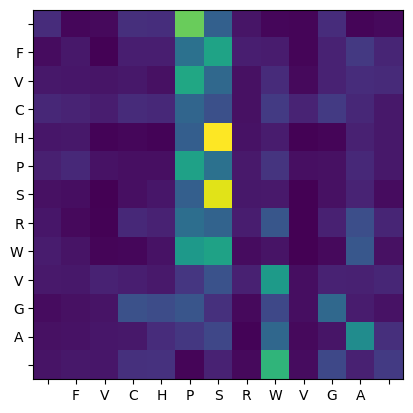

Layer 3, head 15


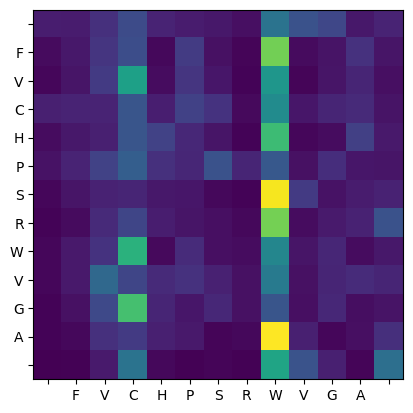

Layer 3, head 16


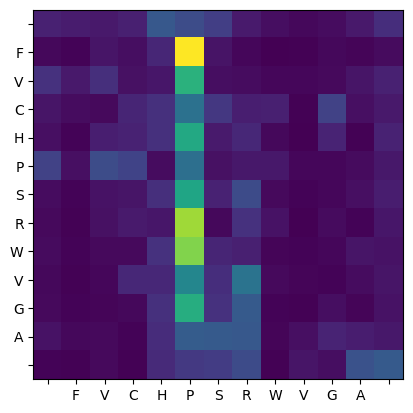

Layer 3, head 17


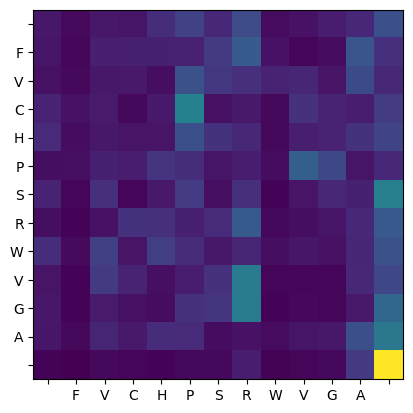

Layer 3, head 18


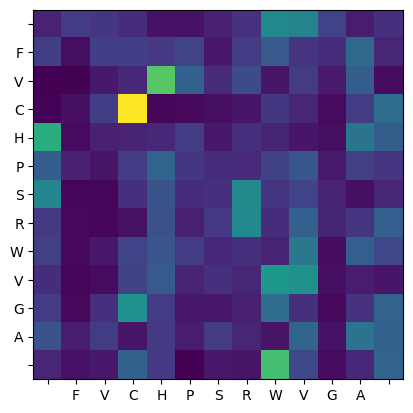

Layer 3, head 19


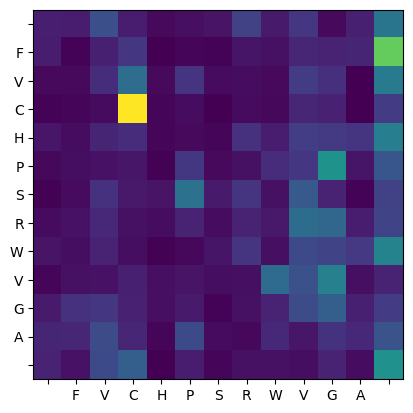

Layer 4, head 0


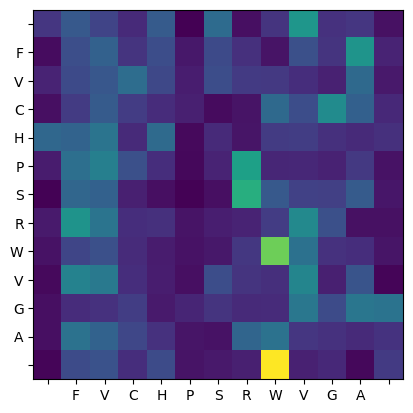

Layer 4, head 1


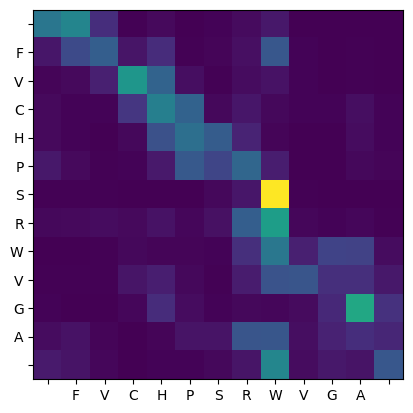

Layer 4, head 2


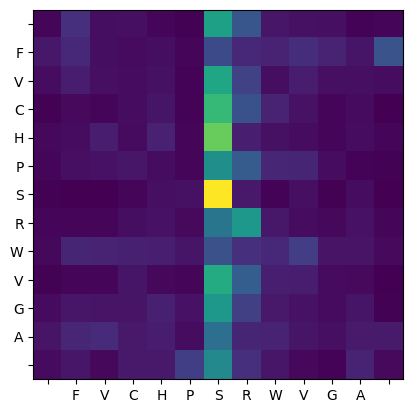

Layer 4, head 3


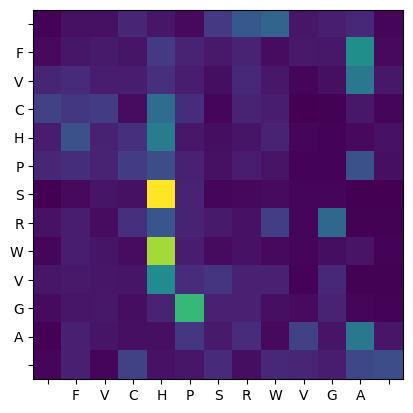

Layer 4, head 4


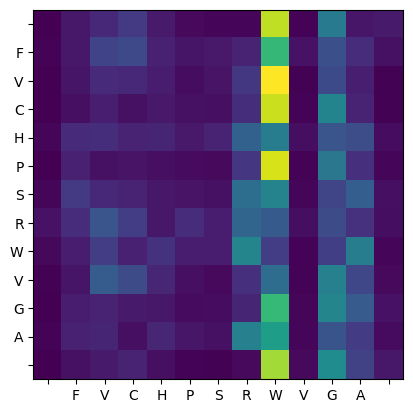

Layer 4, head 5


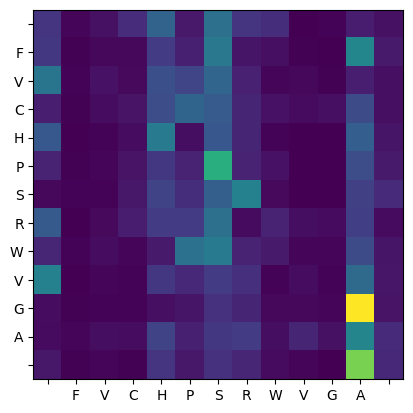

Layer 4, head 6


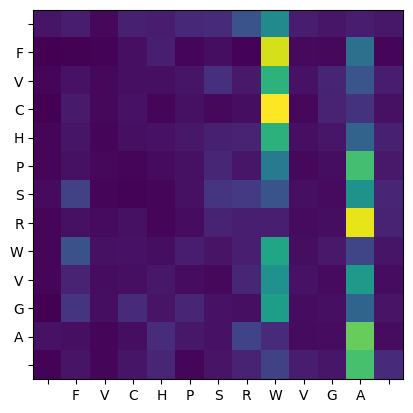

Layer 4, head 7


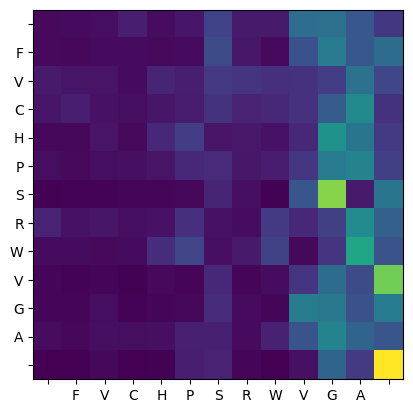

Layer 4, head 8


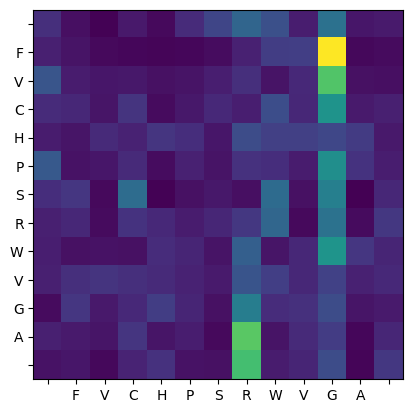

Layer 4, head 9


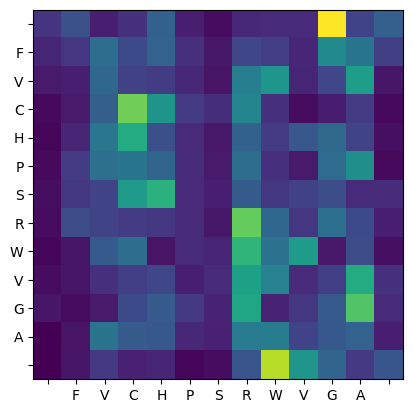

Layer 4, head 10


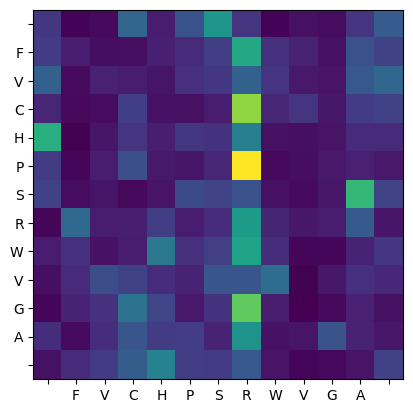

Layer 4, head 11


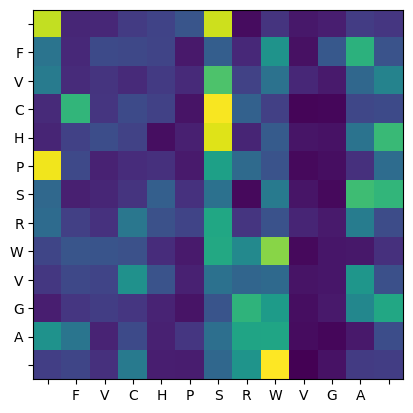

Layer 4, head 12


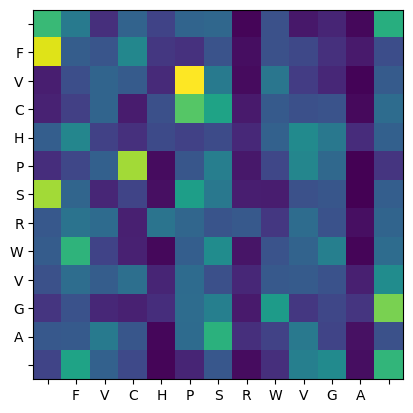

Layer 4, head 13


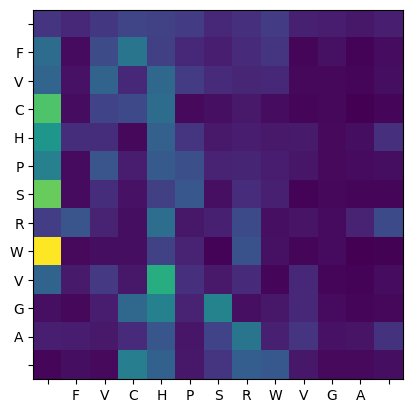

Layer 4, head 14


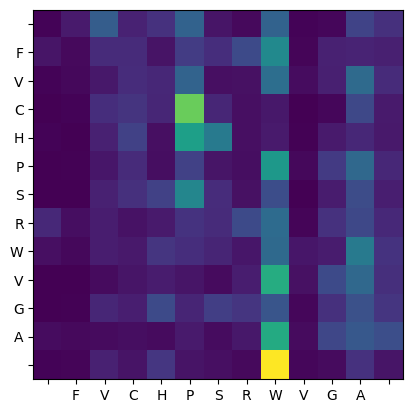

Layer 4, head 15


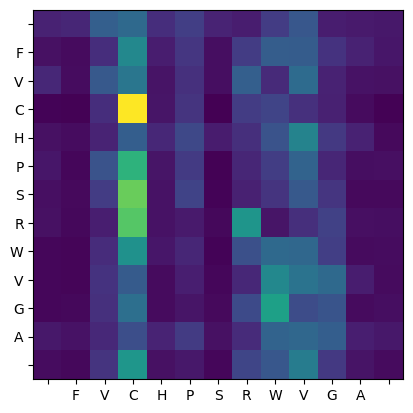

Layer 4, head 16


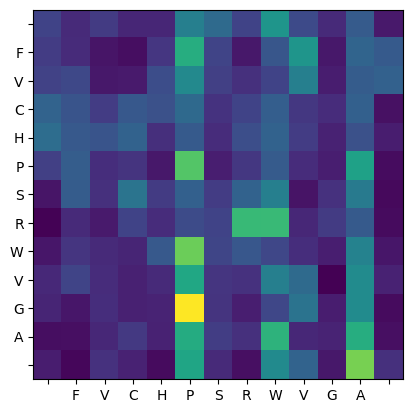

Layer 4, head 17


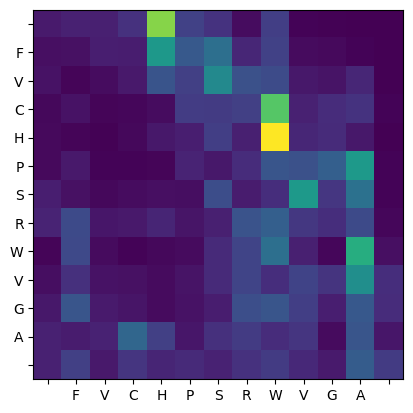

Layer 4, head 18


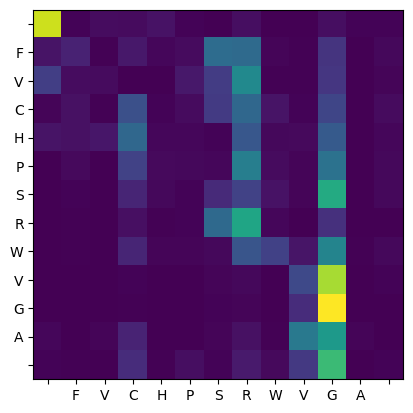

Layer 4, head 19


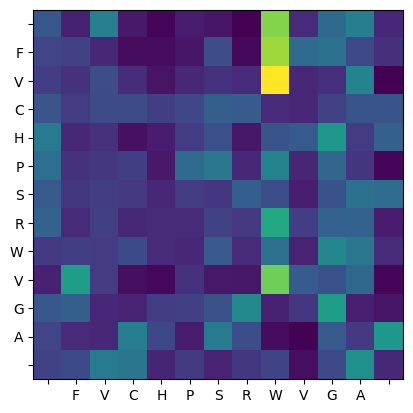

Layer 5, head 0


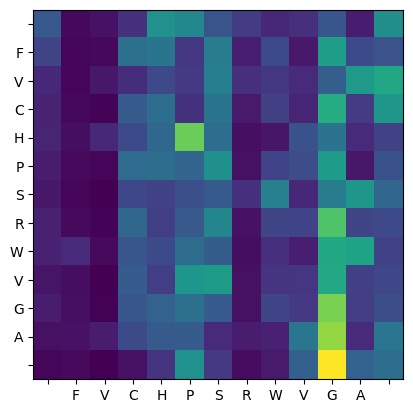

Layer 5, head 1


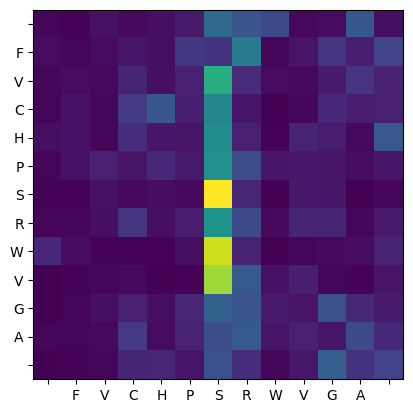

Layer 5, head 2


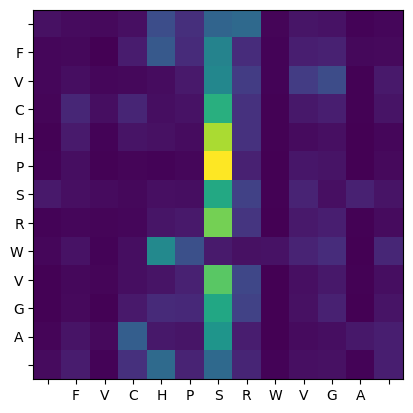

Layer 5, head 3


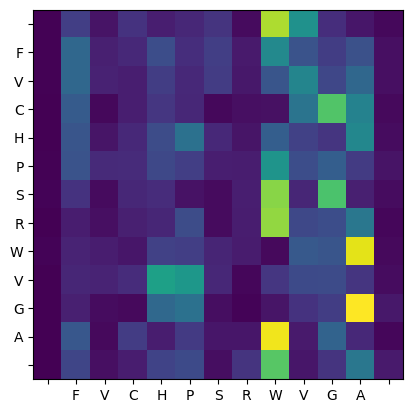

Layer 5, head 4


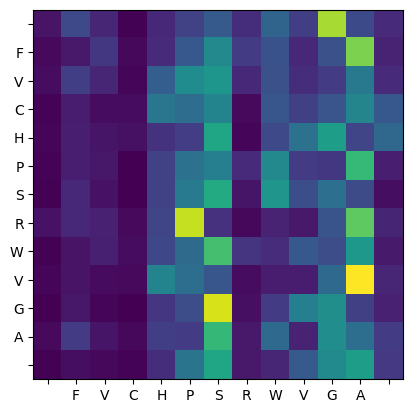

Layer 5, head 5


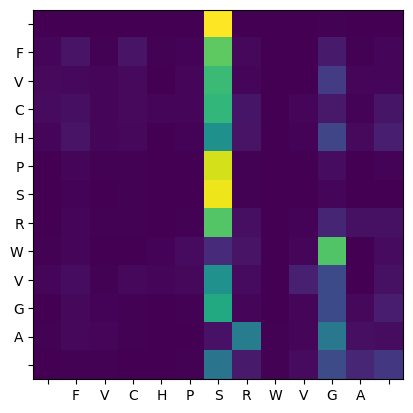

Layer 5, head 6


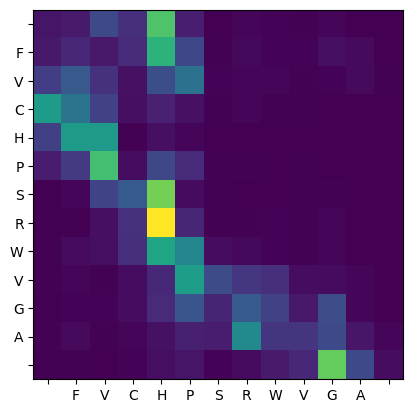

Layer 5, head 7


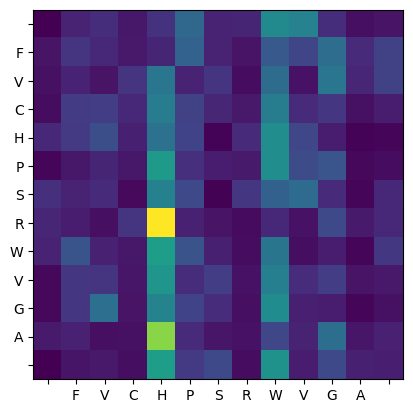

Layer 5, head 8


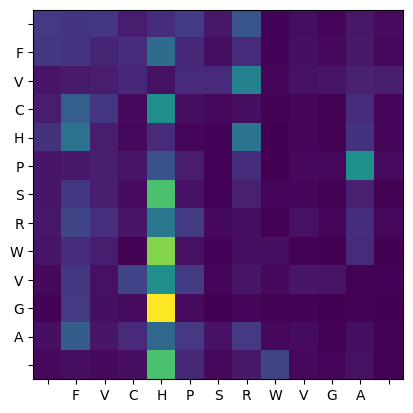

Layer 5, head 9


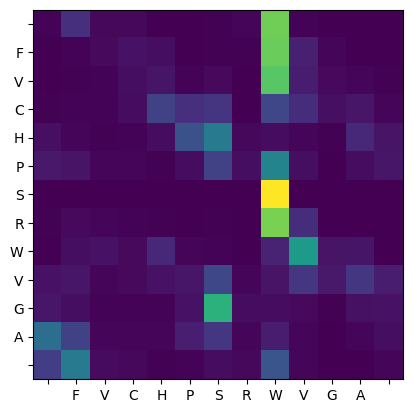

Layer 5, head 10


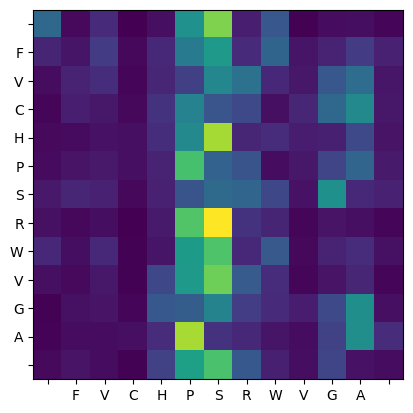

Layer 5, head 11


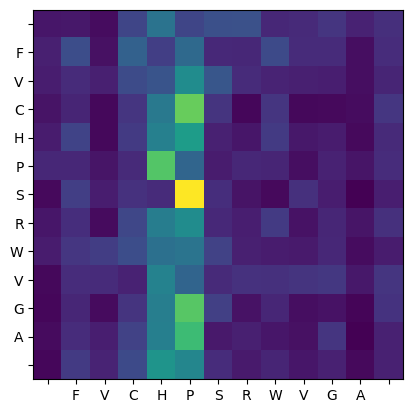

Layer 5, head 12


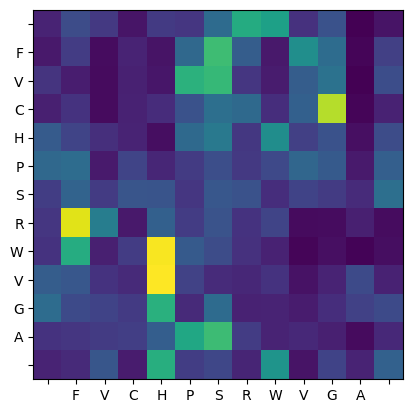

Layer 5, head 13


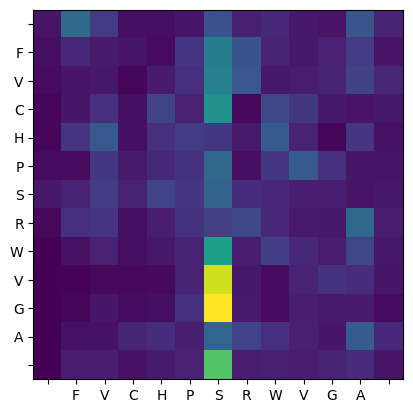

Layer 5, head 14


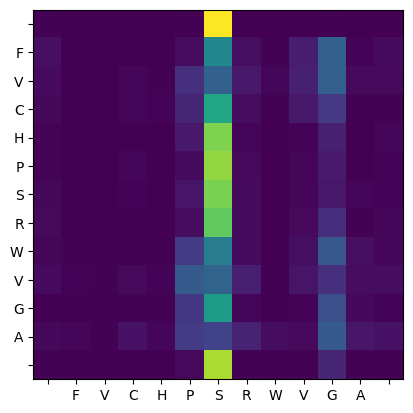

Layer 5, head 15


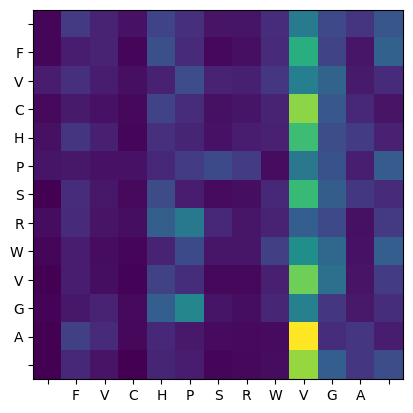

Layer 5, head 16


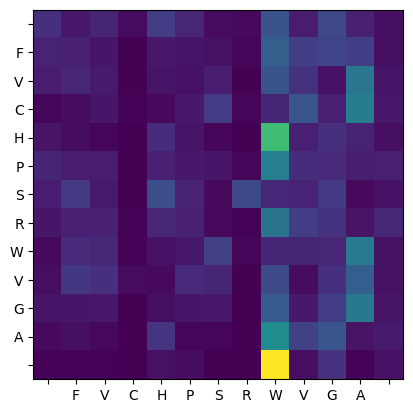

Layer 5, head 17


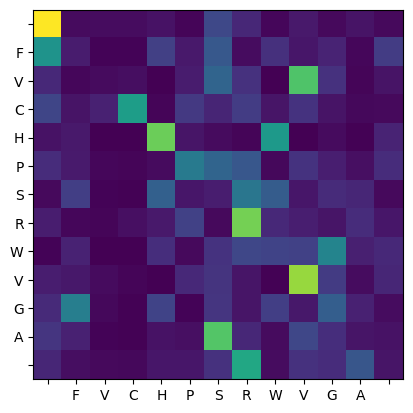

Layer 5, head 18


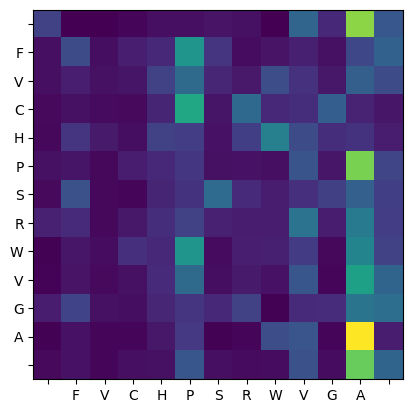

Layer 5, head 19


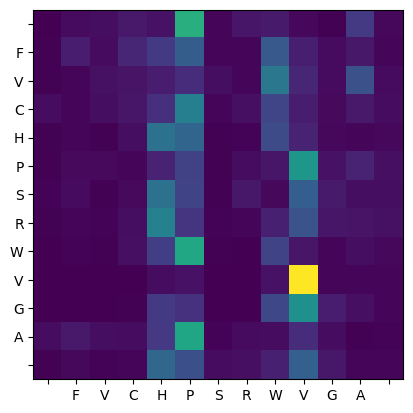

Layer 6, head 0


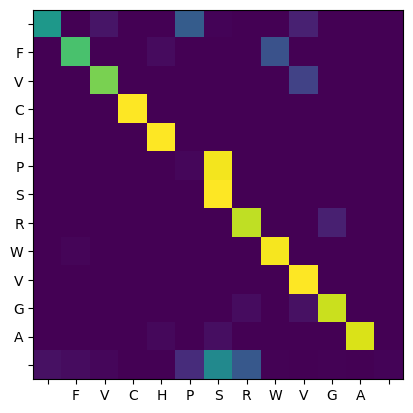

Layer 6, head 1


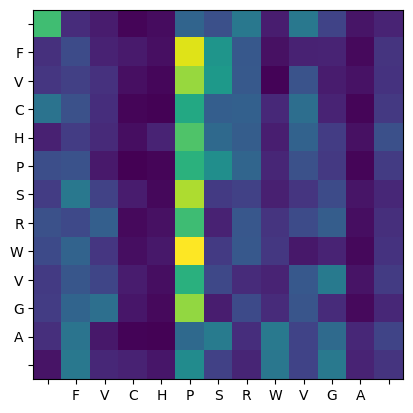

Layer 6, head 2


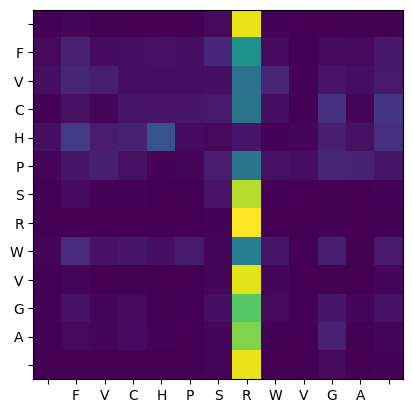

Layer 6, head 3


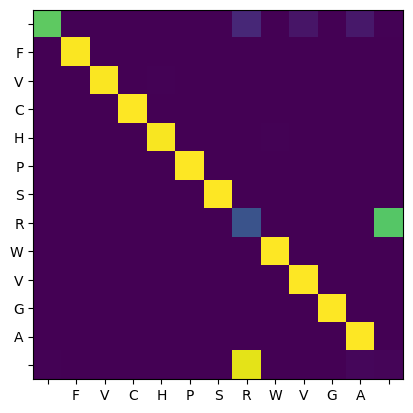

Layer 6, head 4


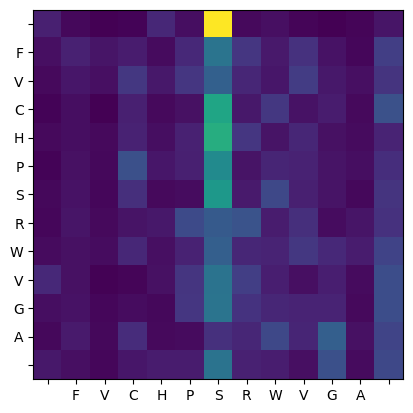

Layer 6, head 5


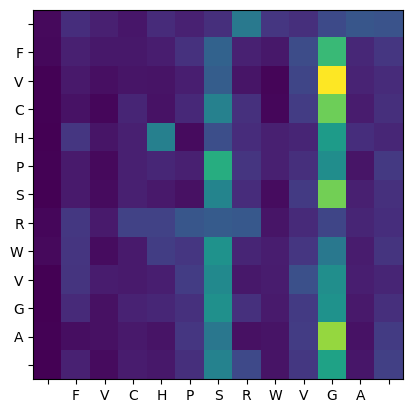

Layer 6, head 6


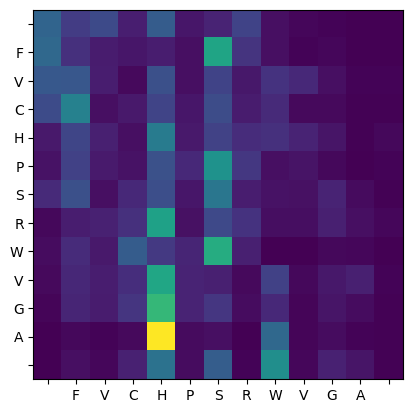

Layer 6, head 7


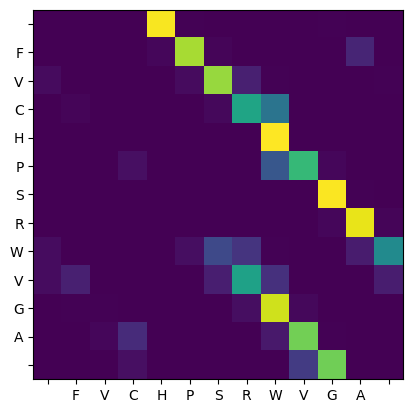

Layer 6, head 8


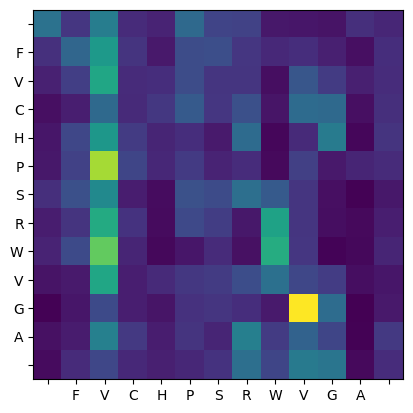

Layer 6, head 9


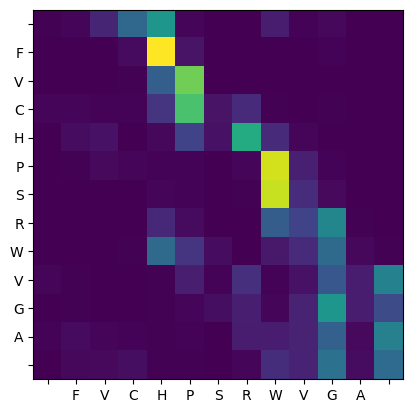

Layer 6, head 10


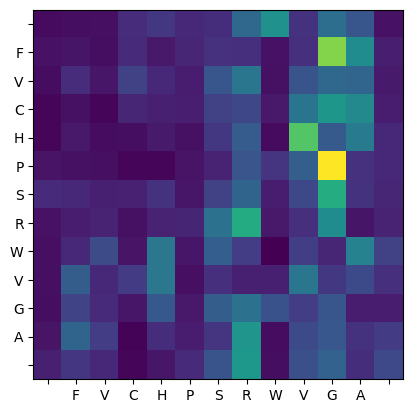

Layer 6, head 11


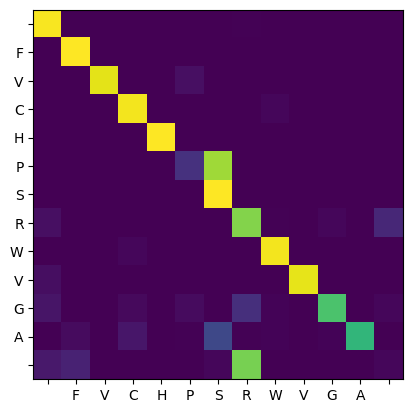

Layer 6, head 12


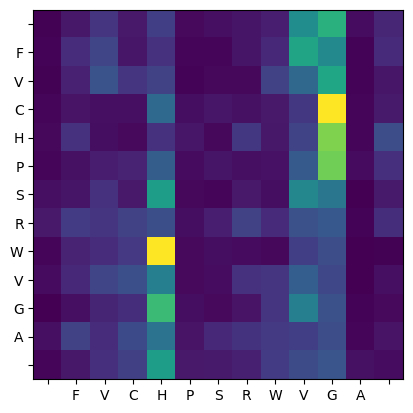

Layer 6, head 13


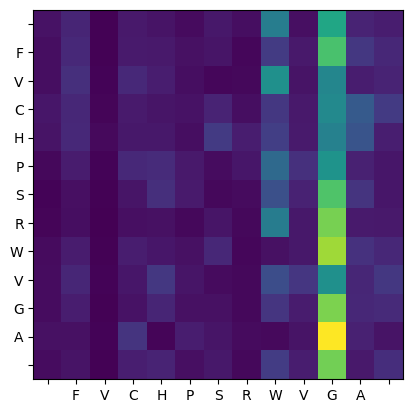

Layer 6, head 14


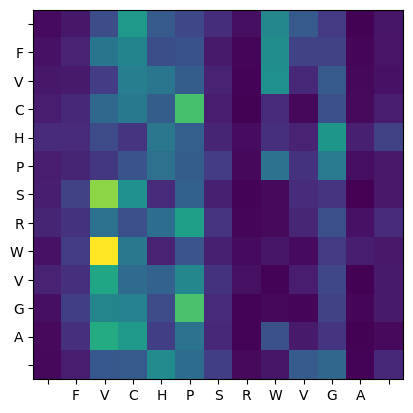

Layer 6, head 15


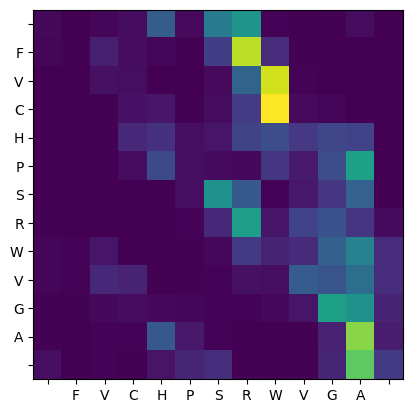

Layer 6, head 16


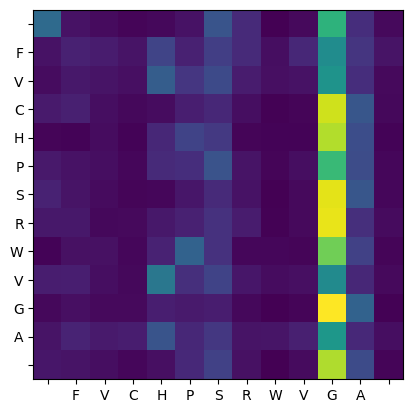

Layer 6, head 17


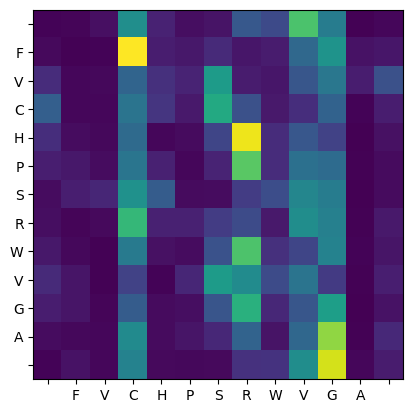

Layer 6, head 18


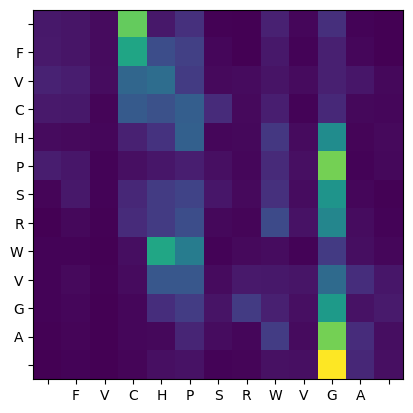

Layer 6, head 19


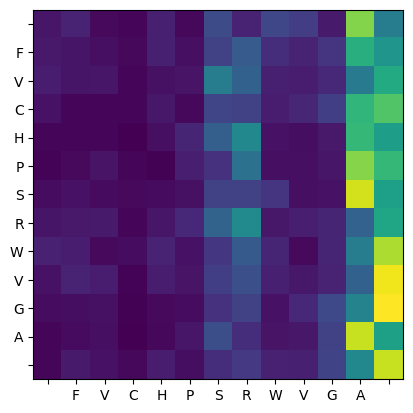

Layer 7, head 0


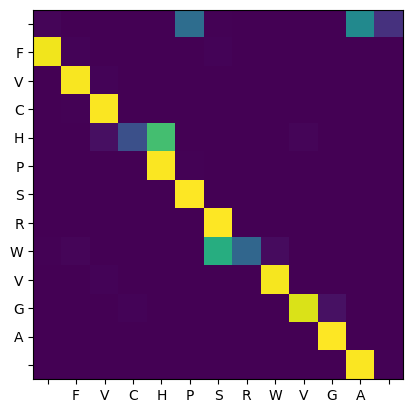

Layer 7, head 1


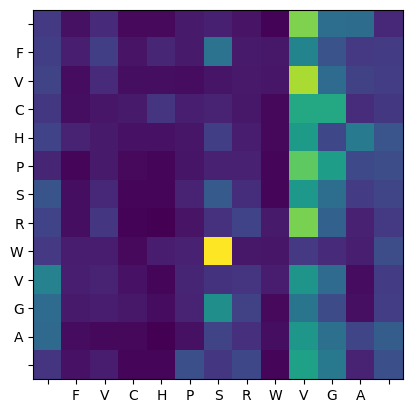

Layer 7, head 2


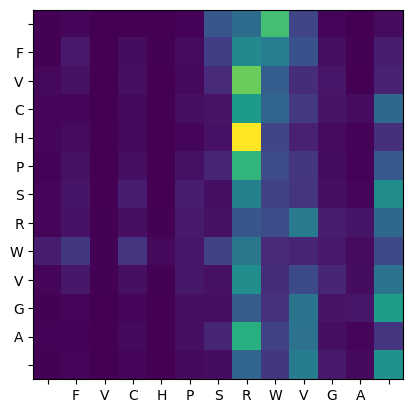

Layer 7, head 3


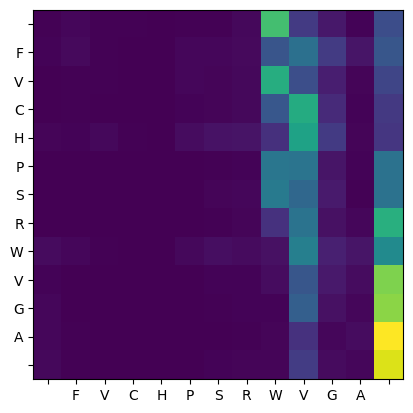

Layer 7, head 4


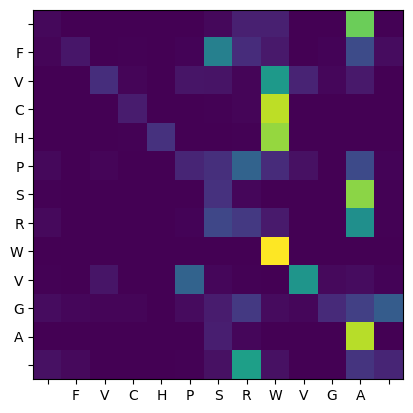

Layer 7, head 5


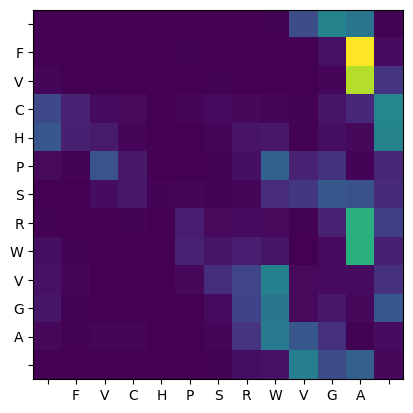

Layer 7, head 6


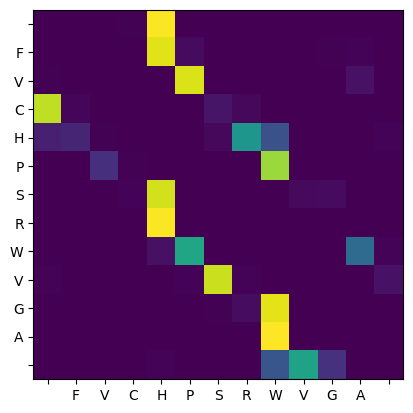

Layer 7, head 7


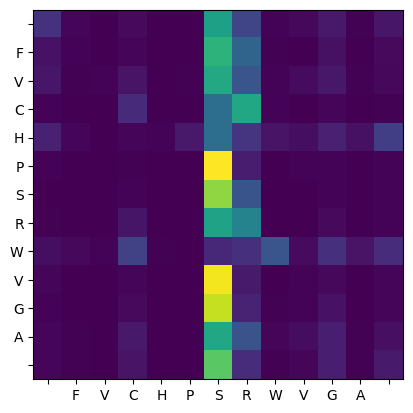

Layer 7, head 8


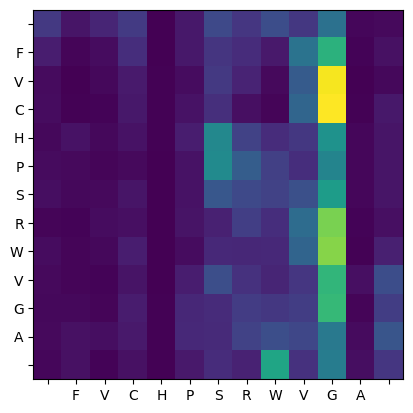

Layer 7, head 9


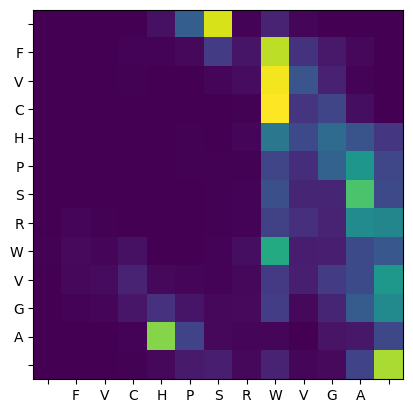

Layer 7, head 10


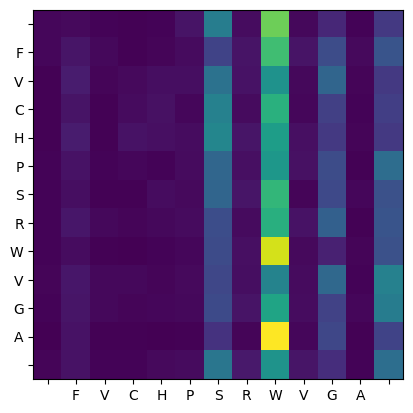

Layer 7, head 11


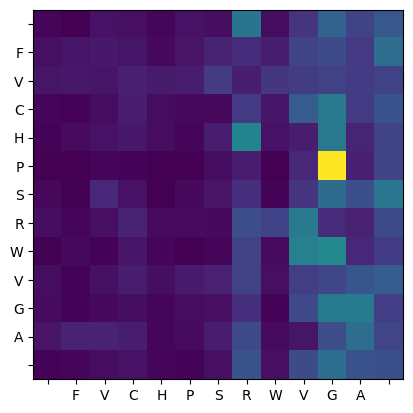

Layer 7, head 12


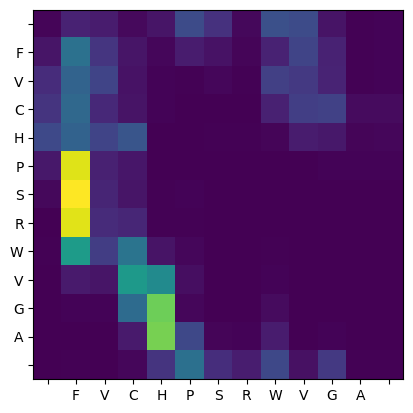

Layer 7, head 13


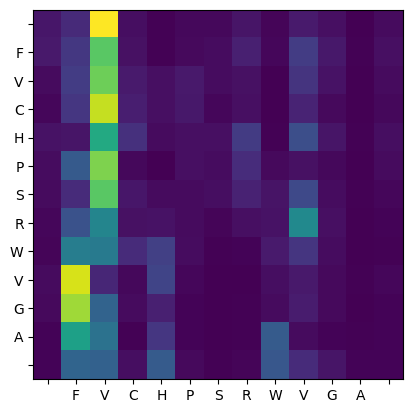

Layer 7, head 14


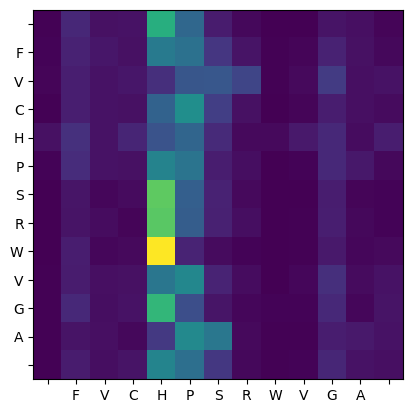

Layer 7, head 15


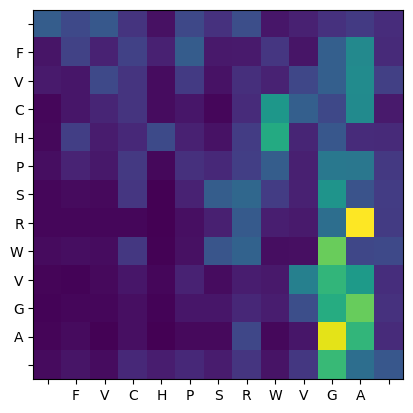

Layer 7, head 16


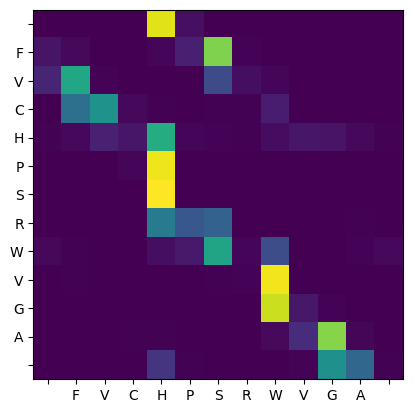

Layer 7, head 17


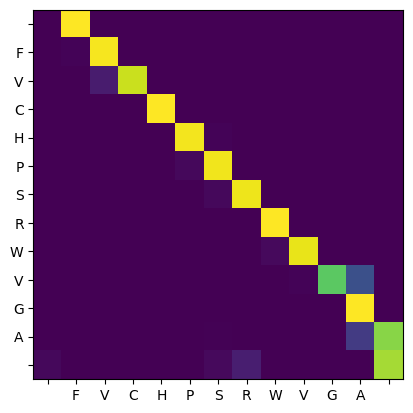

Layer 7, head 18


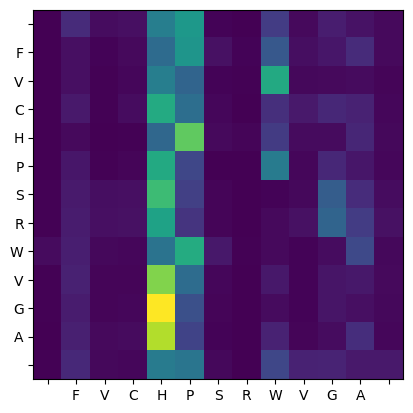

Layer 7, head 19


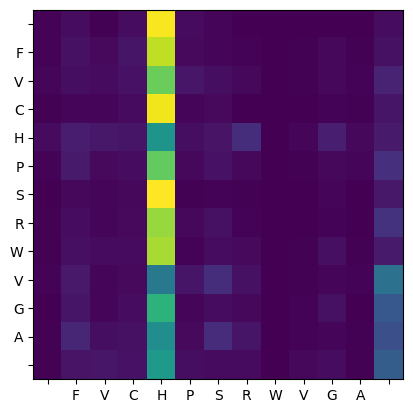

Layer 8, head 0


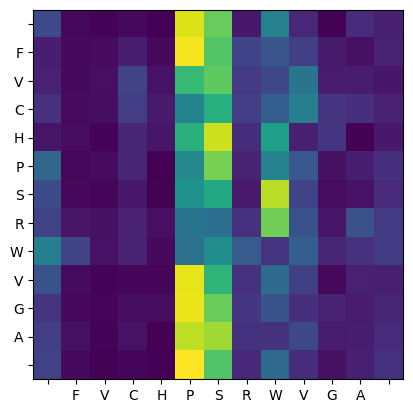

Layer 8, head 1


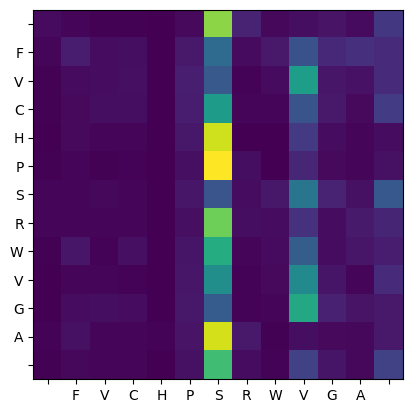

Layer 8, head 2


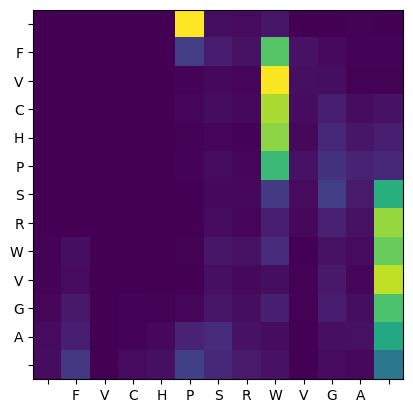

Layer 8, head 3


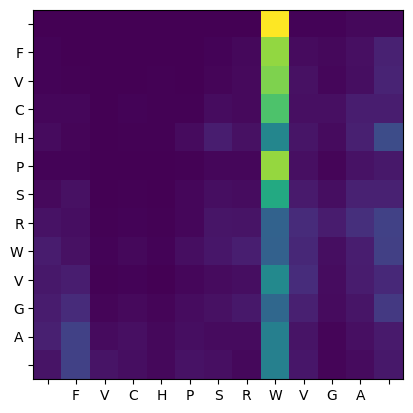

Layer 8, head 4


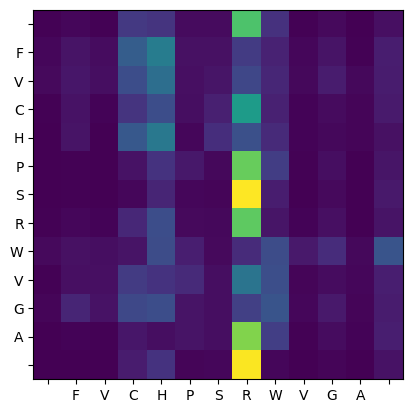

Layer 8, head 5


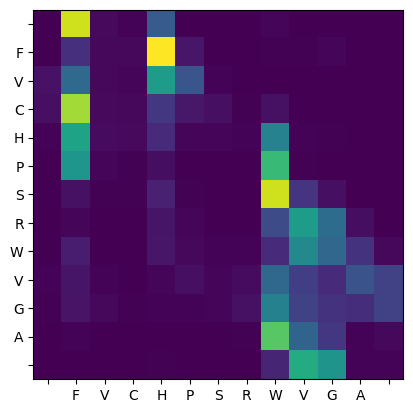

Layer 8, head 6


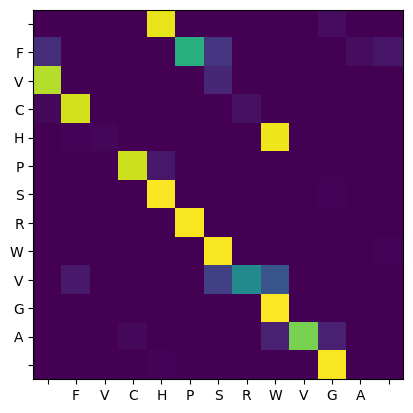

Layer 8, head 7


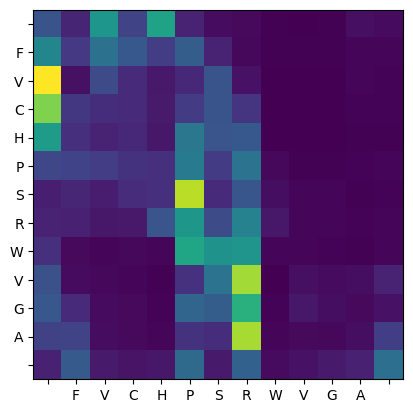

Layer 8, head 8


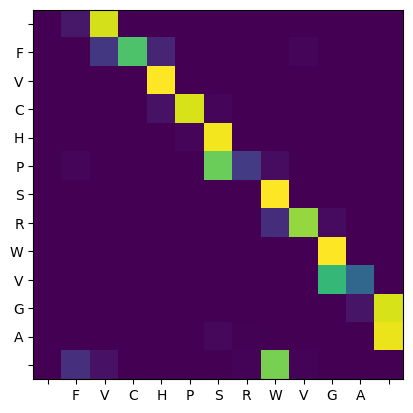

Layer 8, head 9


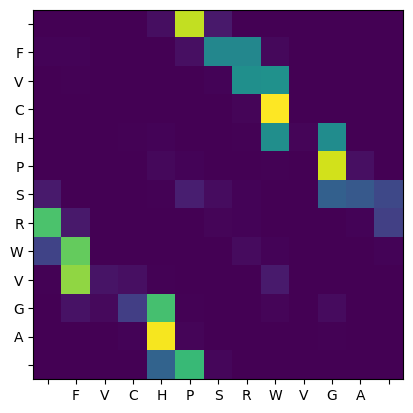

Layer 8, head 10


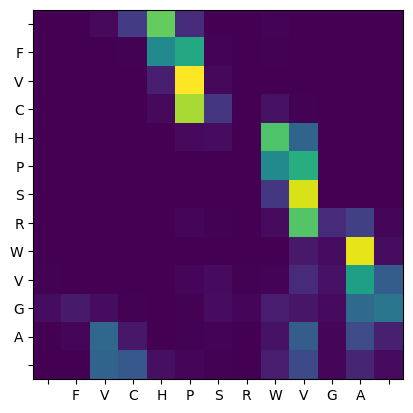

Layer 8, head 11


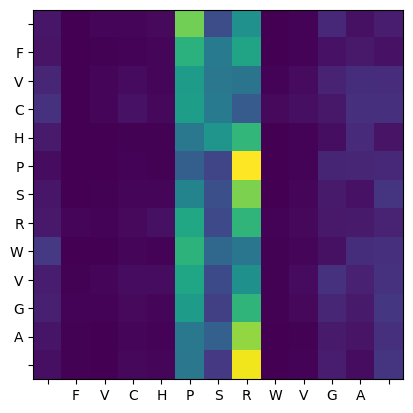

Layer 8, head 12


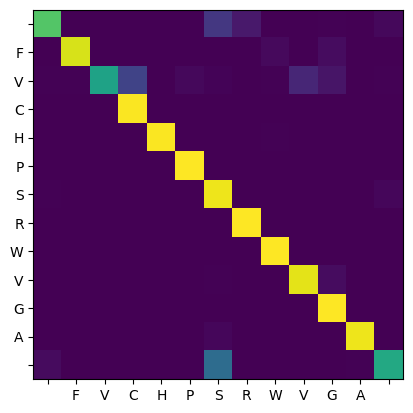

Layer 8, head 13


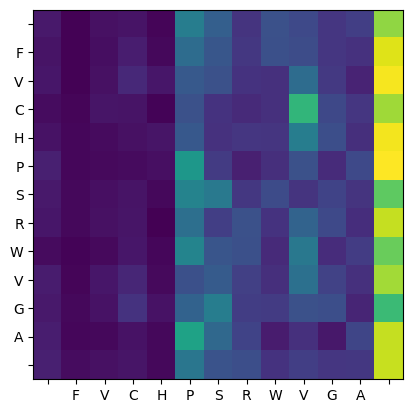

Layer 8, head 14


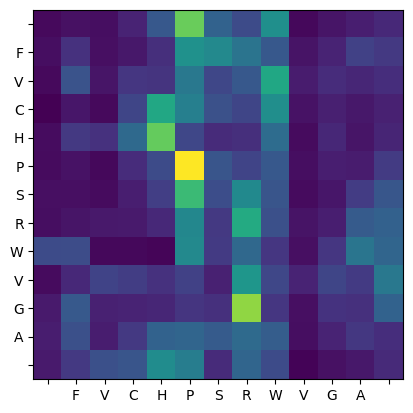

Layer 8, head 15


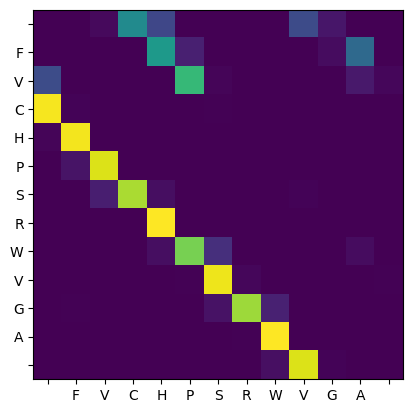

Layer 8, head 16


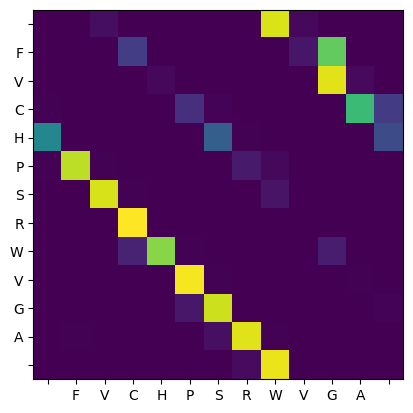

Layer 8, head 17


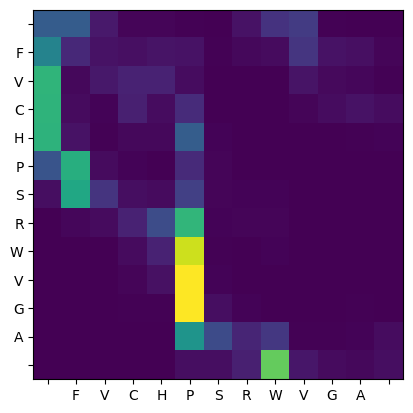

Layer 8, head 18


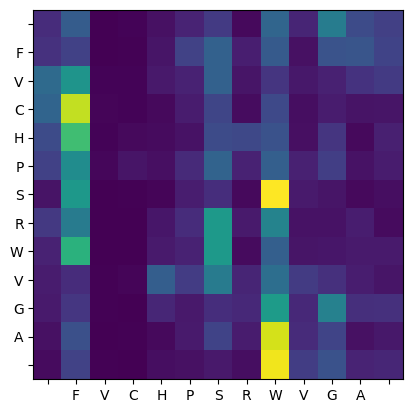

Layer 8, head 19


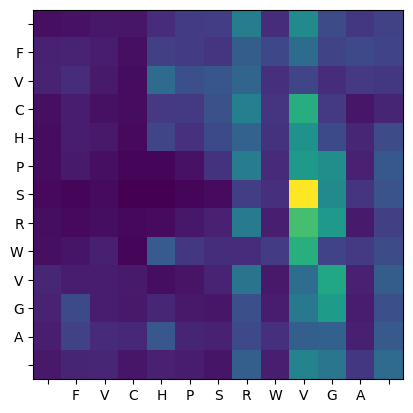

Layer 9, head 0


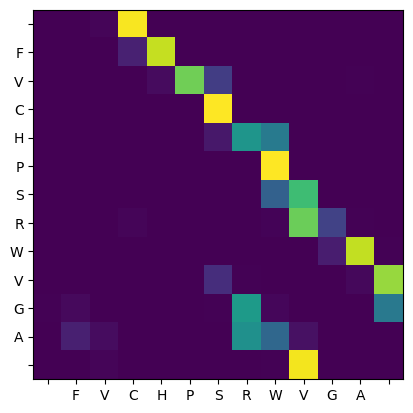

Layer 9, head 1


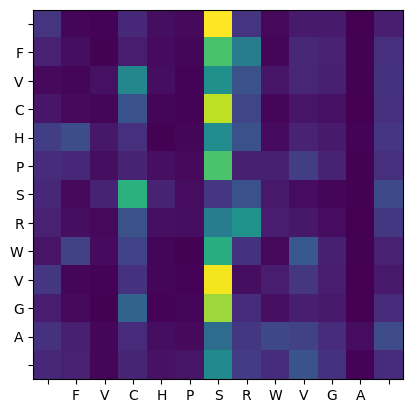

Layer 9, head 2


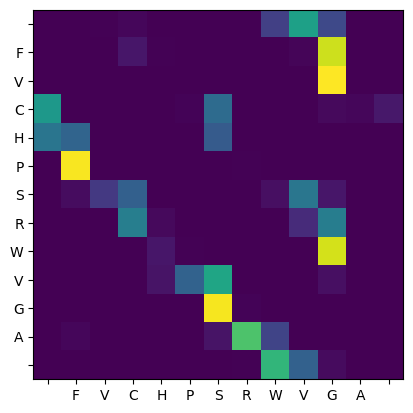

Layer 9, head 3


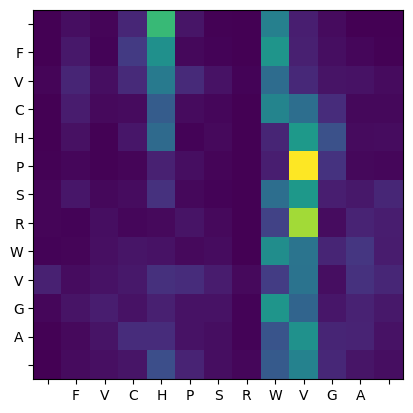

Layer 9, head 4


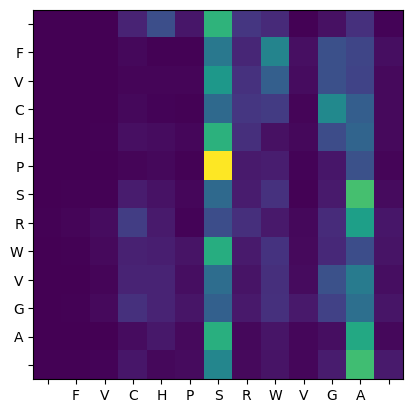

Layer 9, head 5


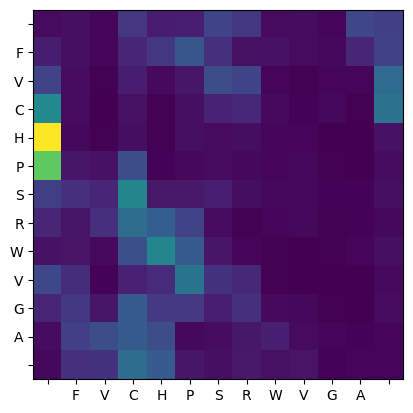

Layer 9, head 6


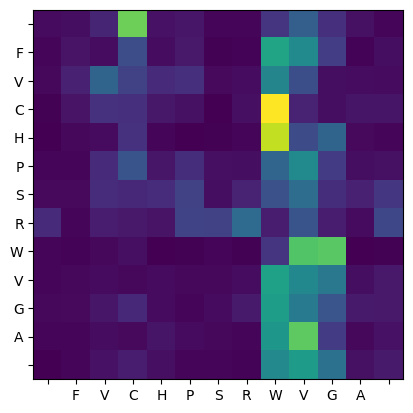

Layer 9, head 7


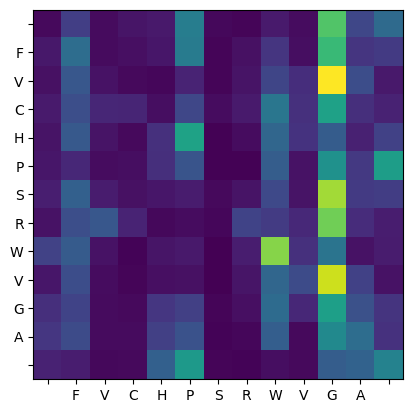

Layer 9, head 8


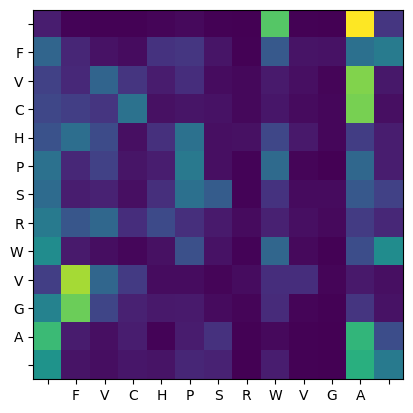

Layer 9, head 9


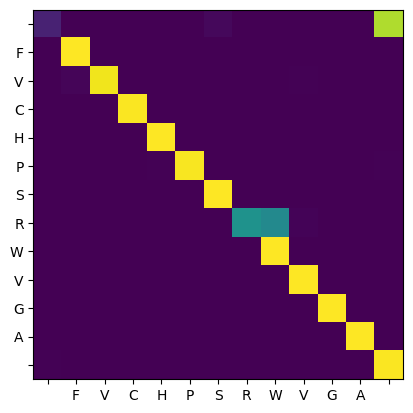

Layer 9, head 10


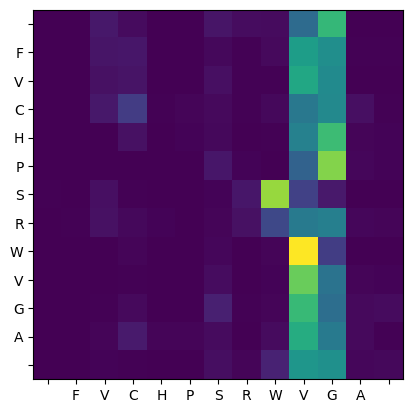

Layer 9, head 11


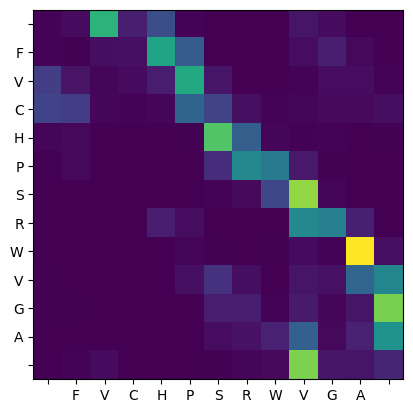

Layer 9, head 12


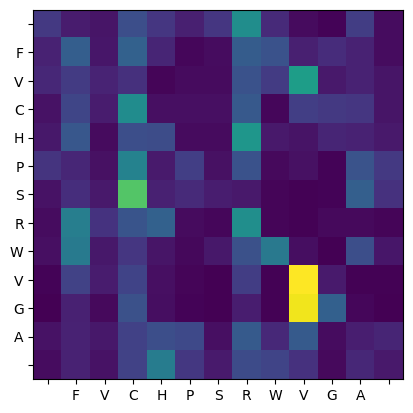

Layer 9, head 13


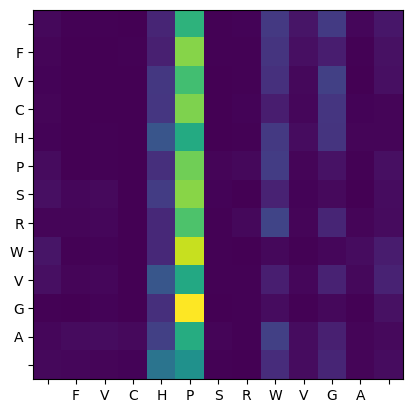

Layer 9, head 14


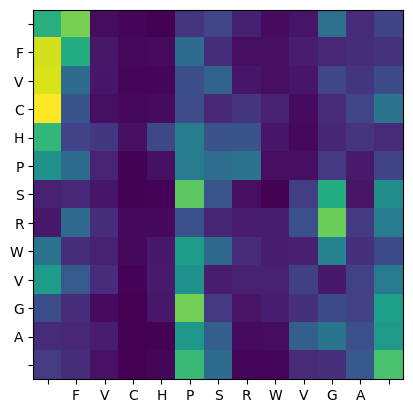

Layer 9, head 15


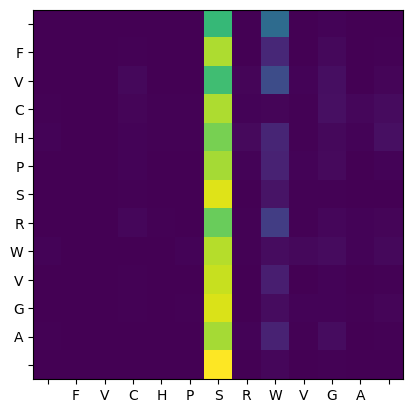

Layer 9, head 16


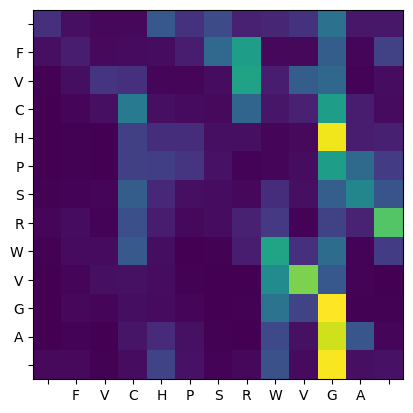

Layer 9, head 17


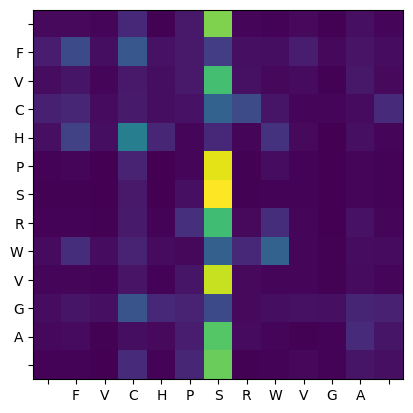

Layer 9, head 18


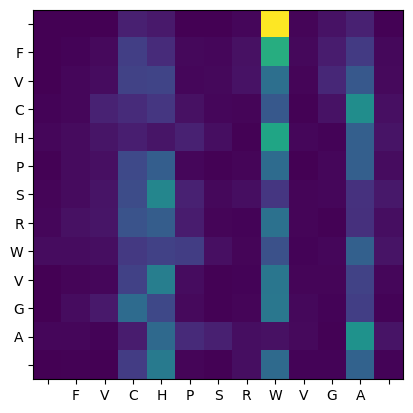

Layer 9, head 19


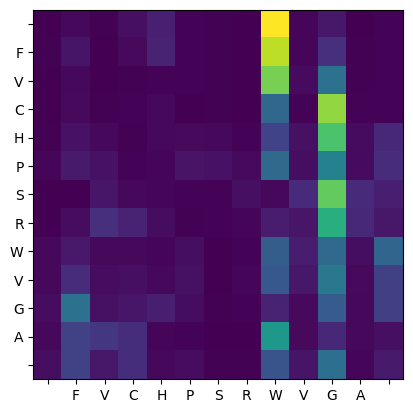

Layer 10, head 0


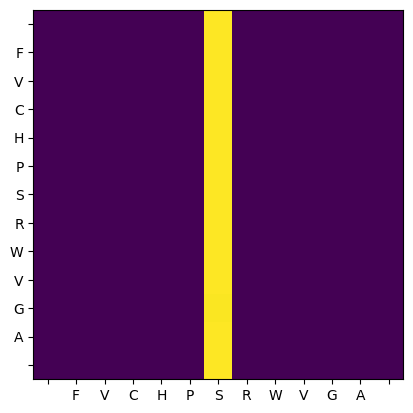

Layer 10, head 1


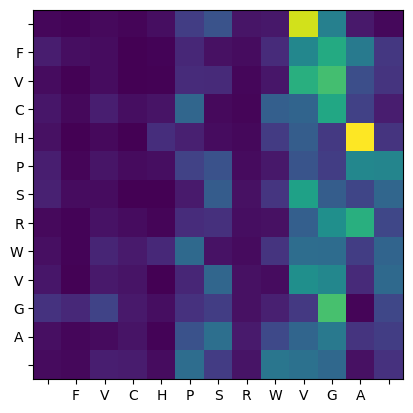

Layer 10, head 2


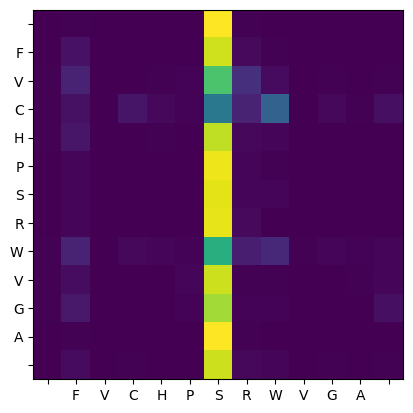

Layer 10, head 3


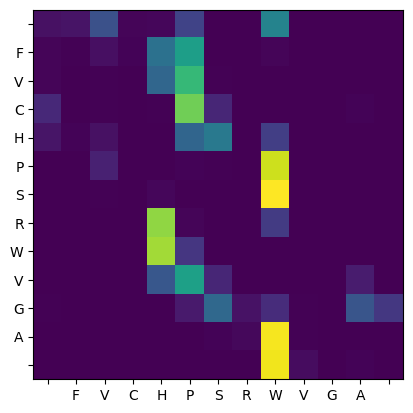

Layer 10, head 4


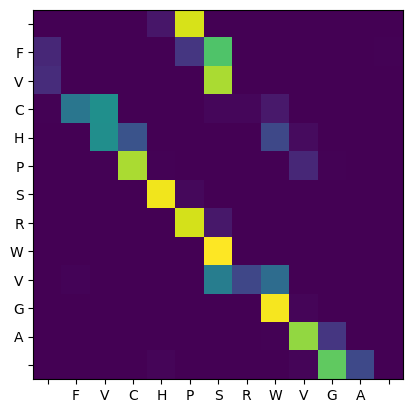

Layer 10, head 5


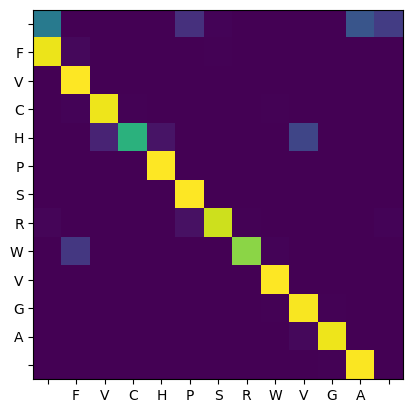

Layer 10, head 6


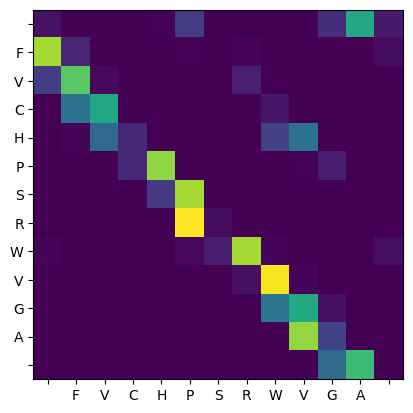

Layer 10, head 7


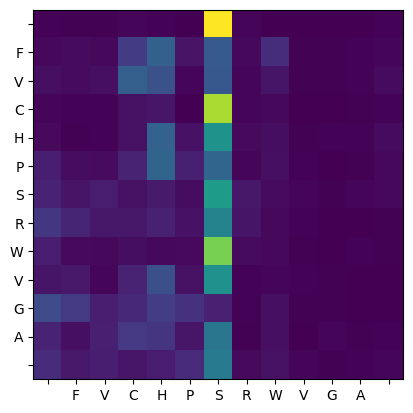

Layer 10, head 8


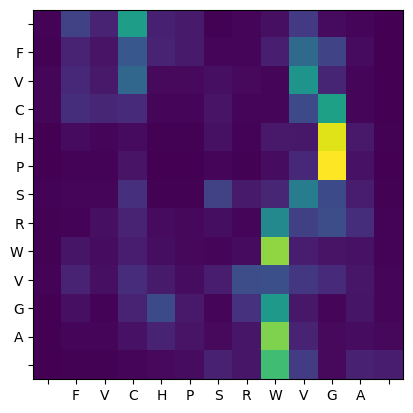

Layer 10, head 9


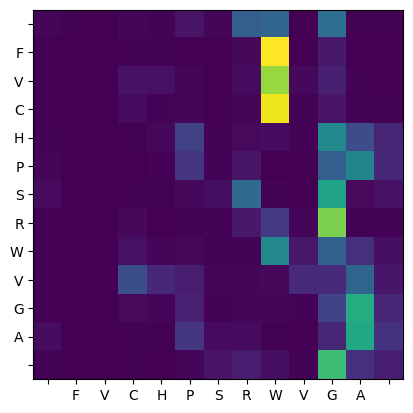

Layer 10, head 10


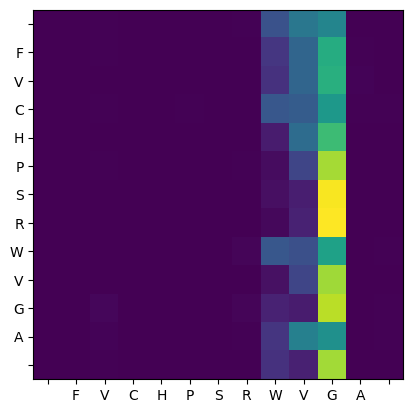

Layer 10, head 11


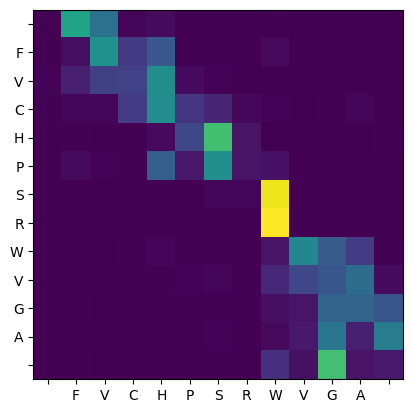

Layer 10, head 12


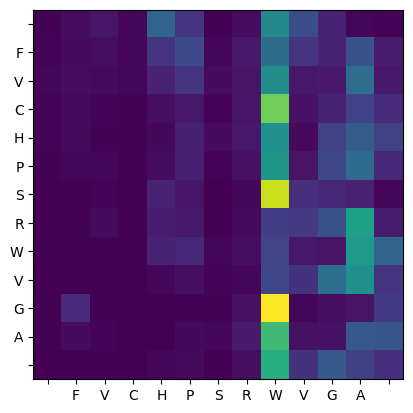

Layer 10, head 13


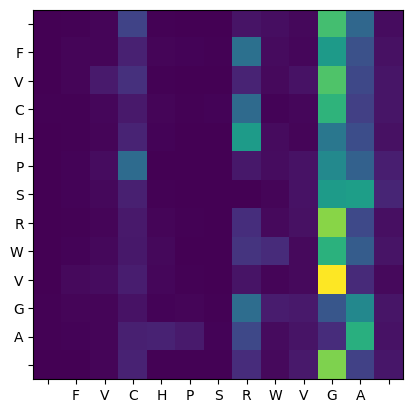

Layer 10, head 14


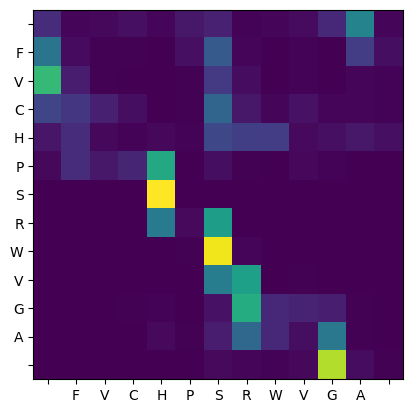

Layer 10, head 15


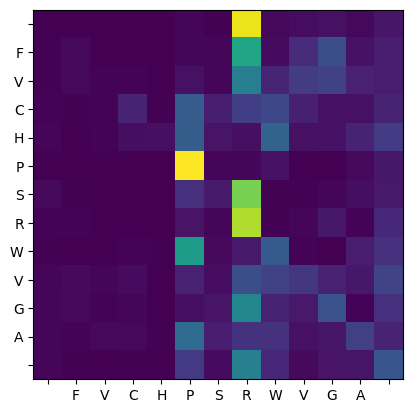

Layer 10, head 16


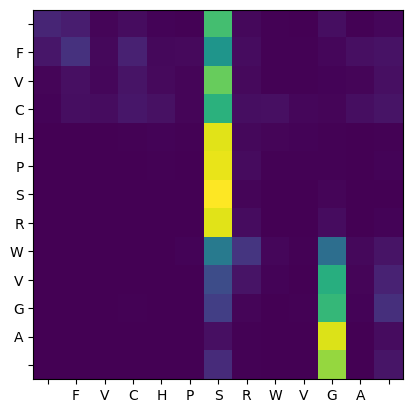

Layer 10, head 17


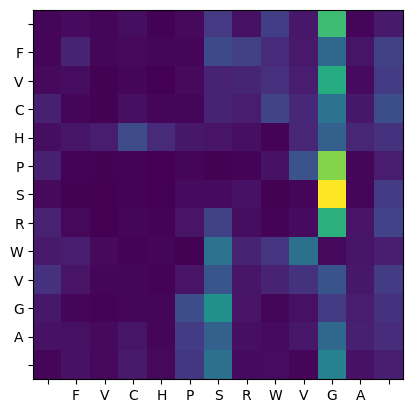

Layer 10, head 18


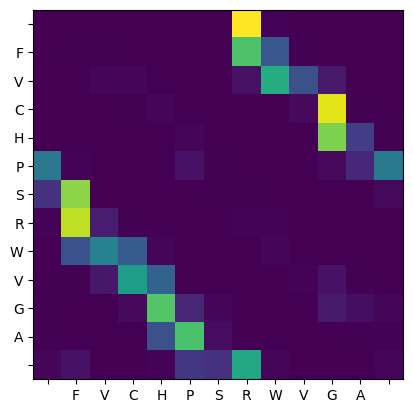

Layer 10, head 19


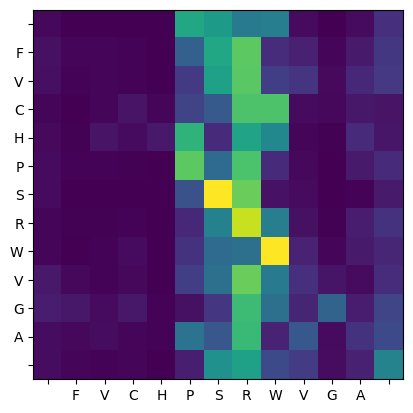

Layer 11, head 0


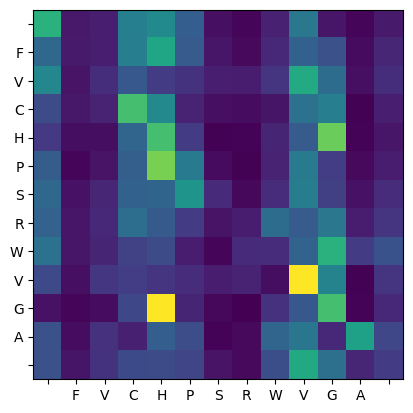

Layer 11, head 1


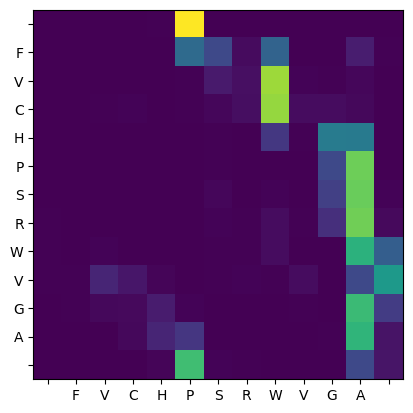

Layer 11, head 2


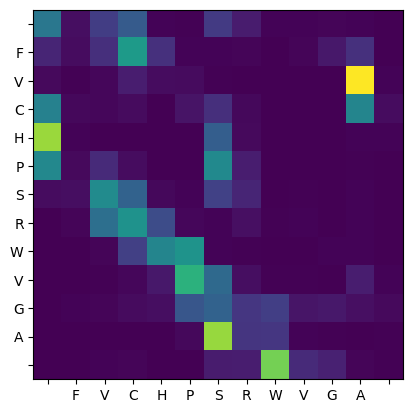

Layer 11, head 3


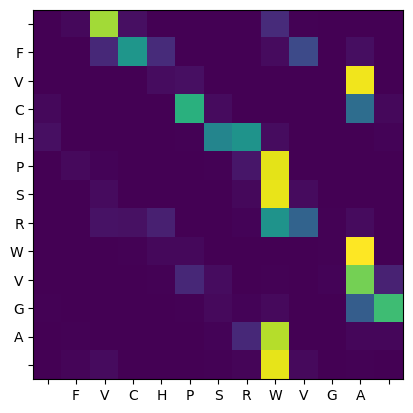

Layer 11, head 4


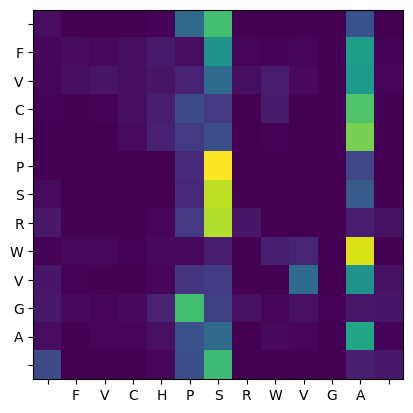

Layer 11, head 5


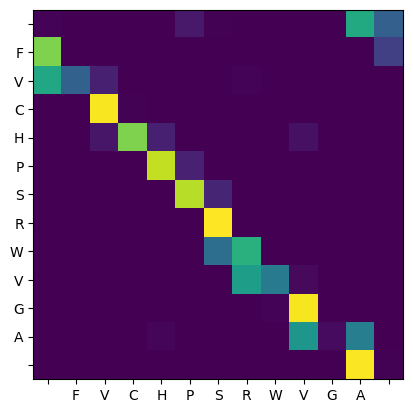

Layer 11, head 6


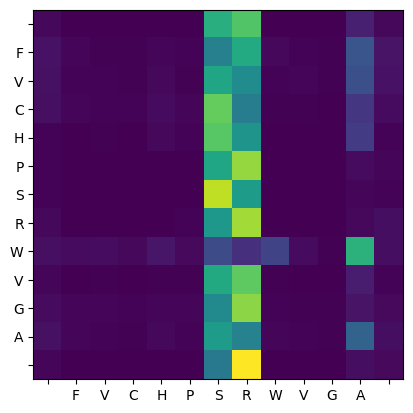

Layer 11, head 7


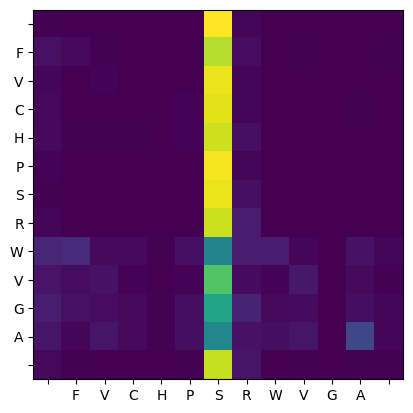

Layer 11, head 8


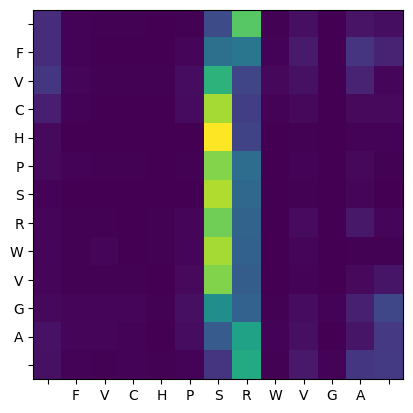

Layer 11, head 9


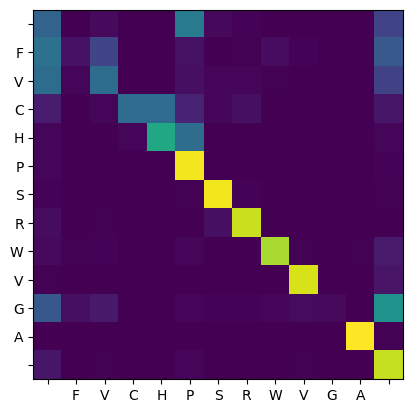

Layer 11, head 10


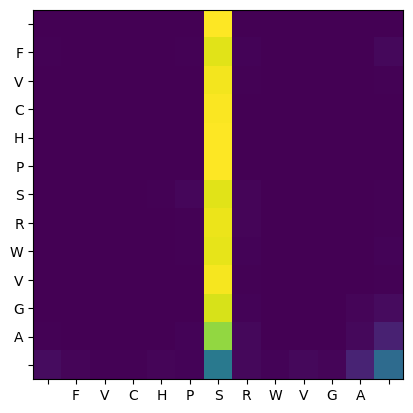

Layer 11, head 11


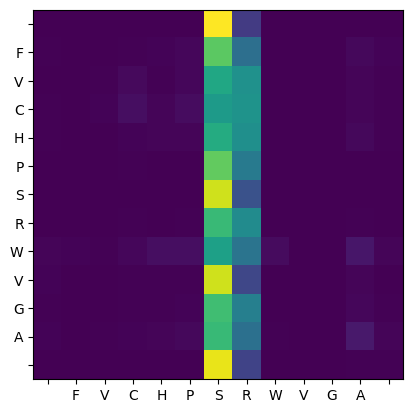

Layer 11, head 12


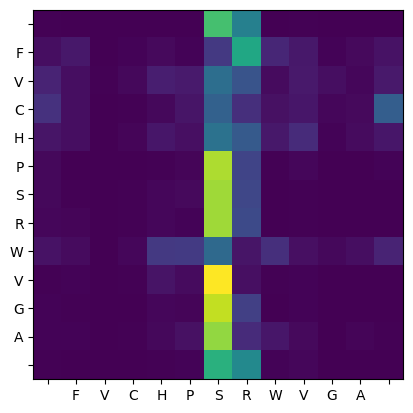

Layer 11, head 13


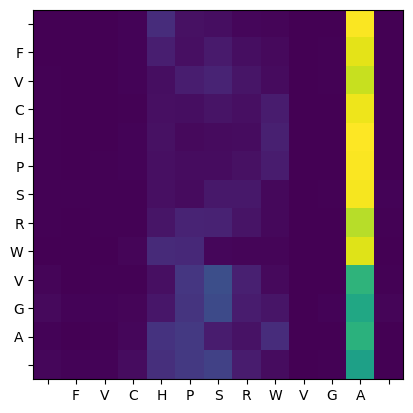

Layer 11, head 14


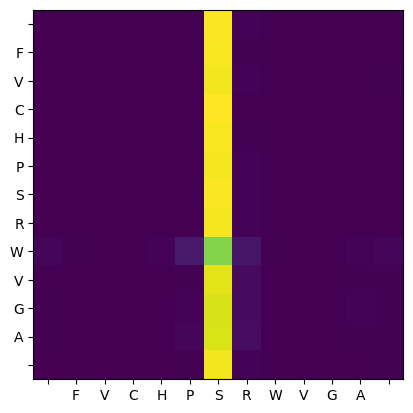

Layer 11, head 15


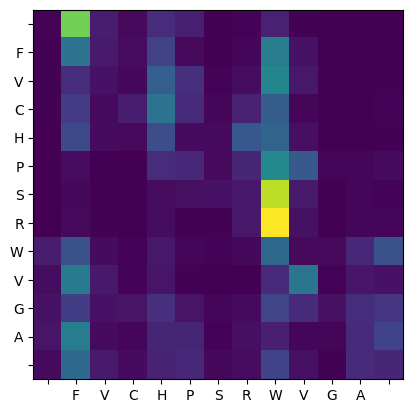

Layer 11, head 16


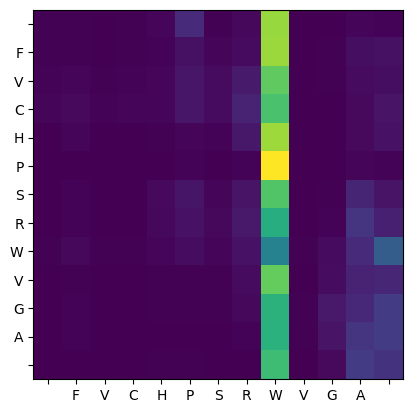

Layer 11, head 17


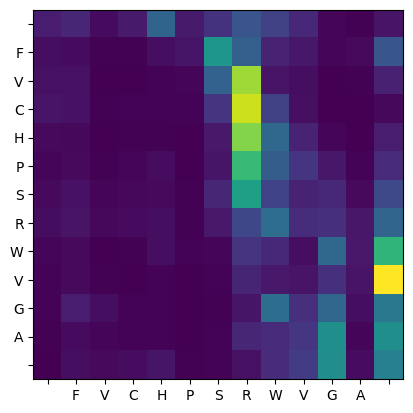

Layer 11, head 18


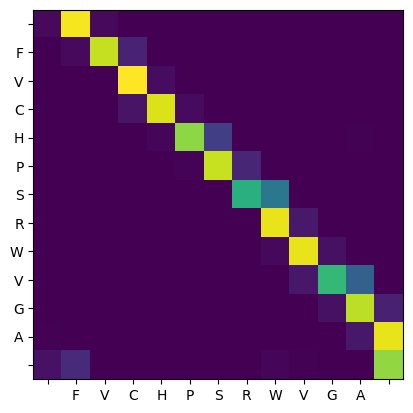

Layer 11, head 19


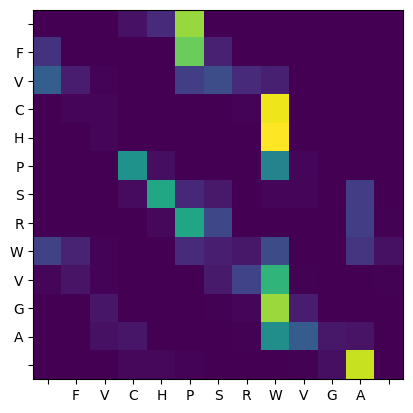

In [21]:
full_attention(LazBF_model, 'FVCHPSRWVGA')

In [34]:
# Empty lists for storing avg contributions
avg_contribBF = np.zeros((20,))
avg_positionBF = np.zeros((11,))
avg_position_contribBF = np.zeros((20, 11))

avg_position_contribBF_counter = np.zeros((20, 11))

# Define model and aa_counter
model = LazBF_model
exp_model = ExplainableTransformerPipeline('distilbert', device)
aa_counts = np.zeros((20,))

for peptide in tqdm(LazBF_sample):
  contributions = exp_model.explain(peptide, 1)
  for i, letter in enumerate(peptide):
    # Add to position avg
    avg_positionBF[i] += contributions[i]
    # Add to pos x AA average
    avg_position_contribBF[amino_acids[letter]][i] += contributions[i]
    avg_position_contribBF_counter[amino_acids[letter]][i] += 1
    # Add to aa average
    avg_contribBF[amino_acids[letter]] += contributions[i]
    # Count amino acid types
    aa_counts[amino_acids[letter]] += 1

avg_position_contribBF = avg_position_contribBF / avg_position_contribBF_counter
avg_contribBF = avg_contribBF / aa_counts
avg_positionBF = avg_positionBF / 50000

  3%|▎         | 1643/50000 [03:51<1:53:27,  7.10it/s]


KeyboardInterrupt: 